In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [2]:
# Определение типов данных для столбцов
dtypes = {
    'uid': 'object',
    'polis_number': 'object',
    'date_z1': 'object',  # Оставляем как object для последующего преобразования
    'sh_code': 'object',
    'sh_name': 'object',
    'lpu_short_name': 'object',
    'lpu_subject': 'object',
    'karina_line_row': 'object',
    'karina_etalon': 'float64',
    'line_karina': 'int64',
    'karina_support_scheme': 'object',
    'drugs_in_scheme': 'object',
    'start_therapy': 'object',
    'last_cycle_end': 'object',
    'diagnosis_date': 'object',
    'age_at_diagnosis': 'float64',
    'diagnosis': 'object',
    'morphology_type_icdo3': 'object',
    'prr_stage': 'object',
    'prr_last_contact': 'object',
    'prr_death_date': 'object',
    'registry_line': 'object',
    'registry_line2': 'object',
    'drug_line': 'object',
    'cr_match': 'object',
    'cr_match_corrected': 'object',
    'last_contact_date_reestr': 'object',
    'stage_reestr': 'object',
    'death_date_reestr': 'object',
    'cause_of_death': 'object',
    'last_diagnosis_reestr': 'object',
    'tariff': 'object'
}

# Чтение CSV
df = pd.read_csv(
    r'data_c56.csv',
    sep=';',
    dtype=dtypes,
    na_values=['#Н/Д', ''],  # Обработка специальных значений как NA
    on_bad_lines='skip'
)

# Преобразование столбцов с датами в datetime
date_columns = ['date_z1', 'start_therapy', 'last_cycle_end', 'diagnosis_date',
                'prr_last_contact', 'prr_death_date', 'last_contact_date_reestr', 'death_date_reestr']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%d.%m.%Y', errors='coerce')

# Преобразование tariff в float64, замена запятой на точку
df['tariff'] = df['tariff'].str.replace(',', '.').astype('float64')

# Преобразование karina_etalon и age_at_diagnosis в int64 после обработки NA
df['karina_etalon'] = df['karina_etalon'].fillna(0).astype('int64')
df['age_at_diagnosis'] = df['age_at_diagnosis'].fillna(0).astype('int64')

# Вывод первых 5 строк и информации о типах данных
df.head()
df.dtypes

uid                                 object
polis_number                        object
date_z1                     datetime64[ns]
sh_code                             object
sh_name                             object
lpu_short_name                      object
lpu_subject                         object
karina_line_row                     object
karina_etalon                        int64
line_karina                          int64
karina_support_scheme               object
drugs_in_scheme                     object
start_therapy               datetime64[ns]
last_cycle_end              datetime64[ns]
diagnosis_date              datetime64[ns]
age_at_diagnosis                     int64
diagnosis                           object
morphology_type_icdo3               object
prr_stage                           object
prr_last_contact            datetime64[ns]
prr_death_date              datetime64[ns]
registry_line                       object
registry_line2                      object
drug_line  

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51451 entries, 0 to 51450
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   uid                       51451 non-null  object        
 1   polis_number              51451 non-null  object        
 2   date_z1                   51451 non-null  datetime64[ns]
 3   sh_code                   51451 non-null  object        
 4   sh_name                   51451 non-null  object        
 5   lpu_short_name            51451 non-null  object        
 6   lpu_subject               51451 non-null  object        
 7   karina_line_row           51451 non-null  object        
 8   karina_etalon             51451 non-null  int64         
 9   line_karina               51451 non-null  int64         
 10  karina_support_scheme     51451 non-null  object        
 11  drugs_in_scheme           51451 non-null  object        
 12  start_therapy     

In [4]:
df.head(10)

,uid,polis_number,date_z1,sh_code,sh_name,lpu_short_name,lpu_subject,karina_line_row,karina_etalon,line_karina,...,registry_line2,drug_line,cr_match,cr_match_corrected,last_contact_date_reestr,stage_reestr,death_date_reestr,cause_of_death,last_diagnosis_reestr,tariff
0,0149620890000059_43930,149620890000059,2020-04-09,sh675,Паклитаксел 175-200 мг/м? в 1-й день + цисплат...,"ФГБУ ""НМИЦ ОНКОЛОГИИ ИМ. Н.Н. ПЕТРОВА"" МИНЗДРА...",г. Санкт-Петербург,01.01.,1,1,...,Последующие циклы линии (кроме последнего),Паклитаксел + цисплатин01,соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,56007.21
1,0149620890000059_43972,149620890000059,2020-05-21,sh672,Паклитаксел 175-225 мг/м? в 1-й день + карбопл...,"ФГБУ ""НМИЦ ОНКОЛОГИИ ИМ. Н.Н. ПЕТРОВА"" МИНЗДРА...",г. Санкт-Петербург,01.01.,1,1,...,Последующие циклы линии (кроме последнего),Карбоплатин + паклитаксел01,соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,61173.19
2,0149620890000059_44001,149620890000059,2020-06-19,sh672,Паклитаксел 175-225 мг/м? в 1-й день + карбопл...,"ФГБУ ""НМИЦ ОНКОЛОГИИ ИМ. Н.Н. ПЕТРОВА"" МИНЗДРА...",г. Санкт-Петербург,01.01.,1,1,...,Последующие циклы линии (кроме последнего),Карбоплатин + паклитаксел01,соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,61173.19
3,0149620890000059_44022,149620890000059,2020-07-10,sh672,Паклитаксел 175-225 мг/м? в 1-й день + карбопл...,"ФГБУ ""НМИЦ ОНКОЛОГИИ ИМ. Н.Н. ПЕТРОВА"" МИНЗДРА...",г. Санкт-Петербург,01.01.,1,1,...,Последующие циклы линии (кроме последнего),Карбоплатин + паклитаксел01,соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,61173.19
4,0149620890000059_44047,149620890000059,2020-08-04,sh672,Паклитаксел 175-225 мг/м? в 1-й день + карбопл...,"ФГБУ ""НМИЦ ОНКОЛОГИИ ИМ. Н.Н. ПЕТРОВА"" МИНЗДРА...",г. Санкт-Петербург,01.01.,1,1,...,Последующие циклы линии (кроме последнего),Карбоплатин + паклитаксел01,соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,61173.19
5,0149620890000059_44396,149620890000059,2021-07-19,sh0161,Пеметрексед 500 мг/м? в 1-й день; цикл 21 день,ООО «АВ МЕДИКАЛ ГРУПП»,г. Санкт-Петербург,02.01.,1,2,...,Первый цикл линии,Пеметрексед02,соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,65174.18
6,0149620890000059_44417,149620890000059,2021-08-09,sh0828,Пеметрексед 500 мг/м? в 1-й день + бевацизумаб...,ООО «АВ МЕДИКАЛ ГРУПП»,г. Санкт-Петербург,02.01.,1,2,...,Первый цикл линии,Бевацизумаб + пеметрексед02,не соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,161340.17
7,0149620890000059_44449,149620890000059,2021-09-10,sh0828,Пеметрексед 500 мг/м? в 1-й день + бевацизумаб...,ООО «АВ МЕДИКАЛ ГРУПП»,г. Санкт-Петербург,02.01.,1,2,...,Последующие циклы линии (кроме последнего),Бевацизумаб + пеметрексед02,не соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,161340.17
8,0149620890000059_44470,149620890000059,2021-10-01,sh0828,Пеметрексед 500 мг/м? в 1-й день + бевацизумаб...,ООО «АВ МЕДИКАЛ ГРУПП»,г. Санкт-Петербург,02.01.,1,2,...,Последующие циклы линии (кроме последнего),Бевацизумаб + пеметрексед02,не соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,161340.17
9,0149620890000059_44495,149620890000059,2021-10-26,sh0828,Пеметрексед 500 мг/м? в 1-й день + бевацизумаб...,ООО «АВ МЕДИКАЛ ГРУПП»,г. Санкт-Петербург,02.01.,1,2,...,Последующие циклы линии (кроме последнего),Бевацизумаб + пеметрексед02,не соот КР,соот КР,2024-06-18,IIIC,NaT,0,C56,161340.17


In [5]:
# Проверка количества NaN/NaT
print(df.isna().sum())

uid                             0
polis_number                    0
date_z1                         0
sh_code                         0
sh_name                         0
lpu_short_name                  0
lpu_subject                     0
karina_line_row                 0
karina_etalon                   0
line_karina                     0
karina_support_scheme           0
drugs_in_scheme                 0
start_therapy                   0
last_cycle_end                  0
diagnosis_date              18523
age_at_diagnosis                0
diagnosis                   18523
morphology_type_icdo3       18523
prr_stage                   18523
prr_last_contact            18523
prr_death_date              38267
registry_line                 180
registry_line2                180
drug_line                       0
cr_match                        0
cr_match_corrected              0
last_contact_date_reestr      605
stage_reestr                 7532
death_date_reestr           51451
cause_of_death

In [6]:
# Замена '00.01.1900' на NaT в столбцах с датами
date_columns = ['date_z1', 'start_therapy', 'last_cycle_end', 'diagnosis_date',
                'prr_last_contact', 'prr_death_date', 'last_contact_date_reestr', 'death_date_reestr']
for col in date_columns:
    df[col] = df[col].replace('1900-01-01', pd.NaT)

# Создание флага выживаемости на основе death_date_reestr
df['is_alive'] = df['prr_death_date'].isna().astype(int)  # 1 = жив, 0 = умер

# Проверка результатов
df[date_columns + ['is_alive']].head(1000)

,date_z1,start_therapy,last_cycle_end,diagnosis_date,prr_last_contact,prr_death_date,last_contact_date_reestr,death_date_reestr,is_alive
0,2020-04-09,2020-04-09,2022-07-28,NaT,NaT,NaT,2024-06-18,NaT,1
1,2020-05-21,2020-04-09,2022-07-28,NaT,NaT,NaT,2024-06-18,NaT,1
2,2020-06-19,2020-04-09,2022-07-28,NaT,NaT,NaT,2024-06-18,NaT,1
3,2020-07-10,2020-04-09,2022-07-28,NaT,NaT,NaT,2024-06-18,NaT,1
4,2020-08-04,2020-04-09,2022-07-28,NaT,NaT,NaT,2024-06-18,NaT,1
...,...,...,...,...,...,...,...,...,...
995,2021-08-26,2021-05-31,2021-09-16,2021-03-04,2024-02-06,NaT,2024-02-02,NaT,1
996,2021-09-16,2021-05-31,2021-09-16,2021-03-04,2024-02-06,NaT,2024-02-02,NaT,1
997,2022-12-06,2022-12-06,2023-02-20,2022-01-12,2024-03-27,NaT,2024-04-03,NaT,1
998,2022-12-28,2022-12-06,2023-02-20,2022-01-12,2024-03-27,NaT,2024-04-03,NaT,1


In [7]:
# Замена данных по стадиям на Unknow
df['prr_stage'] = df['prr_stage'].fillna('Unknown')
df['stage_reestr'] = df['stage_reestr'].fillna('Unknown')

In [8]:
df['prr_stage'].unique()

array(['Unknown', '4A', '3', '3C', '1C', '4', '2A', '3B', '1', '1A',
       '3A2', '3A', '3A1', '2B', '2', '4B', '2C', '1B', '3C2', '0', '4C'],
      dtype=object)

In [9]:
# Подсчет уникальных пациентов по polis_number и статусу is_alive
result = df.groupby('is_alive')['polis_number'].nunique()

# Вывод результатов
print("Живы (is_alive=1):", result[1])
print("Умерли (is_alive=0):", result[0])

Живы (is_alive=1): 4239
Умерли (is_alive=0): 983


In [10]:
# Фильтрация пациентов с line_karina != 0
df_filtered = df[df['line_karina'] != 0]

# Создание таблицы для уникальных пациентов
df_unique = df_filtered.groupby('polis_number').agg({
    'date_z1': lambda x: x[df_filtered.loc[x.index, 'line_karina'] == 1].min(),
    'prr_death_date': 'last',
    'prr_last_contact': 'last',
    'last_contact_date_reestr': 'last',
    'is_alive': 'last',
    'prr_stage': 'last',
    'stage_reestr': lambda x: x.mode()[0] if not x.mode().empty else np.nan
}).reset_index()

# Определение даты последнего контакта
df_unique['last_contact'] = df_unique.apply(
    lambda row: max(row['last_contact_date_reestr'], row['prr_last_contact']) if pd.notna(row['last_contact_date_reestr']) or pd.notna(row['prr_last_contact'])
    else pd.NaT, axis=1)
df_unique['last_contact'] = df_unique.apply(
    lambda row: row['last_contact'] if pd.notna(row['last_contact']) and row['last_contact'] >= row['date_z1'] else row['date_z1'], axis=1)

# Определение даты события с проверкой
df_unique['event_date'] = df_unique.apply(
    lambda row: row['prr_death_date'] if row['is_alive'] == 0 and pd.notna(row['prr_death_date'])
    else row['last_contact'] if pd.notna(row['last_contact']) and row['last_contact'] >= row['date_z1']
    else pd.NaT, axis=1)

# Расчет времени выживаемости в месяцах
df_unique['survival_months'] = (df_unique['event_date'] - df_unique['date_z1']).dt.days / 30.42
df_unique = df_unique[df_unique['survival_months'] >= 0]

# Выбор стадии
df_unique['stage'] = df_unique['prr_stage'].where(
    df_unique['prr_stage'].notna(), df_unique['stage_reestr'])

# Укрупнение стадий
def simplify_stage(stage):
    if pd.isna(stage) or str(stage) in ['0', 'Unknown']:
        return np.nan

    stage_str = str(stage).upper().strip()

    # Стадия I и все подстадии
    if stage_str in ['1', '1A', '1B', '1C']:
        return 'I'
    # Стадия II и все подстадии
    elif stage_str in ['2', '2A', '2B', '2C']:
        return 'II'
    # Стадия III и все подстадии
    elif stage_str in ['3', '3A', '3A1', '3A2', '3B', '3C', '3C2']:
        return 'III'
    # Стадия IV и все подстадии
    elif stage_str in ['4', '4A', '4B', '4C']:
        return 'IV'
    else:
        return np.nan

df_unique['stage_simplified'] = df_unique['stage'].apply(simplify_stage)

# Подсчет исключенных пациентов
excluded_patients = df_unique[df_unique['stage_simplified'].isna()]['polis_number'].nunique()
total_patients = df_unique['polis_number'].nunique()
excluded_percent = (excluded_patients / total_patients) * 100
print(f"Пациентов с prr_stage или stage_reestr = '0' или 'Unknown': {excluded_patients} ({excluded_percent:.1f}% от общего числа пациентов)")

# Удаление строк с NaN
df_unique = df_unique.dropna(subset=['survival_months'])
df_unique_stage = df_unique.dropna(subset=['stage_simplified'])

# Расчет медианы общей выживаемости
kmf = KaplanMeierFitter()
kmf.fit(df_unique['survival_months'], event_observed=(df_unique['is_alive'] == 0))
median_survival = kmf.median_survival_time_
std_error = sem(df_unique['survival_months'].dropna()) if median_survival != np.inf else np.nan
ci_lower = median_survival - 1.96 * std_error if not np.isnan(std_error) else np.nan
ci_upper = median_survival + 1.96 * std_error if not np.isnan(std_error) else np.nan

# Подготовка данных для CoxPH
cox_data = df_unique.copy()
cox_data['stage_simplified'] = cox_data['stage_simplified'].fillna('Reference')
cox_data = pd.get_dummies(cox_data, columns=['stage_simplified'], drop_first=False)
# Удаляем stage_simplified_I как референсную группу
cox_data = cox_data.drop(columns=['stage_simplified_I'])

# CoxPH модель для HR
cph = CoxPHFitter()
cox_columns = ['survival_months', 'is_alive'] + [col for col in cox_data.columns if col.startswith('stage_simplified_')]
cph.fit(cox_data[cox_columns], duration_col='survival_months', event_col='is_alive')
hr_summary = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

# Вывод общей выживаемости
overall_table = pd.DataFrame({
    'Метрика': ['Медиана (месяцы)', '95% ДИ (нижний)', '95% ДИ (верхний)', 'p-value'],
    'Значение': [f"{median_survival:.1f}" if median_survival != np.inf else 'Не достигнута',
                 f"{ci_lower:.1f}" if not np.isnan(ci_lower) else '-',
                 f"{ci_upper:.1f}" if not np.isnan(ci_upper) else '-', '-']
})
print("\nТаблица общей выживаемости:")
print(overall_table)

# График Kaplan-Meier для общей выживаемости с медианой
plt.figure(figsize=(10, 6))
kmf.fit(df_unique['survival_months'], event_observed=(df_unique['is_alive'] == 0), label='Общая выживаемость')
kmf.plot_survival_function()
plt.ylim(0, 1)
if median_survival != np.inf:
    median_survival_prob = 0.5
    plt.plot([0, median_survival, median_survival], [median_survival_prob, median_survival_prob, 0], '--', linewidth=0.5, color='#333333', label=f'Медиана: {median_survival:.1f} месяцев')
    plt.plot(median_survival, median_survival_prob, 'o', color='red', markersize=5)
plt.title('Кривая общей выживаемости')
plt.xlabel('Месяцы')
plt.ylabel('Вероятность выживания')
plt.legend()
plt.savefig('overall_survival.png')
plt.close()

# Расчет медианы по укрупненным стадиям
stage_medians = df_unique_stage.groupby('stage_simplified').agg({
    'survival_months': lambda x: KaplanMeierFitter().fit(x, event_observed=(df_unique_stage.loc[x.index, 'is_alive'] == 0)).median_survival_time_,
    'polis_number': 'nunique'
}).reset_index()
stage_medians.columns = ['Стадия', 'Медиана (месяцы)', 'Количество пациентов']
stage_medians['% от общего числа'] = (stage_medians['Количество пациентов'] / total_patients) * 100

# Log-rank тест для сравнения стадий
stages = df_unique_stage['stage_simplified'].unique()
p_values = {}
for i, stage1 in enumerate(stages):
    for stage2 in stages[i+1:]:
        group1 = df_unique_stage[df_unique_stage['stage_simplified'] == stage1]
        group2 = df_unique_stage[df_unique_stage['stage_simplified'] == stage2]
        result = logrank_test(
            group1['survival_months'], group2['survival_months'],
            event_observed_A=(group1['is_alive'] == 0),
            event_observed_B=(group2['is_alive'] == 0)
        )
        p_values[f"{stage1} vs {stage2}"] = result.p_value

# Вывод таблицы по стадиям
print("\nТаблица выживаемости по стадиям:")
print(stage_medians)

# Вывод HR и p-value из CoxPH
print("\nHR и p-value для стадий (CoxPH) с референсом I:")
print(hr_summary)

# Вывод p-value для log-rank теста
print("\nP-value для log-rank теста между стадиями:")
for pair, p_val in p_values.items():
    print(f"{pair}: {p_val:.4f}")

# График Kaplan-Meier для укрупненных стадий с медианами
plt.figure(figsize=(10, 6))
for stage in stages:
    stage_data = df_unique_stage[df_unique_stage['stage_simplified'] == stage]
    kmf.fit(stage_data['survival_months'], event_observed=(stage_data['is_alive'] == 0), label=stage)
    ax = kmf.plot_survival_function()
    median = stage_medians[stage_medians['Стадия'] == stage]['Медиана (месяцы)'].iloc[0]
    if median != np.inf:
        median_prob = 0.5
        plt.plot([0, median, median], [median_prob, median_prob, 0], '--', linewidth=0.5, color='#333333', alpha=0.5)
        plt.plot(median, median_prob, 'o', color='red', markersize=5)
plt.ylim(0, 1)
plt.title('Кривые выживаемости по укрупненным стадиям заболевания')
plt.xlabel('Месяцы')
plt.ylabel('Вероятность выживания')
plt.legend()
plt.savefig('stage_survival.png')
plt.close()



Пациентов с prr_stage или stage_reestr = '0' или 'Unknown': 1657 (40.2% от общего числа пациентов)

Таблица общей выживаемости:
            Метрика       Значение
0  Медиана (месяцы)  Не достигнута
1   95% ДИ (нижний)              -
2  95% ДИ (верхний)              -
3           p-value              -

Таблица выживаемости по стадиям:
  Стадия  Медиана (месяцы)  Количество пациентов  % от общего числа
0      I               inf                   359           8.709364
1     II               inf                   336           8.151383
2    III         53.122945                  1281          31.077147
3     IV         40.203813                   489          11.863173

HR и p-value для стадий (CoxPH) с референсом I:
                            exp(coef)  exp(coef) lower 95%  \
covariate                                                    
stage_simplified_II          0.935914             0.794007   
stage_simplified_III         0.857160             0.751681   
stage_simplified_IV       

In [11]:
print(df_unique['date_z1'].min(), df_unique['date_z1'].max())

2018-12-07 00:00:00 2023-09-21 00:00:00


In [12]:
print(df_unique['event_date'].min(), df_unique['event_date'].max())

2019-01-03 00:00:00 2024-09-17 00:00:00


In [13]:
print(df_unique[df_unique['survival_months'] < 0][['date_z1', 'prr_death_date', 'prr_last_contact', 'last_contact_date_reestr', 'event_date']])

Empty DataFrame
Columns: [date_z1, prr_death_date, prr_last_contact, last_contact_date_reestr, event_date]
Index: []


In [14]:
df_unique['date_check'] = df_unique['date_z1'] > df_unique['event_date']
print(df_unique[df_unique['date_check'] == True])



Empty DataFrame
Columns: [polis_number, date_z1, prr_death_date, prr_last_contact, last_contact_date_reestr, is_alive, prr_stage, stage_reestr, last_contact, event_date, survival_months, stage, stage_simplified, date_check]
Index: []


Топ-10 препаратов первой линии:
drug_group
Карбоплатин + паклитаксел                  2561
Бевацизумаб + карбоплатин + паклитаксел     499
Карбоплатин                                 151
Бевацизумаб                                 126
Паклитаксел + цисплатин                     110
Доксорубицин + карбоплатин                   51
Гемцитабин                                   45
Гемцитабин + карбоплатин                     42
Бевацизумаб + паклитаксел + цисплатин        39
Бевацизумаб + доксорубицин                   36
Name: count, dtype: int64

Всего уникальных комбинаций препаратов: 60

Медиана выживаемости по препаратам первой линии:
                                  Препарат  N пациентов Медиана (месяцы)  \
0                Карбоплатин + паклитаксел         2561    Не достигнута   
1  Бевацизумаб + карбоплатин + паклитаксел          499             62.5   
2                              Карбоплатин          151             53.9   
3                              Бевацизумаб          1

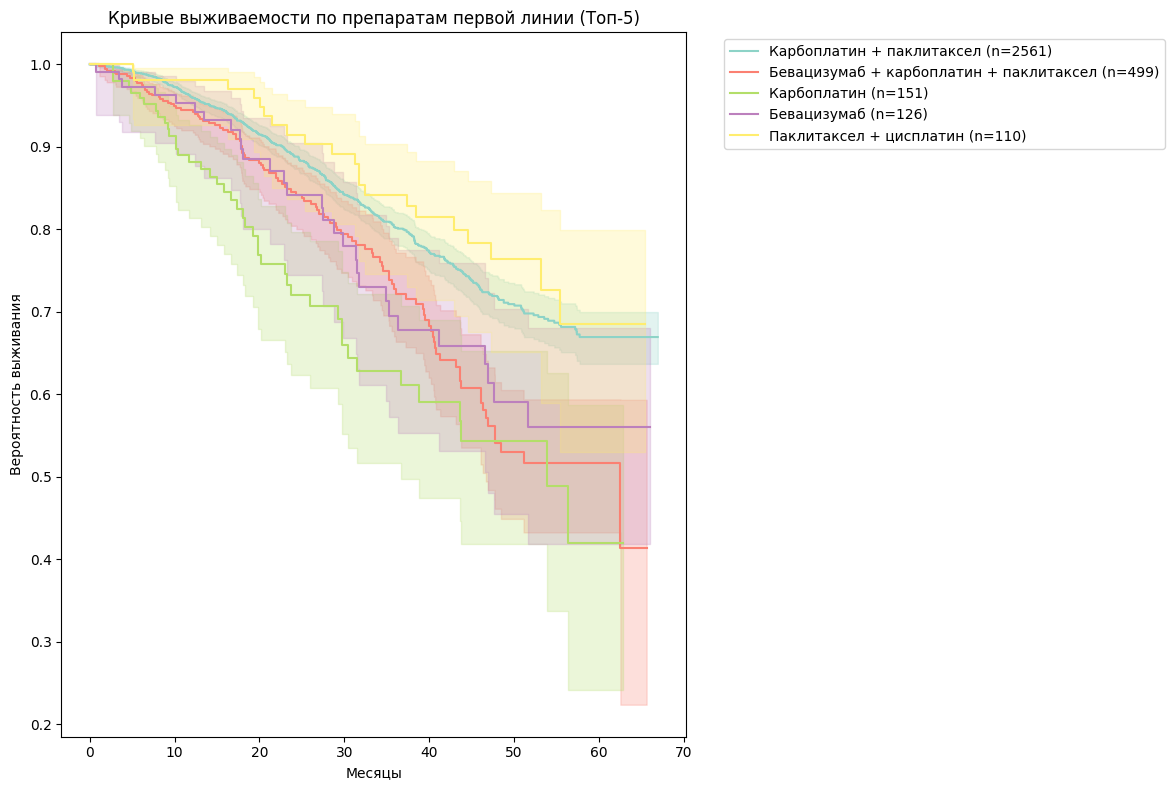

In [15]:
# Анализ выживаемости по препаратам первой линии
def analyze_survival_by_drugs(df_filtered, df_unique):
    """
    Анализ выживаемости по группам препаратов первой линии
    """
    # Получаем препараты первой линии для каждого пациента
    first_line_drugs = df_filtered[df_filtered['line_karina'] == 1].groupby('polis_number')['drug_line'].first().reset_index()

    # Объединяем с данными выживаемости
    df_drugs = df_unique.merge(first_line_drugs, on='polis_number', how='left')

    # Извлекаем только название препарата без номера линии
    df_drugs['drug_group'] = df_drugs['drug_line'].str.replace(r'\d+$', '', regex=True)

    # Топ-10 наиболее частых комбинаций препаратов
    top_drugs = df_drugs['drug_group'].value_counts().head(10)

    print("Топ-10 препаратов первой линии:")
    print(top_drugs)
    print(f"\nВсего уникальных комбинаций препаратов: {df_drugs['drug_group'].nunique()}")

    # Расчет медианы выживаемости для топ-5 препаратов
    top5_drugs = top_drugs.head(5).index
    drug_medians = []

    for drug in top5_drugs:
        drug_data = df_drugs[df_drugs['drug_group'] == drug]
        kmf_drug = KaplanMeierFitter()
        kmf_drug.fit(drug_data['survival_months'], event_observed=(drug_data['is_alive'] == 0))

        drug_medians.append({
            'Препарат': drug,
            'N пациентов': len(drug_data),
            'Медиана (месяцы)': f"{kmf_drug.median_survival_time_:.1f}" if kmf_drug.median_survival_time_ != np.inf else 'Не достигнута',
            'Событий': (drug_data['is_alive'] == 0).sum()
        })

    drug_median_df = pd.DataFrame(drug_medians)
    print("\nМедиана выживаемости по препаратам первой линии:")
    print(drug_median_df)

    # График Kaplan-Meier для топ-5 препаратов
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(top5_drugs)))

    for i, drug in enumerate(top5_drugs):
        drug_data = df_drugs[df_drugs['drug_group'] == drug]
        kmf_drug = KaplanMeierFitter()
        kmf_drug.fit(drug_data['survival_months'],
                     event_observed=(drug_data['is_alive'] == 0),
                     label=f"{drug} (n={len(drug_data)})")
        kmf_drug.plot_survival_function(color=colors[i])

    plt.title('Кривые выживаемости по препаратам первой линии (Топ-5)')
    plt.xlabel('Месяцы')
    plt.ylabel('Вероятность выживания')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('survival_by_drugs.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df_drugs

# Вызов функции
df_drugs = analyze_survival_by_drugs(df_filtered, df_unique)

Пациентов с данными о возрасте: 2473 из 4122

Распределение пациентов по возрастным группам:
  Возрастная группа  N пациентов  Смертей  % смертности
0               <40          155       19          12.3
1             40-49          462      124          26.8
2             50-59          753      260          34.5
3             60-69          772      292          37.8
4               ≥70          331      130          39.3

Медиана выживаемости по возрастным группам:
  Возрастная группа    N Медиана (месяцы)
0               <40  155    Не достигнута
1             40-49  462    Не достигнута
2             50-59  753             57.4
3             60-69  772             46.9
4               ≥70  331             43.4


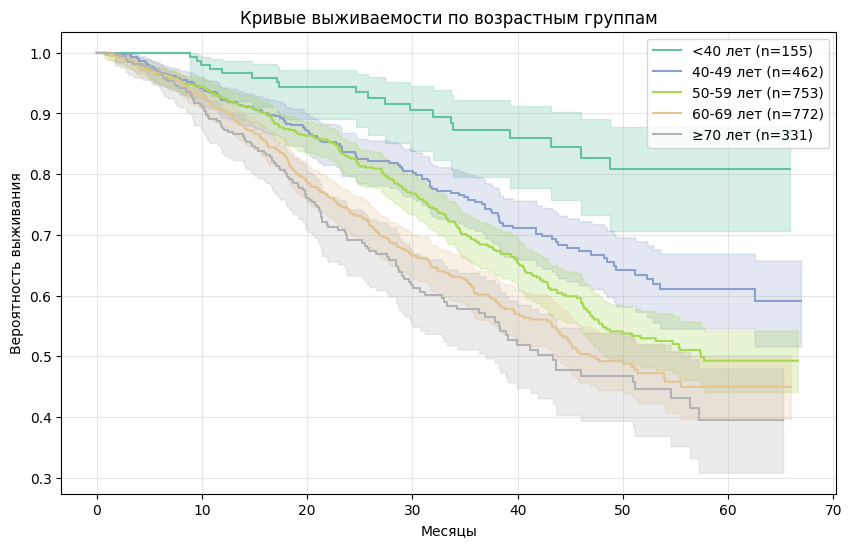


Log-rank тест между возрастными группами:
<40 vs 40-49: p-value = 0.0005
<40 vs 50-59: p-value = 0.0000
<40 vs 60-69: p-value = 0.0000
<40 vs ≥70: p-value = 0.0000
40-49 vs 50-59: p-value = 0.0206
40-49 vs 60-69: p-value = 0.0000
40-49 vs ≥70: p-value = 0.0000
50-59 vs 60-69: p-value = 0.0022
50-59 vs ≥70: p-value = 0.0001
60-69 vs ≥70: p-value = 0.2028


In [16]:
# Сначала добавим age_at_diagnosis в df_unique
def add_age_to_unique(df_filtered, df_unique):
    """
    Добавляет возраст при диагнозе к уникальным пациентам
    """
    # Получаем возраст для каждого пациента (берем первое значение)
    age_data = df_filtered.groupby('polis_number')['age_at_diagnosis'].first().reset_index()

    # Объединяем с df_unique
    df_unique = df_unique.merge(age_data, on='polis_number', how='left')

    return df_unique

# Обновляем df_unique
df_unique = add_age_to_unique(df_filtered, df_unique)

# Теперь исправленная функция анализа по возрастным группам
def analyze_survival_by_age(df_unique):
    """
    Анализ выживаемости по возрастным группам
    """
    # Проверяем наличие данных о возрасте
    if 'age_at_diagnosis' not in df_unique.columns:
        print("Ошибка: отсутствует столбец age_at_diagnosis")
        return

    # Фильтруем пациентов с валидным возрастом
    df_age = df_unique[df_unique['age_at_diagnosis'] > 0].copy()

    print(f"Пациентов с данными о возрасте: {len(df_age)} из {len(df_unique)}")

    # Создаем возрастные группы
    df_age['age_group'] = pd.cut(df_age['age_at_diagnosis'],
                                  bins=[0, 40, 50, 60, 70, 100],
                                  labels=['<40', '40-49', '50-59', '60-69', '≥70'])

    # Статистика по возрастным группам
    age_stats = df_age.groupby('age_group').agg({
        'polis_number': 'count',
        'is_alive': lambda x: (x == 0).sum()
    }).reset_index()
    age_stats.columns = ['Возрастная группа', 'N пациентов', 'Смертей']
    age_stats['% смертности'] = (age_stats['Смертей'] / age_stats['N пациентов'] * 100).round(1)

    print("\nРаспределение пациентов по возрастным группам:")
    print(age_stats)

    # Расчет медианы выживаемости по возрастным группам
    age_medians = []
    for age_group in df_age['age_group'].cat.categories:
        age_data = df_age[df_age['age_group'] == age_group]
        if len(age_data) > 0:
            kmf_age = KaplanMeierFitter()
            kmf_age.fit(age_data['survival_months'], event_observed=(age_data['is_alive'] == 0))

            age_medians.append({
                'Возрастная группа': age_group,
                'N': len(age_data),
                'Медиана (месяцы)': f"{kmf_age.median_survival_time_:.1f}" if kmf_age.median_survival_time_ != np.inf else 'Не достигнута'
            })

    age_median_df = pd.DataFrame(age_medians)
    print("\nМедиана выживаемости по возрастным группам:")
    print(age_median_df)

    # График Kaplan-Meier по возрастным группам
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Set2(np.linspace(0, 1, len(df_age['age_group'].cat.categories)))

    for i, age_group in enumerate(df_age['age_group'].cat.categories):
        age_data = df_age[df_age['age_group'] == age_group]
        if len(age_data) > 0:
            kmf_age = KaplanMeierFitter()
            kmf_age.fit(age_data['survival_months'],
                       event_observed=(age_data['is_alive'] == 0),
                       label=f"{age_group} лет (n={len(age_data)})")
            kmf_age.plot_survival_function(color=colors[i])

    plt.title('Кривые выживаемости по возрастным группам')
    plt.xlabel('Месяцы')
    plt.ylabel('Вероятность выживания')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('survival_by_age.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Log-rank тест между возрастными группами
    print("\nLog-rank тест между возрастными группами:")
    age_groups_list = list(df_age['age_group'].cat.categories)
    for i in range(len(age_groups_list)):
        for j in range(i+1, len(age_groups_list)):
            group1 = df_age[df_age['age_group'] == age_groups_list[i]]
            group2 = df_age[df_age['age_group'] == age_groups_list[j]]

            if len(group1) > 0 and len(group2) > 0:
                result = logrank_test(
                    group1['survival_months'], group2['survival_months'],
                    event_observed_A=(group1['is_alive'] == 0),
                    event_observed_B=(group2['is_alive'] == 0)
                )
                print(f"{age_groups_list[i]} vs {age_groups_list[j]}: p-value = {result.p_value:.4f}")

    return df_age

# Вызов функции
df_age = analyze_survival_by_age(df_unique)

In [17]:
# Анализ по медицинским учреждениям
def analyze_by_medical_centers(df_filtered, df_unique):
    """
    Анализ выживаемости по медицинским учреждениям
    """
    # Получаем учреждение для каждого пациента (где началась терапия)
    first_center = df_filtered[df_filtered['line_karina'] == 1].groupby('polis_number')['lpu_short_name'].first().reset_index()

    # Объединяем с данными выживаемости
    df_centers = df_unique.merge(first_center, on='polis_number', how='left')

    # Топ-10 медицинских центров по количеству пациентов
    top_centers = df_centers['lpu_short_name'].value_counts().head(10)

    print("Топ-10 медицинских центров по количеству пациентов:")
    for center, count in top_centers.items():
        print(f"{center[:50]}... : {count} пациентов")

    # Статистика по топ-5 центрам
    center_stats = []
    for center in top_centers.head(5).index:
        center_data = df_centers[df_centers['lpu_short_name'] == center]
        kmf_center = KaplanMeierFitter()
        kmf_center.fit(center_data['survival_months'], event_observed=(center_data['is_alive'] == 0))

        center_stats.append({
            'Центр': center[:30] + '...',
            'N пациентов': len(center_data),
            'Медиана (мес)': f"{kmf_center.median_survival_time_:.1f}" if kmf_center.median_survival_time_ != np.inf else 'Не достигнута',
            '% смертности': f"{(center_data['is_alive'] == 0).sum() / len(center_data) * 100:.1f}"
        })

    center_stats_df = pd.DataFrame(center_stats)
    print("\nСтатистика выживаемости по топ-5 медицинским центрам:")
    print(center_stats_df)

    return df_centers

# Вызов функции
df_centers = analyze_by_medical_centers(df_filtered, df_unique)

Топ-10 медицинских центров по количеству пациентов:
СПБ ГБУЗ "ГКОД"... : 744 пациентов
ГБУЗ "СПБ КНПЦСВМП(О)"... : 730 пациентов
ГБУЗ "ПОКОД"... : 221 пациентов
ГБУ АО "АКОД"... : 219 пациентов
КАЛИНИНГРАДСКАЯ ОКБ... : 184 пациентов
ГОБУЗ "МООД"... : 184 пациентов
ФГБУ "НМИЦ ОНКОЛОГИИ ИМ. Н.Н. ПЕТРОВА" МИНЗДРАВА Р... : 181 пациентов
ГБУЗ ЛОКОД... : 172 пациентов
БУЗ ВО "ВОЛОГОДСКИЙ ОБЛАСТНОЙ ОНКОЛОГИЧЕСКИЙ ДИСПА... : 168 пациентов
ГОБУЗ "ОКОД"... : 143 пациентов

Статистика выживаемости по топ-5 медицинским центрам:
                       Центр  N пациентов  Медиана (мес) % смертности
0         СПБ ГБУЗ "ГКОД"...          744  Не достигнута         19.5
1  ГБУЗ "СПБ КНПЦСВМП(О)"...          730  Не достигнута         20.5
2            ГБУЗ "ПОКОД"...          221           35.0         47.5
3           ГБУ АО "АКОД"...          219           46.9         39.3
4     КАЛИНИНГРАДСКАЯ ОКБ...          184  Не достигнута         11.4


In [18]:
# Проверяем структуру df_unique
print("Столбцы в df_unique:")
print(df_unique.columns.tolist())
print("\nПервые 5 строк df_unique:")
print(df_unique.head())

Столбцы в df_unique:
['polis_number', 'date_z1', 'prr_death_date', 'prr_last_contact', 'last_contact_date_reestr', 'is_alive', 'prr_stage', 'stage_reestr', 'last_contact', 'event_date', 'survival_months', 'stage', 'stage_simplified', 'date_check', 'age_at_diagnosis']

Первые 5 строк df_unique:
       polis_number    date_z1 prr_death_date prr_last_contact  \
0  1047040891000167 2022-12-21            NaT       2024-06-26   
1  1047130869000206 2022-05-24     2022-09-18       2022-09-18   
2  1047220874000158 2021-01-19            NaT       2024-06-13   
3  1047420885000268 2019-03-25     2021-04-17       2021-04-17   
4  1047720878000146 2020-11-19     2021-12-04       2021-12-04   

  last_contact_date_reestr  is_alive prr_stage stage_reestr last_contact  \
0               2024-06-19         1         4           IV   2024-06-26   
1               2022-08-31         0         4          IVB   2022-09-18   
2               2024-06-20         1         3      Unknown   2024-06-20   
3   

In [19]:
# Пересоздадим df_unique с нужными столбцами
def recreate_df_unique_with_all_data(df_filtered):
    """
    Пересоздает df_unique со всеми необходимыми столбцами
    """
    # Фильтрация пациентов с line_karina != 0
    df_filtered_lines = df_filtered[df_filtered['line_karina'] != 0].copy()

    # Создание таблицы для уникальных пациентов
    df_unique_new = df_filtered_lines.groupby('polis_number').agg({
        'date_z1': lambda x: x[df_filtered_lines.loc[x.index, 'line_karina'] == 1].min(),
        'prr_death_date': 'last',
        'prr_last_contact': 'last',
        'last_contact_date_reestr': 'last',
        'is_alive': 'last',
        'prr_stage': 'last',
        'stage_reestr': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'age_at_diagnosis': 'first',  # Добавляем возраст
        'lpu_short_name': 'first',    # Добавляем медцентр
        'diagnosis': 'first'           # Добавляем диагноз
    }).reset_index()

    # Определение даты последнего контакта
    df_unique_new['last_contact'] = df_unique_new.apply(
        lambda row: max(row['last_contact_date_reestr'], row['prr_last_contact'])
        if pd.notna(row['last_contact_date_reestr']) or pd.notna(row['prr_last_contact'])
        else pd.NaT, axis=1)

    df_unique_new['last_contact'] = df_unique_new.apply(
        lambda row: row['last_contact'] if pd.notna(row['last_contact']) and row['last_contact'] >= row['date_z1']
        else row['date_z1'], axis=1)

    # Определение даты события
    df_unique_new['event_date'] = df_unique_new.apply(
        lambda row: row['prr_death_date'] if row['is_alive'] == 0 and pd.notna(row['prr_death_date'])
        else row['last_contact'] if pd.notna(row['last_contact']) and row['last_contact'] >= row['date_z1']
        else pd.NaT, axis=1)

    # Расчет времени выживаемости в месяцах
    df_unique_new['survival_months'] = (df_unique_new['event_date'] - df_unique_new['date_z1']).dt.days / 30.42
    df_unique_new = df_unique_new[df_unique_new['survival_months'] >= 0]

    # Выбор стадии
    df_unique_new['stage'] = df_unique_new['prr_stage'].where(
        df_unique_new['prr_stage'].notna(), df_unique_new['stage_reestr'])

    # Укрупнение стадий
    def simplify_stage(stage):
        if pd.isna(stage) or str(stage) in ['0', 'Unknown']:
            return np.nan
        stage = str(stage)
        if stage.startswith(('I', '1')):
            return 'I'
        elif stage.startswith(('II', '2')):
            return 'II'
        elif stage.startswith(('III', '3')):
            return 'III'
        elif stage.startswith(('IV', '4')):
            return 'IV'
        return np.nan

    df_unique_new['stage_simplified'] = df_unique_new['stage'].apply(simplify_stage)

    # Удаление строк с NaN в survival_months
    df_unique_new = df_unique_new.dropna(subset=['survival_months'])

    return df_unique_new

# Пересоздаем df_unique
df_unique = recreate_df_unique_with_all_data(df_filtered)
df_unique_stage = df_unique.dropna(subset=['stage_simplified']).copy()

print(f"Обновленный df_unique содержит {len(df_unique)} пациентов")
print(f"Столбцы: {df_unique.columns.tolist()}")

Обновленный df_unique содержит 4122 пациентов
Столбцы: ['polis_number', 'date_z1', 'prr_death_date', 'prr_last_contact', 'last_contact_date_reestr', 'is_alive', 'prr_stage', 'stage_reestr', 'age_at_diagnosis', 'lpu_short_name', 'diagnosis', 'last_contact', 'event_date', 'survival_months', 'stage', 'stage_simplified']


In [20]:
# Создание сводной таблицы результатов
def create_summary_report(df_unique, df_unique_stage):
    """
    Создание сводного отчета по анализу выживаемости
    """
    summary_data = []

    # Общая статистика
    summary_data.append({
        'Показатель': 'Общее количество пациентов',
        'Значение': f"{len(df_unique)}"
    })

    summary_data.append({
        'Показатель': 'Количество смертей',
        'Значение': f"{(df_unique['is_alive'] == 0).sum()} ({(df_unique['is_alive'] == 0).sum() / len(df_unique) * 100:.1f}%)"
    })

    # Медиана общей выживаемости
    kmf_total = KaplanMeierFitter()
    kmf_total.fit(df_unique['survival_months'], event_observed=(df_unique['is_alive'] == 0))

    summary_data.append({
        'Показатель': 'Медиана общей выживаемости',
        'Значение': f"{kmf_total.median_survival_time_:.1f} месяцев" if kmf_total.median_survival_time_ != np.inf else 'Не достигнута'
    })

    summary_data.append({
        'Показатель': 'Средний период наблюдения',
        'Значение': f"{df_unique['survival_months'].mean():.1f} месяцев"
    })

    # Проверяем наличие столбца age_at_diagnosis
    if 'age_at_diagnosis' in df_unique.columns:
        valid_ages = df_unique[df_unique['age_at_diagnosis'] > 0]['age_at_diagnosis']
        if len(valid_ages) > 0:
            summary_data.append({
                'Показатель': 'Медиана возраста при диагнозе',
                'Значение': f"{valid_ages.median():.0f} лет"
            })

    # Распределение по стадиям
    stage_distribution = df_unique_stage['stage_simplified'].value_counts().sort_index()
    for stage, count in stage_distribution.items():
        summary_data.append({
            'Показатель': f'Пациентов со стадией {stage}',
            'Значение': f"{count} ({count/len(df_unique_stage)*100:.1f}%)"
        })

    # Пациенты без стадии
    patients_without_stage = len(df_unique) - len(df_unique_stage)
    summary_data.append({
        'Показатель': 'Пациентов без указания стадии',
        'Значение': f"{patients_without_stage} ({patients_without_stage/len(df_unique)*100:.1f}%)"
    })

    summary_df = pd.DataFrame(summary_data)
    print("\nСВОДНЫЙ ОТЧЕТ ПО АНАЛИЗУ ВЫЖИВАЕМОСТИ")
    print("="*50)
    print(summary_df.to_string(index=False))

    # Сохранение в Excel (опционально)
    try:
        with pd.ExcelWriter('survival_analysis_summary.xlsx', engine='openpyxl') as writer:
            summary_df.to_excel(writer, sheet_name='Сводка', index=False)
            df_unique_stage[['polis_number', 'survival_months', 'is_alive', 'stage_simplified', 'age_at_diagnosis']].to_excel(
                writer, sheet_name='Данные пациентов', index=False)
        print("\nРезультаты сохранены в файл 'survival_analysis_summary.xlsx'")
    except Exception as e:
        print(f"\nНе удалось сохранить файл Excel: {e}")

    return summary_df

# Вызов функции
summary_report = create_summary_report(df_unique, df_unique_stage)


СВОДНЫЙ ОТЧЕТ ПО АНАЛИЗУ ВЫЖИВАЕМОСТИ
                   Показатель      Значение
   Общее количество пациентов          4122
           Количество смертей   825 (20.0%)
   Медиана общей выживаемости Не достигнута
    Средний период наблюдения  27.5 месяцев
Медиана возраста при диагнозе        59 лет
       Пациентов со стадией I   359 (14.6%)
      Пациентов со стадией II   336 (13.6%)
     Пациентов со стадией III  1281 (52.0%)
      Пациентов со стадией IV   489 (19.8%)
Пациентов без указания стадии  1657 (40.2%)

Результаты сохранены в файл 'survival_analysis_summary.xlsx'


# Выживаеомсть по линиям и препратам

In [21]:
# import pandas as pd
# import numpy as np
# from lifelines import KaplanMeierFitter, CoxPHFitter
# import matplotlib.pyplot as plt
#
# def get_survival_final(df):
#     """
#     Создает полную таблицу для анализа выживаемости с учетом всех особенностей данных.
#     Для каждого пациента и линии терапии выбирает наиболее часто встречающуюся схему лечения,
#     но никогда не выбирает только "Бевацизумаб" если есть альтернативы.
#     Длительность рассчитывается в месяцах.
#     """
#     if df is None:
#         print("Нет данных для анализа выживаемости")
#         return None
#
#     # Проверка наличия необходимых столбцов
#     required_cols = ['polis_number', 'date_z1', 'line_karina', 'prr_death_date']
#     if not all(col in df.columns for col in required_cols):
#         missing = [col for col in required_cols if col not in df.columns]
#         print(f"Отсутствуют необходимые столбцы: {missing}")
#         return None
#
#     # Принудительное преобразование дат
#     date_cols = ['date_z1', 'prr_death_date', 'last_contact_date_reestr']
#     date_cols = [col for col in date_cols if col in df.columns]
#     df_copy = df.copy()
#     for col in date_cols:
#         df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
#
#     # Сортировка данных
#     df_copy = df_copy.sort_values(['polis_number', 'date_z1']).copy()
#
#     # Определение следующей линии и даты для каждого пациента
#     df_copy['next_line'] = df_copy.groupby('polis_number')['line_karina'].shift(-1)
#     df_copy['next_date'] = df_copy.groupby('polis_number')['date_z1'].shift(-1)
#
#     # Маски для событий (игнорируем line_karina=0)
#     mask_progression = (df_copy['next_line'] > df_copy['line_karina']) & (df_copy['line_karina'] != 0).fillna(False)
#     mask_death = df_copy['prr_death_date'].notna().fillna(False)
#
#     # Даты событий
#     df_copy['progression_date'] = pd.NaT
#     df_copy.loc[mask_progression, 'progression_date'] = df_copy.loc[mask_progression, 'next_date']
#
#     # Комбинируем смерть и прогрессирование
#     df_copy['event_date'] = df_copy[['progression_date', 'prr_death_date']].min(axis=1)
#
#     # Определение наиболее частой схемы лечения для каждого пациента и линии терапии
#     most_frequent_schemes = None
#     if 'drugs_in_scheme' in df_copy.columns:
#         # Группируем по пациенту и линии, подсчитываем частоту каждой схемы
#         scheme_counts = df_copy.groupby(['polis_number', 'line_karina', 'drugs_in_scheme']).size().reset_index(name='count')
#
#         # Создаем словарь для хранения выбранных схем для каждой пары пациент-линия
#         selected_schemes = {}
#
#         # Для каждого пациента и линии выбираем схему
#         for (patient, line), group in scheme_counts.groupby(['polis_number', 'line_karina']):
#             # Сортируем схемы по частоте (от большей к меньшей)
#             sorted_schemes = group.sort_values('count', ascending=False)
#
#             # Если есть только одна схема, выбираем ее
#             if len(sorted_schemes) == 1:
#                 selected_scheme = sorted_schemes.iloc[0]['drugs_in_scheme']
#             else:
#                 # Проверяем, есть ли среди схем "Бевацизумаб" и является ли он наиболее частым
#                 bevacizumab_scheme = sorted_schemes[sorted_schemes['drugs_in_scheme'] == 'Бевацизумаб']
#
#                 if not bevacizumab_scheme.empty and bevacizumab_scheme.iloc[0]['count'] == sorted_schemes.iloc[0]['count']:
#                     # Если "Бевацизумаб" - наиболее частая схема, выбираем вторую по частоте
#                     selected_scheme = sorted_schemes.iloc[1]['drugs_in_scheme']
#                 else:
#                     # В противном случае выбираем наиболее частую схему
#                     selected_scheme = sorted_schemes.iloc[0]['drugs_in_scheme']
#
#             # Если выбранная схема - "Бевацизумаб", а есть другие схемы, выбираем следующую по частоте
#             if selected_scheme == 'Бевацизумаб' and len(sorted_schemes) > 1:
#                 for _, row in sorted_schemes.iterrows():
#                     if row['drugs_in_scheme'] != 'Бевацизумаб':
#                         selected_scheme = row['drugs_in_scheme']
#                         break
#
#             # Сохраняем выбранную схему
#             selected_schemes[(patient, line)] = selected_scheme
#
#         # Преобразуем словарь в DataFrame
#         most_frequent_schemes = pd.DataFrame([
#             {'polis_number': patient, 'line_karina': line, 'drugs_in_scheme': scheme}
#             for (patient, line), scheme in selected_schemes.items()
#         ])
#
#         print(f"Определены наиболее частые схемы лечения для {len(most_frequent_schemes)} комбинаций пациент-линия")
#
#         # Выводим информацию об исключении схемы "Бевацизумаб"
#         total_bevacizumab = len(scheme_counts[scheme_counts['drugs_in_scheme'] == 'Бевацизумаб'])
#         selected_bevacizumab = len(most_frequent_schemes[most_frequent_schemes['drugs_in_scheme'] == 'Бевацизумаб'])
#         if total_bevacizumab > 0:
#             print(f"Схема 'Бевацизумаб' присутствовала в {total_bevacizumab} комбинациях, выбрана для {selected_bevacizumab}")
#
#     # Формируем таблицу выживаемости
#     survival_data = []
#
#     # Группировка только по пациенту и линии (без схемы), исключаем line_karina=0
#     for (patient, line), group in df_copy[df_copy['line_karina'] != 0].groupby(['polis_number', 'line_karina']):
#         start_date = group['date_z1'].min()
#
#         # Определяем дату последнего контакта
#         if 'last_contact_date_reestr' in group.columns:
#             last_contact = group['last_contact_date_reestr'].max()
#         else:
#             last_contact = group['date_z1'].max()
#
#         if pd.isna(start_date):
#             continue
#
#         event_date = group['event_date'].max()
#
#         # Расчет длительности в месяцах
#         if pd.notna(event_date) and (event_date > start_date):
#             duration_days = (event_date - start_date).days
#             duration_months = duration_days / 30.44
#             event = 1
#         elif pd.notna(last_contact) and (last_contact > start_date):
#             duration_days = (last_contact - start_date).days
#             duration_months = duration_days / 30.44
#             event = 0  # Цензурируем, если нет смерти или прогрессирования
#         else:
#             continue
#
#         # Игнорируем отрицательную длительность
#         if duration_months <= 0:
#             continue
#
#         # Определяем схему для данного пациента и линии
#         scheme = None
#         if most_frequent_schemes is not None:
#             scheme_row = most_frequent_schemes[(most_frequent_schemes['polis_number'] == patient) &
#                                               (most_frequent_schemes['line_karina'] == line)]
#             if not scheme_row.empty:
#                 scheme = scheme_row['drugs_in_scheme'].values[0]
#
#         record = {
#             'polis_number': patient,
#             'line_karina': line,
#             'duration': duration_months,
#             'event_observed': event
#         }
#
#         if scheme is not None and scheme != 'Олапариб':
#             record['drugs_in_scheme'] = scheme
#
#         survival_data.append(record)
#
#     if not survival_data:
#         print("Не удалось создать таблицу выживаемости: нет подходящих данных")
#         return None
#
#     survival_df = pd.DataFrame(survival_data)
#     print(f"Улучшенная таблица выживаемости создана. Размер: {survival_df.shape}")
#     print(f"События: {survival_df['event_observed'].sum()} из {len(survival_df)}")
#     print(f"Длительность указана в месяцах")
#
#     return survival_df
#
# # Создаем улучшенную таблицу выживаемости
# if df is not None:
#     final_survival_df = get_survival_final(df)
#     if final_survival_df is not None:
#         # Фильтрация схем с >= 10 уникальных polis_number
#         scheme_counts = final_survival_df.groupby('drugs_in_scheme')['polis_number'].nunique()
#         valid_schemes = scheme_counts[scheme_counts >= 10].index
#         filtered_df = final_survival_df[final_survival_df['drugs_in_scheme'].isin(valid_schemes)]
#
#         # Рассчитываем медиану для каждой схемы
#         medians = {}
#         kmf = KaplanMeierFitter()
#         for scheme in filtered_df['drugs_in_scheme'].dropna().unique():
#             scheme_data = filtered_df[filtered_df['drugs_in_scheme'] == scheme]
#             if not scheme_data.empty:
#                 kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'], label=scheme)
#                 medians[scheme] = kmf.median_survival_time_ if kmf.median_survival_time_ is not np.inf else 'Не достигнута'
#
#         # CoxPH для сравнения с Карбоплатин + Паклитаксел
#         ref_scheme = 'Карбоплатин + Паклитаксел'
#         if ref_scheme in filtered_df['drugs_in_scheme'].values:
#             cph = CoxPHFitter()
#             filtered_df['scheme_dummy'] = pd.Categorical(filtered_df['drugs_in_scheme'])
#             cph.fit(filtered_df[['duration', 'event_observed', 'scheme_dummy']], duration_col='duration', event_col='event_observed')
#             hr_summary = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
#
#         # Таблицы с медианами, HR и p-значениями
#         results = []
#         for scheme in filtered_df['drugs_in_scheme'].dropna().unique():
#             median = medians[scheme]
#             hr = hr_summary.loc[scheme, 'exp(coef)'] if scheme in hr_summary.index else '-'
#             hr_lower = hr_summary.loc[scheme, 'exp(coef) lower 95%'] if scheme in hr_summary.index else '-'
#             hr_upper = hr_summary.loc[scheme, 'exp(coef) upper 95%'] if scheme in hr_summary.index else '-'
#             p_value = hr_summary.loc[scheme, 'p'] if scheme in hr_summary.index else '-'
#             results.append({'Scheme': scheme, 'Median Time (months)': median, 'HR': hr, 'HR Lower 95%': hr_lower, 'HR Upper 95%': hr_upper, 'p-value': p_value})
#
#         results_df = pd.DataFrame(results)
#         print("\n===== Таблица выживаемости для схем с >= 10 пациентов =====")
#         print(results_df)
#
#         # Сортировка по медиане для топ-5 и топ-10 (только числовые медианы)
#         median_numeric = {k: v for k, v in medians.items() if isinstance(v, (int, float))}
#         top_5_schemes = sorted(median_numeric.keys(), key=lambda x: median_numeric[x], reverse=True)[:5]
#         top_10_schemes = sorted(median_numeric.keys(), key=lambda x: median_numeric[x], reverse=True)[:10]
#
#         # Таблицы для топ-5 и топ-10
#         top_5_df = results_df[results_df['Scheme'].isin(top_5_schemes)]
#         top_10_df = results_df[results_df['Scheme'].isin(top_10_schemes)]
#         print("\n===== Таблица выживаемости для топ-5 схем по медиане =====")
#         print(top_5_df)
#         print("\n===== Таблица выживаемости для топ-10 схем по медиане =====")
#         print(top_10_df)
#
#         # График для топ-5 схем
#         plt.figure(figsize=(10, 6))
#         kmf = KaplanMeierFitter()
#         for scheme in top_5_schemes:
#             scheme_data = filtered_df[filtered_df['drugs_in_scheme'] == scheme]
#             if not scheme_data.empty:
#                 kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'], label=scheme)
#                 kmf.plot_survival_function()
#         plt.ylim(0, 1)
#         plt.title('Кривая выживаемости для топ-5 схем по медиане')
#         plt.xlabel('Месяцы')
#         plt.ylabel('Вероятность выживания')
#         plt.legend()
#         plt.savefig('top_5_survival.png')
#         plt.close()
#
#         # График для топ-10 схем
#         plt.figure(figsize=(10, 6))
#         kmf = KaplanMeierFitter()
#         for scheme in top_10_schemes:
#             scheme_data = filtered_df[filtered_df['drugs_in_scheme'] == scheme]
#             if not scheme_data.empty:
#                 kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'], label=scheme)
#                 kmf.plot_survival_function()
#         plt.ylim(0, 1)
#         plt.title('Кривая выживаемости для топ-10 схем по медиане')
#         plt.xlabel('Месяцы')
#         plt.ylabel('Вероятность выживания')
#         plt.legend()
#         plt.savefig('top_10_survival.png')
#         plt.close()
# else:
#     final_survival_df = None
#


Всего записей с line_karina = 1: 25822
Записей с line_karina = 1 и karina_support_scheme = '01.': 19220

Всего уникальных схем первой линии: 117

Топ-10 наиболее частых схем первой линии:
1. Паклитаксел 175-225 мг/м? в 1-й день + карбоплатин AUC 5-7 в 1-й день; цикл 21 д... : 2225 пациентов (55.7%)
2. Паклитаксел 175-200 мг/м? в 1-й день + карбоплатин AUC 5-6 в 1-й день + бевацизу... : 490 пациентов (12.3%)
3. Паклитаксел 135-175 мг/м? в 1-й день + карбоплатин AUC 5-6 в 1-й день; цикл 28 д... : 289 пациентов (7.2%)
4. Паклитаксел 175-200 мг/м? в 1-й день + цисплатин 60-80 мг/м? в 1-й день; цикл 21... : 103 пациентов (2.6%)
5. Карбоплатин AUC 4-7 в 1-й день; цикл 21 день... : 68 пациентов (1.7%)
6. Карбоплатин AUC 6-7 в 1-й день; цикл 21 день... : 53 пациентов (1.3%)
7. Паклитаксел 60-100 мг/м? в 1-й день + карбоплатин AUC 2 в 1-й день; цикл 7 дней... : 36 пациентов (0.9%)
8. Доксорубицин 30-50 мг/м? в 1-й день + карбоплатин AUC 5-6 в 1-й день; цикл 21 де... : 36 пациентов (0.9%)
9. Док

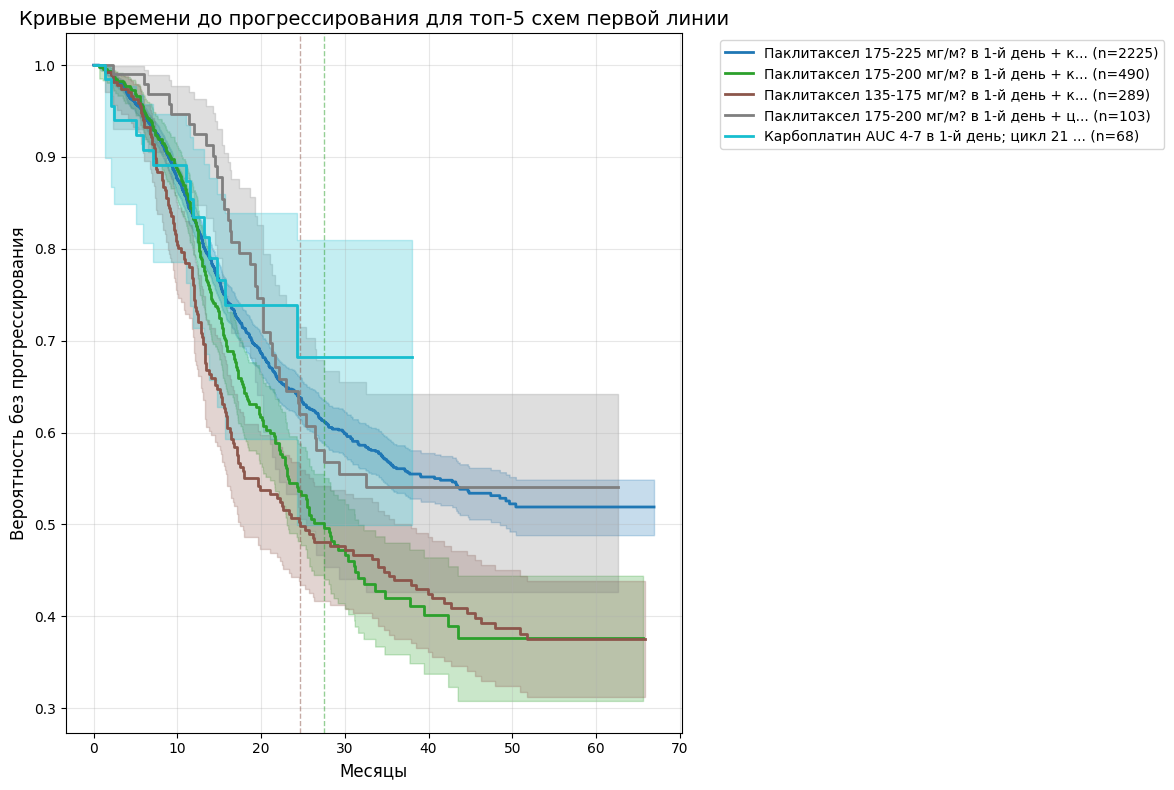


Анализ времени до прогрессирования по схемам первой линии:
                                                          Схема  N пациентов  События прогрессирования Медиана PFS (мес) % без прогрессии через 12 мес
Паклитаксел 175-225 мг/м? в 1-й день + карбоплатин AUC 5-7 в...         2225                       751     Не достигнута                         83.2%
Паклитаксел 175-200 мг/м? в 1-й день + карбоплатин AUC 5-6 в...          490                       201              27.5                         83.2%
Паклитаксел 135-175 мг/м? в 1-й день + карбоплатин AUC 5-6 в...          289                       150              24.6                         74.5%
Паклитаксел 175-200 мг/м? в 1-й день + цисплатин 60-80 мг/м?...          103                        38     Не достигнута                         92.5%
                   Карбоплатин AUC 4-7 в 1-й день; цикл 21 день           68                        15     Не достигнута                         83.5%

Log-rank тест между топ-3 схемами

In [22]:
# Анализ времени до прогрессирования по схемам лечения
def analyze_progression_free_survival(df, df_unique):
    """
    Анализ времени до прогрессирования для наиболее часто встречающихся схем
    с учетом только line_karina = 1 и karina_support_scheme = '01.'
    """

    # Фильтруем данные: только первая линия и основные схемы
    df_first_line = df[(df['line_karina'] == 1) & (df['karina_support_scheme'] == '01.')].copy()

    print(f"Всего записей с line_karina = 1: {len(df[df['line_karina'] == 1])}")
    print(f"Записей с line_karina = 1 и karina_support_scheme = '01.': {len(df_first_line)}")

    # Получаем уникальные схемы для каждого пациента (берем первую схему)
    patient_schemes = df_first_line.groupby('polis_number').agg({
        'sh_name': 'first',
        'sh_code': 'first',
        'drugs_in_scheme': 'first',
        'date_z1': 'min'  # Минимальная дата начала терапии
    }).reset_index()

    # Подсчет частоты схем
    scheme_counts = patient_schemes['sh_name'].value_counts()

    print(f"\nВсего уникальных схем первой линии: {len(scheme_counts)}")
    print("\nТоп-10 наиболее частых схем первой линии:")
    for i, (scheme, count) in enumerate(scheme_counts.head(10).items(), 1):
        print(f"{i}. {scheme[:80]}... : {count} пациентов ({count/len(patient_schemes)*100:.1f}%)")

    # Объединяем с данными о выживаемости
    df_pfs = df_unique.merge(patient_schemes[['polis_number', 'sh_name']], on='polis_number', how='inner')

    # Определяем время до прогрессирования
    # Для PFS используем дату начала второй линии как событие прогрессирования
    second_line_dates = df[df['line_karina'] == 2].groupby('polis_number')['date_z1'].min().reset_index()
    second_line_dates.columns = ['polis_number', 'progression_date']

    df_pfs = df_pfs.merge(second_line_dates, on='polis_number', how='left')

    # Расчет PFS: время от начала терапии до прогрессирования или последнего контакта
    df_pfs['pfs_event'] = df_pfs['progression_date'].notna().astype(int)
    df_pfs['pfs_date'] = df_pfs['progression_date'].fillna(df_pfs['event_date'])
    df_pfs['pfs_months'] = (df_pfs['pfs_date'] - df_pfs['date_z1']).dt.days / 30.42

    # Фильтруем только валидные значения PFS
    df_pfs = df_pfs[df_pfs['pfs_months'] >= 0]

    print(f"\nПациентов для анализа PFS: {len(df_pfs)}")
    print(f"События прогрессирования: {df_pfs['pfs_event'].sum()} ({df_pfs['pfs_event'].sum()/len(df_pfs)*100:.1f}%)")

    # Анализ PFS для топ-5 схем
    top_schemes = scheme_counts.head(5).index
    pfs_results = []

    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_schemes)))

    for i, scheme in enumerate(top_schemes):
        scheme_data = df_pfs[df_pfs['sh_name'] == scheme]

        if len(scheme_data) >= 10:  # Анализируем только схемы с достаточным количеством пациентов
            kmf = KaplanMeierFitter()
            kmf.fit(scheme_data['pfs_months'],
                   event_observed=scheme_data['pfs_event'],
                   label=f"{scheme[:40]}... (n={len(scheme_data)})")

            # Сохраняем результаты
            median_pfs = kmf.median_survival_time_
            ci = kmf.confidence_interval_survival_function_

            pfs_results.append({
                'Схема': scheme[:60] + '...' if len(scheme) > 60 else scheme,
                'N пациентов': len(scheme_data),
                'События прогрессирования': scheme_data['pfs_event'].sum(),
                'Медиана PFS (мес)': f"{median_pfs:.1f}" if median_pfs != np.inf else 'Не достигнута',
                '% без прогрессии через 12 мес': f"{kmf.predict(12):.1%}" if 12 <= scheme_data['pfs_months'].max() else 'Н/Д'
            })

            # График
            kmf.plot_survival_function(color=colors[i], linewidth=2)

            # Добавляем медиану на график
            if median_pfs != np.inf and median_pfs < scheme_data['pfs_months'].max():
                plt.axvline(x=median_pfs, color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

    plt.title('Кривые времени до прогрессирования для топ-5 схем первой линии', fontsize=14)
    plt.xlabel('Месяцы', fontsize=12)
    plt.ylabel('Вероятность без прогрессирования', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pfs_by_schemes.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Таблица результатов
    pfs_df = pd.DataFrame(pfs_results)
    print("\nАнализ времени до прогрессирования по схемам первой линии:")
    print(pfs_df.to_string(index=False))

    # Log-rank тест между топ-3 схемами
    if len(top_schemes) >= 3:
        print("\nLog-rank тест между топ-3 схемами:")
        for i in range(3):
            for j in range(i+1, min(3, len(top_schemes))):
                scheme1_data = df_pfs[df_pfs['sh_name'] == top_schemes[i]]
                scheme2_data = df_pfs[df_pfs['sh_name'] == top_schemes[j]]

                if len(scheme1_data) >= 10 and len(scheme2_data) >= 10:
                    result = logrank_test(
                        scheme1_data['pfs_months'], scheme2_data['pfs_months'],
                        event_observed_A=scheme1_data['pfs_event'],
                        event_observed_B=scheme2_data['pfs_event']
                    )
                    print(f"{top_schemes[i][:30]}... vs {top_schemes[j][:30]}...: p = {result.p_value:.4f}")

    # Общая медиана PFS
    kmf_total = KaplanMeierFitter()
    kmf_total.fit(df_pfs['pfs_months'], event_observed=df_pfs['pfs_event'])

    print(f"\nОбщая медиана времени до прогрессирования: {kmf_total.median_survival_time_:.1f} месяцев"
          if kmf_total.median_survival_time_ != np.inf else "\nОбщая медиана времени до прогрессирования: Не достигнута")

    return df_pfs, pfs_df

# Вызов функции
df_pfs, pfs_results = analyze_progression_free_survival(df, df_unique)

In [23]:
# # Сравнительный анализ OS и PFS
# def compare_os_pfs(df_unique, df_pfs):
#     """
#     Сравнение общей выживаемости (OS) и времени до прогрессирования (PFS)
#     """
#     # Объединяем данные для пациентов, у которых есть и OS и PFS
#     df_compare = df_pfs[['polis_number', 'pfs_months', 'pfs_event']].merge(
#         df_unique[['polis_number', 'survival_months', 'is_alive']],
#         on='polis_number',
#         how='inner'
#     )
#
#     print(f"Пациентов для сравнения OS и PFS: {len(df_compare)}")
#
#     # График сравнения OS и PFS
#     plt.figure(figsize=(10, 6))
#
#     # PFS
#     kmf_pfs = KaplanMeierFitter()
#     kmf_pfs.fit(df_compare['pfs_months'],
#                 event_observed=df_compare['pfs_event'],
#                 label='PFS (время до прогрессирования)')
#     kmf_pfs.plot_survival_function(color='blue', linewidth=2)
#
#     # OS
#     kmf_os = KaplanMeierFitter()
#     kmf_os.fit(df_compare['survival_months'],
#                event_observed=(df_compare['is_alive'] == 0),
#                label='OS (общая выживаемость)')
#     kmf_os.plot_survival_function(color='red', linewidth=2)
#
#     # Добавляем медианы
#     median_pfs = kmf_pfs.median_survival_time_
#     median_os = kmf_os.median_survival_time_
#
#     if median_pfs != np.inf:
#         plt.axvline(x=median_pfs, color='blue', linestyle='--', alpha=0.5,
#                    label=f'Медиана PFS: {median_pfs:.1f} мес')
#
#     if median_os != np.inf:
#         plt.axvline(x=median_os, color='red', linestyle='--', alpha=0.5,
#                    label=f'Медиана OS: {median_os:.1f} мес')
#
#     plt.title('Сравнение общей выживаемости (OS) и времени до прогрессирования (PFS)', fontsize=14)
#     plt.xlabel('Месяцы', fontsize=12)
#     plt.ylabel('Вероятность', fontsize=12)
#     plt.legend(loc='best')
#     plt.grid(True, alpha=0.3)
#     plt.xlim(0, min(60, df_compare[['pfs_months', 'survival_months']].max().max()))
#     plt.tight_layout()
#     plt.savefig('os_vs_pfs_comparison.png', dpi=300)
#     plt.show()
#
#     # Статистика
#     print("\nСравнительная статистика OS и PFS:")
#     print(f"Медиана PFS: {median_pfs:.1f} месяцев" if median_pfs != np.inf else "Медиана PFS: Не достигнута")
#     print(f"Медиана OS: {median_os:.1f} месяцев" if median_os != np.inf else "Медиана OS: Не достигнута")
#     print(f"\nСредняя разница (OS - PFS): {(df_compare['survival_months'] - df_compare['pfs_months']).mean():.1f} месяцев")
#
#     # Корреляция между PFS и OS
#     correlation = df_compare[['pfs_months', 'survival_months']].corr().iloc[0, 1]
#     print(f"Корреляция между PFS и OS: {correlation:.3f}")
#
#     return df_compare
#
# # Вызов функции
# df_comparison = compare_os_pfs(df_unique, df_pfs)

Распределение пациентов по количеству линий терапии:
1 линия(й): 2485 пациентов (47.6%)
2 линия(й): 1066 пациентов (20.4%)
3 линия(й): 517 пациентов (9.9%)
4 линия(й): 212 пациентов (4.1%)
5 линия(й): 70 пациентов (1.3%)
6 линия(й): 11 пациентов (0.2%)
7 линия(й): 10 пациентов (0.2%)
8 линия(й): 1 пациентов (0.0%)
9 линия(й): 1 пациентов (0.0%)


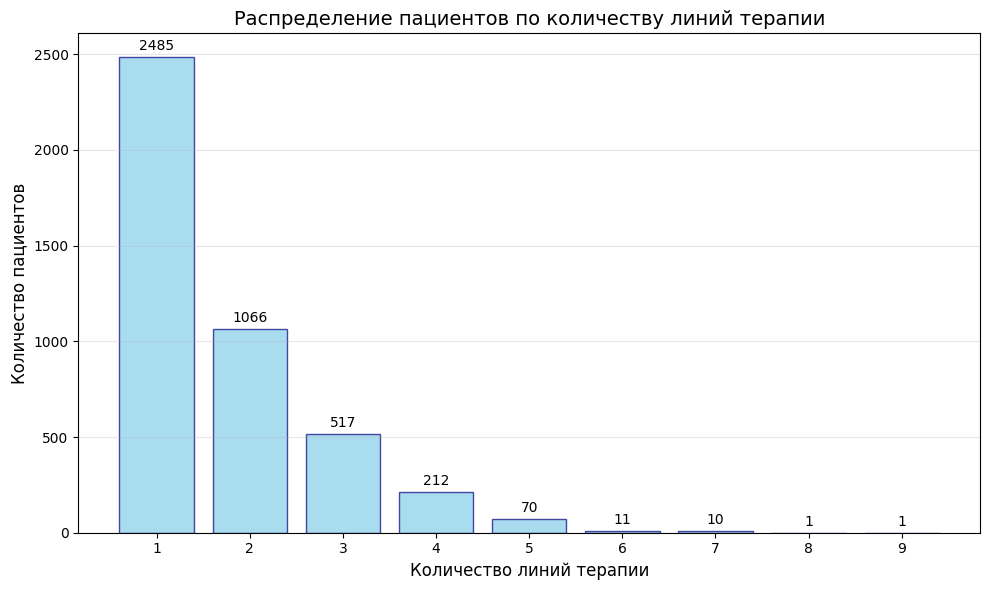

In [24]:
# Анализ по линиям терапии
def analyze_therapy_lines(df):
    """
    Анализ количества линий терапии и их влияния на выживаемость
    """
    # Подсчет максимального количества линий для каждого пациента
    max_lines = df.groupby('polis_number')['line_karina'].max().reset_index()
    max_lines.columns = ['polis_number', 'max_line']

    # Распределение по количеству линий
    line_distribution = max_lines['max_line'].value_counts().sort_index()

    print("Распределение пациентов по количеству линий терапии:")
    for line, count in line_distribution.items():
        if line > 0:  # Исключаем line_karina = 0
            print(f"{line} линия(й): {count} пациентов ({count/len(max_lines)*100:.1f}%)")

    # График распределения
    plt.figure(figsize=(10, 6))
    lines = [l for l in line_distribution.index if l > 0]
    counts = [line_distribution[l] for l in lines]

    plt.bar(lines, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.xlabel('Количество линий терапии', fontsize=12)
    plt.ylabel('Количество пациентов', fontsize=12)
    plt.title('Распределение пациентов по количеству линий терапии', fontsize=14)
    plt.xticks(lines)

    # Добавляем значения на столбцы
    for i, (line, count) in enumerate(zip(lines, counts)):
        plt.text(line, count + 20, str(count), ha='center', va='bottom')

    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('therapy_lines_distribution.png', dpi=300)
    plt.show()

    return max_lines

# Вызов функции
therapy_lines = analyze_therapy_lines(df)

Всего записей с line_karina = 1: 25822
Записей с line_karina = 1 и karina_support_scheme = '01.': 19220

Определены схемы для 3993 пациентов

Всего уникальных схем: 59

Топ-15 схем по количеству пациентов:
1. Карбоплатин + паклитаксел: 2439 пациентов
2. Бевацизумаб + карбоплатин + паклитаксел: 619 пациентов
3. Карбоплатин: 150 пациентов
4. Паклитаксел + цисплатин: 102 пациентов
5. Гемцитабин: 50 пациентов
6. Доксорубицин + карбоплатин: 49 пациентов
7. Бевацизумаб + паклитаксел + цисплатин: 42 пациентов
8. Бевацизумаб + доксорубицин: 41 пациентов
9. Гемцитабин + карбоплатин: 40 пациентов
10. Доцетаксел + карбоплатин: 35 пациентов
11. Доксорубицин + цисплатин: 31 пациентов
12. Бевацизумаб + гемцитабин: 30 пациентов
13. Бевацизумаб + гемцитабин + карбоплатин: 29 пациентов
14. Бевацизумаб + доксорубицин + карбоплатин: 28 пациентов
15. Бевацизумаб + карбоплатин: 26 пациентов

Создана таблица PFS для 3901 пациентов
События прогрессирования/смерти: 1859 (47.7%)

Схем с >= 10 пациентами: 26

Т

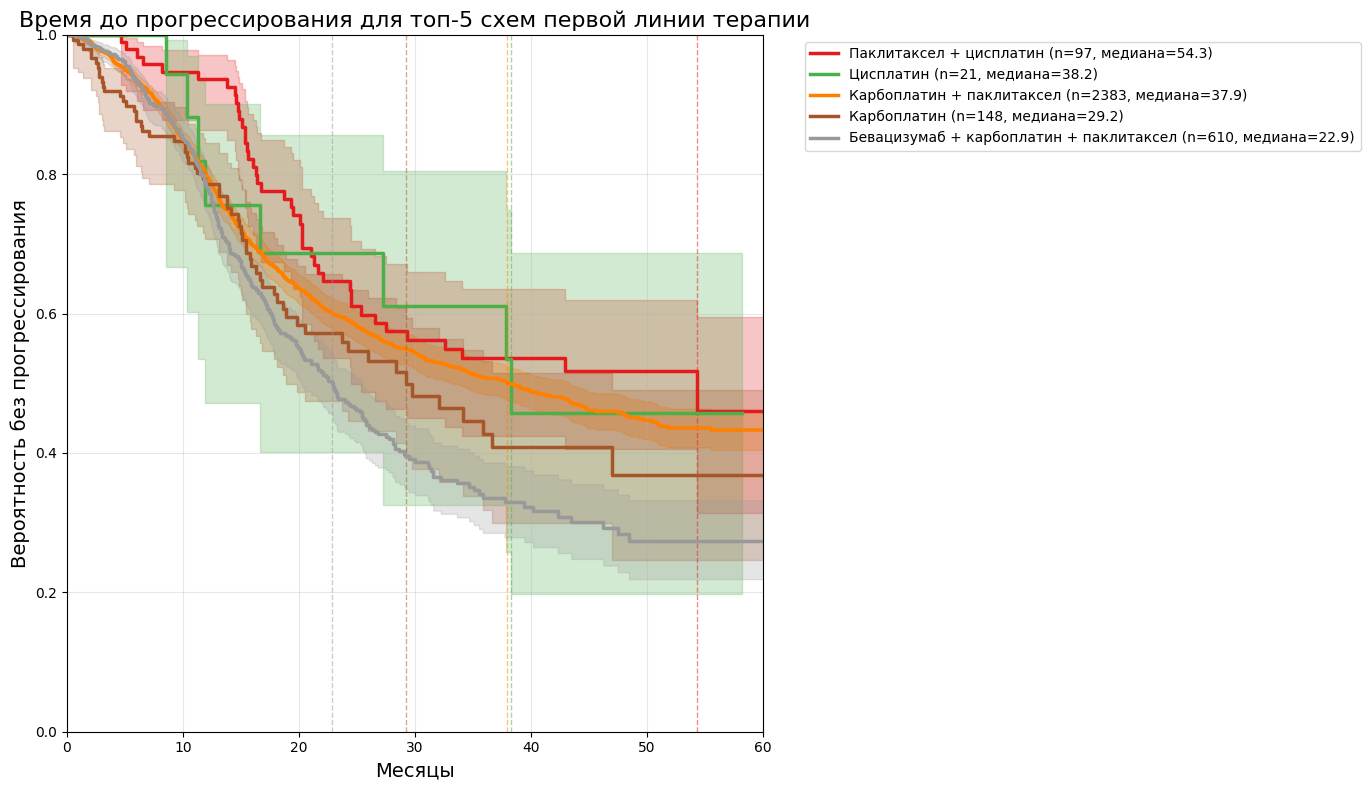


ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ ТОП-5 СХЕМ
                                  Схема  N пациентов  События (n) События (%) Медиана PFS (мес) p-value
                Паклитаксел + цисплатин           97           42        43.3              54.3       -
                              Цисплатин           21            8        38.1              38.2       -
              Карбоплатин + паклитаксел         2383         1005        42.2              37.9       -
                            Карбоплатин          148           63        42.6              29.2       -
Бевацизумаб + карбоплатин + паклитаксел          610          313        51.3              22.9       -


In [25]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def analyze_pfs_modified(df):
    """
    Анализ времени до прогрессирования с модифицированной логикой:
    - Только line_karina = 1 и karina_support_scheme = '01.'
    - Выбор наиболее частой схемы в drugs_in_scheme для каждого пациента
    - Без исключения бевацизумаба и олапариба
    """

    if df is None:
        print("Нет данных для анализа")
        return None

    # Фильтруем данные: только первая линия и основные схемы
    df_filtered = df[(df['line_karina'] == 1) & (df['karina_support_scheme'] == '01.')].copy()

    print(f"Всего записей с line_karina = 1: {len(df[df['line_karina'] == 1])}")
    print(f"Записей с line_karina = 1 и karina_support_scheme = '01.': {len(df_filtered)}")

    # Преобразование дат
    date_cols = ['date_z1', 'prr_death_date', 'last_contact_date_reestr', 'prr_last_contact']
    for col in date_cols:
        if col in df_filtered.columns:
            df_filtered[col] = pd.to_datetime(df_filtered[col], errors='coerce')

    # Определение наиболее частой схемы для каждого пациента в первой линии
    scheme_counts = df_filtered.groupby(['polis_number', 'drugs_in_scheme']).size().reset_index(name='count')

    # Для каждого пациента выбираем наиболее частую схему
    most_frequent_schemes = scheme_counts.sort_values(['polis_number', 'count'], ascending=[True, False])
    most_frequent_schemes = most_frequent_schemes.groupby('polis_number').first().reset_index()
    most_frequent_schemes = most_frequent_schemes[['polis_number', 'drugs_in_scheme']]

    print(f"\nОпределены схемы для {len(most_frequent_schemes)} пациентов")

    # Подсчет частоты схем среди пациентов
    scheme_distribution = most_frequent_schemes['drugs_in_scheme'].value_counts()
    print(f"\nВсего уникальных схем: {len(scheme_distribution)}")
    print("\nТоп-15 схем по количеству пациентов:")
    for i, (scheme, count) in enumerate(scheme_distribution.head(15).items(), 1):
        print(f"{i}. {scheme}: {count} пациентов")

    # Получаем даты начала терапии для каждого пациента
    patient_start_dates = df_filtered.groupby('polis_number')['date_z1'].min().reset_index()

    # Объединяем данные
    patient_data = most_frequent_schemes.merge(patient_start_dates, on='polis_number')

    # Определяем даты прогрессирования (начало второй линии)
    progression_dates = df[df['line_karina'] == 2].groupby('polis_number')['date_z1'].min().reset_index()
    progression_dates.columns = ['polis_number', 'progression_date']

    patient_data = patient_data.merge(progression_dates, on='polis_number', how='left')

    # Определяем даты последнего контакта или смерти
    last_info = df.groupby('polis_number').agg({
        'prr_death_date': 'last',
        'last_contact_date_reestr': 'last',
        'prr_last_contact': 'last'
    }).reset_index()

    patient_data = patient_data.merge(last_info, on='polis_number', how='left')

    # Определяем дату последнего наблюдения
    patient_data['last_observation'] = patient_data[['last_contact_date_reestr', 'prr_last_contact']].max(axis=1)

    # Расчет PFS
    pfs_data = []

    for _, row in patient_data.iterrows():
        start_date = row['date_z1']

        if pd.isna(start_date):
            continue

        # Если есть прогрессирование
        if pd.notna(row['progression_date']) and row['progression_date'] > start_date:
            duration = (row['progression_date'] - start_date).days / 30.44
            event = 1
        # Если есть смерть до прогрессирования
        elif pd.notna(row['prr_death_date']) and row['prr_death_date'] > start_date:
            duration = (row['prr_death_date'] - start_date).days / 30.44
            event = 1
        # Цензурирование
        elif pd.notna(row['last_observation']) and row['last_observation'] > start_date:
            duration = (row['last_observation'] - start_date).days / 30.44
            event = 0
        else:
            continue

        if duration > 0:
            pfs_data.append({
                'polis_number': row['polis_number'],
                'drugs_in_scheme': row['drugs_in_scheme'],
                'duration': duration,
                'event_observed': event
            })

    pfs_df = pd.DataFrame(pfs_data)
    print(f"\nСоздана таблица PFS для {len(pfs_df)} пациентов")
    print(f"События прогрессирования/смерти: {pfs_df['event_observed'].sum()} ({pfs_df['event_observed'].sum()/len(pfs_df)*100:.1f}%)")

    # Фильтрация схем с >= 10 пациентами
    scheme_patient_counts = pfs_df.groupby('drugs_in_scheme')['polis_number'].nunique()
    valid_schemes = scheme_patient_counts[scheme_patient_counts >= 10].index
    filtered_pfs = pfs_df[pfs_df['drugs_in_scheme'].isin(valid_schemes)]

    print(f"\nСхем с >= 10 пациентами: {len(valid_schemes)}")

    # Расчет медиан для каждой схемы
    medians_dict = {}
    kmf = KaplanMeierFitter()

    for scheme in valid_schemes:
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]
        kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'])
        median = kmf.median_survival_time_
        medians_dict[scheme] = {
            'median': median if median != np.inf else 999,
            'median_text': f"{median:.1f}" if median != np.inf else 'Не достигнута',
            'n_patients': scheme_patient_counts[scheme],
            'n_events': scheme_data['event_observed'].sum(),
            'pct_events': scheme_data['event_observed'].sum() / len(scheme_data) * 100
        }

    # Сортировка по медиане и выбор топ-5
    sorted_schemes = sorted(medians_dict.items(), key=lambda x: x[1]['median'], reverse=True)
    top5_schemes = [scheme for scheme, _ in sorted_schemes[:5]]

    print("\nТоп-5 схем по медиане PFS:")
    for i, (scheme, data) in enumerate(sorted_schemes[:5], 1):
        print(f"{i}. {scheme}: медиана = {data['median_text']} мес, n = {data['n_patients']}")

    # Статистический анализ с референсной схемой
    ref_scheme = 'Карбоплатин + Паклитаксел'

    # Создание таблицы результатов
    results = []

    for scheme in valid_schemes:
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]

        # Медиана и основные показатели
        result = {
            'Схема': scheme,
            'N пациентов': medians_dict[scheme]['n_patients'],
            'События (n)': medians_dict[scheme]['n_events'],
            'События (%)': f"{medians_dict[scheme]['pct_events']:.1f}",
            'Медиана PFS (мес)': medians_dict[scheme]['median_text']
        }

        # Log-rank тест против референсной схемы
        if scheme != ref_scheme and ref_scheme in valid_schemes:
            ref_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == ref_scheme]
            logrank_result = logrank_test(
                ref_data['duration'], scheme_data['duration'],
                event_observed_A=ref_data['event_observed'],
                event_observed_B=scheme_data['event_observed']
            )
            result['p-value'] = f"{logrank_result.p_value:.4f}"
        else:
            result['p-value'] = '-'

        results.append(result)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Медиана PFS (мес)',
                                        key=lambda x: x.apply(lambda v: float(v) if v != 'Не достигнута' else 999),
                                        ascending=False)

    print("\n" + "="*100)
    print("ТАБЛИЦА РЕЗУЛЬТАТОВ PFS ДЛЯ ВСЕХ СХЕМ С >= 10 ПАЦИЕНТАМИ")
    print("="*100)
    print(results_df.to_string(index=False))

    # График Kaplan-Meier для топ-5 схем
    plt.figure(figsize=(14, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, 5))

    for i, scheme in enumerate(top5_schemes):
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]
        kmf.fit(scheme_data['duration'],
                event_observed=scheme_data['event_observed'],
                label=f"{scheme} (n={medians_dict[scheme]['n_patients']}, медиана={medians_dict[scheme]['median_text']})")
        kmf.plot_survival_function(color=colors[i], linewidth=2.5)

        # Добавляем линию медианы
        if medians_dict[scheme]['median'] != 999:
            plt.axvline(x=medians_dict[scheme]['median'],
                       color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

    plt.title('Время до прогрессирования для топ-5 схем первой линии терапии', fontsize=16)
    plt.xlabel('Месяцы', fontsize=14)
    plt.ylabel('Вероятность без прогрессирования', fontsize=14)
    plt.xlim(0, 60)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig('pfs_top5_schemes.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Cox PH анализ
    if ref_scheme in valid_schemes and len(valid_schemes) > 1:
        print(f"\n\nCox Proportional Hazards анализ (референс: {ref_scheme}):")

        # Подготовка данных для Cox
        cox_data = filtered_pfs.copy()
        cox_data['scheme_cat'] = pd.Categorical(cox_data['drugs_in_scheme'],
                                                categories=[ref_scheme] + [s for s in valid_schemes if s != ref_scheme])

        cph = CoxPHFitter()
        cph.fit(cox_data[['duration', 'event_observed', 'scheme_cat']],
                duration_col='duration',
                event_col='event_observed')

        hr_summary = cph.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
        hr_summary.columns = ['HR', 'HR_lower_95%', 'HR_upper_95%', 'p_value']

        print("\nHazard Ratios относительно " + ref_scheme + ":")
        print(hr_summary)

    # Сохранение результатов топ-5
    top5_results = results_df[results_df['Схема'].isin(top5_schemes)]
    print("\n" + "="*80)
    print("ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ ТОП-5 СХЕМ")
    print("="*80)
    print(top5_results.to_string(index=False))

    return pfs_df, results_df

# Запуск анализа
if df is not None:
    pfs_results, results_table = analyze_pfs_modified(df)
else:
    print("DataFrame 'df' не найден")

Всего записей с line_karina = 1: 25822
Записей с line_karina = 1 и karina_support_scheme = '01.': 19220

Определены схемы для 3993 пациентов

Создана таблица PFS для 3901 пациентов
События прогрессирования/смерти: 1859 (47.7%)

Схем с >= 10 пациентами: 26

ТАБЛИЦА РЕЗУЛЬТАТОВ PFS ДЛЯ ВСЕХ СХЕМ С >= 10 ПАЦИЕНТАМИ
                                   Схема  N пациентов  События (n) События (%) Медиана PFS (мес)  p-value p-value (научная нотация)
                 Паклитаксел + цисплатин           97           42        43.3              54.3   0.1478                  1.48e-01
                               Цисплатин           21            8        38.1              38.2   0.7424                  7.42e-01
               Карбоплатин + паклитаксел         2383         1005        42.2              37.9 Референс                  Референс
                             Карбоплатин          148           63        42.6              29.2   0.2272                  2.27e-01
 Бевацизумаб + карбоплатин

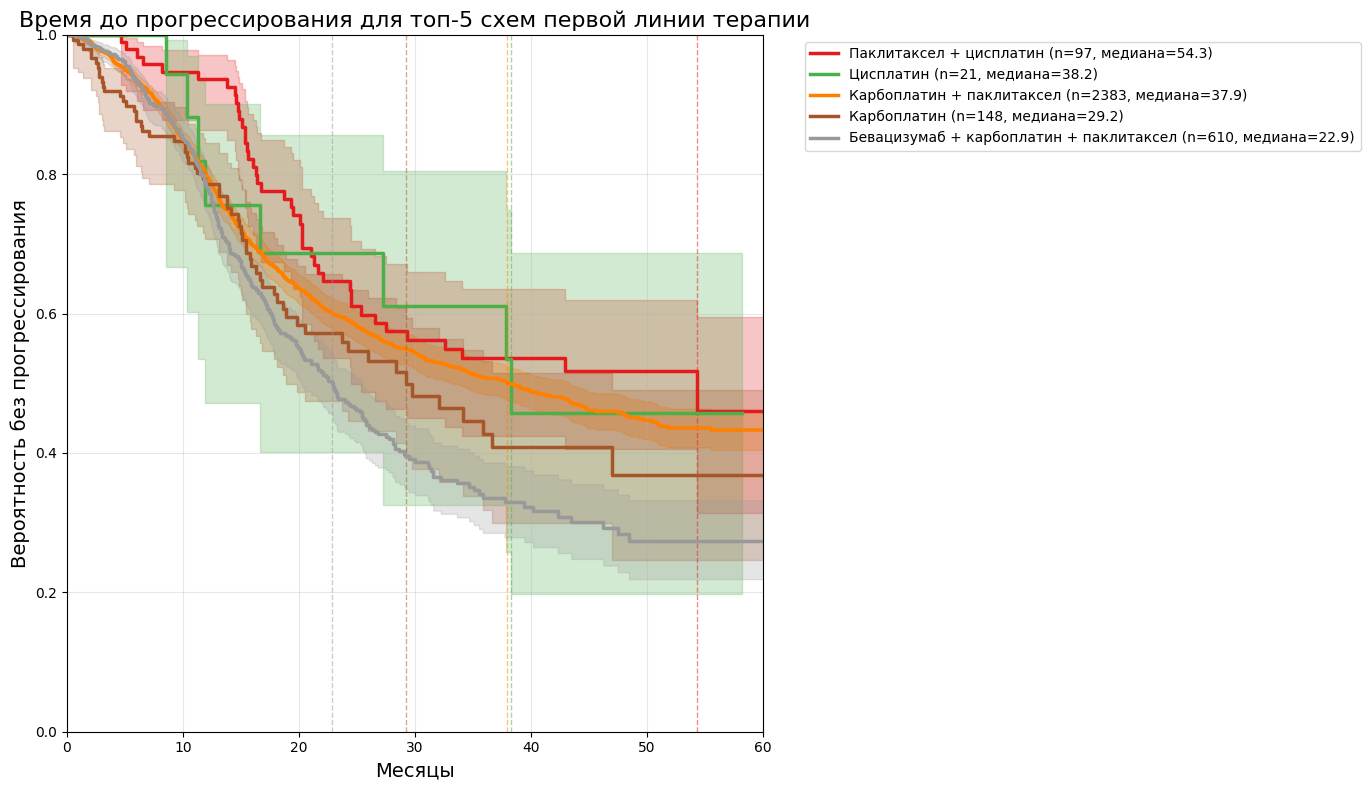

In [26]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def analyze_pfs_modified(df):
    """
    Анализ времени до прогрессирования с исправленным расчетом p-values
    """

    if df is None:
        print("Нет данных для анализа")
        return None

    # Фильтруем данные: только первая линия и основные схемы
    df_filtered = df[(df['line_karina'] == 1) & (df['karina_support_scheme'] == '01.')].copy()

    print(f"Всего записей с line_karina = 1: {len(df[df['line_karina'] == 1])}")
    print(f"Записей с line_karina = 1 и karina_support_scheme = '01.': {len(df_filtered)}")

    # Преобразование дат
    date_cols = ['date_z1', 'prr_death_date', 'last_contact_date_reestr', 'prr_last_contact']
    for col in date_cols:
        if col in df_filtered.columns:
            df_filtered[col] = pd.to_datetime(df_filtered[col], errors='coerce')

    # Определение наиболее частой схемы для каждого пациента в первой линии
    scheme_counts = df_filtered.groupby(['polis_number', 'drugs_in_scheme']).size().reset_index(name='count')

    # Для каждого пациента выбираем наиболее частую схему
    most_frequent_schemes = scheme_counts.sort_values(['polis_number', 'count'], ascending=[True, False])
    most_frequent_schemes = most_frequent_schemes.groupby('polis_number').first().reset_index()
    most_frequent_schemes = most_frequent_schemes[['polis_number', 'drugs_in_scheme']]

    print(f"\nОпределены схемы для {len(most_frequent_schemes)} пациентов")

    # Получаем даты начала терапии для каждого пациента
    patient_start_dates = df_filtered.groupby('polis_number')['date_z1'].min().reset_index()

    # Объединяем данные
    patient_data = most_frequent_schemes.merge(patient_start_dates, on='polis_number')

    # Определяем даты прогрессирования (начало второй линии)
    progression_dates = df[df['line_karina'] == 2].groupby('polis_number')['date_z1'].min().reset_index()
    progression_dates.columns = ['polis_number', 'progression_date']

    patient_data = patient_data.merge(progression_dates, on='polis_number', how='left')

    # Определяем даты последнего контакта или смерти
    last_info = df.groupby('polis_number').agg({
        'prr_death_date': 'last',
        'last_contact_date_reestr': 'last',
        'prr_last_contact': 'last'
    }).reset_index()

    patient_data = patient_data.merge(last_info, on='polis_number', how='left')

    # Определяем дату последнего наблюдения
    patient_data['last_observation'] = patient_data[['last_contact_date_reestr', 'prr_last_contact']].max(axis=1)

    # Расчет PFS
    pfs_data = []

    for _, row in patient_data.iterrows():
        start_date = row['date_z1']

        if pd.isna(start_date):
            continue

        # Если есть прогрессирование
        if pd.notna(row['progression_date']) and row['progression_date'] > start_date:
            duration = (row['progression_date'] - start_date).days / 30.44
            event = 1
        # Если есть смерть до прогрессирования
        elif pd.notna(row['prr_death_date']) and row['prr_death_date'] > start_date:
            duration = (row['prr_death_date'] - start_date).days / 30.44
            event = 1
        # Цензурирование
        elif pd.notna(row['last_observation']) and row['last_observation'] > start_date:
            duration = (row['last_observation'] - start_date).days / 30.44
            event = 0
        else:
            continue

        if duration > 0:
            pfs_data.append({
                'polis_number': row['polis_number'],
                'drugs_in_scheme': row['drugs_in_scheme'],
                'duration': duration,
                'event_observed': event
            })

    pfs_df = pd.DataFrame(pfs_data)
    print(f"\nСоздана таблица PFS для {len(pfs_df)} пациентов")
    print(f"События прогрессирования/смерти: {pfs_df['event_observed'].sum()} ({pfs_df['event_observed'].sum()/len(pfs_df)*100:.1f}%)")

    # Фильтрация схем с >= 10 пациентами
    scheme_patient_counts = pfs_df.groupby('drugs_in_scheme')['polis_number'].nunique()
    valid_schemes = scheme_patient_counts[scheme_patient_counts >= 10].index
    filtered_pfs = pfs_df[pfs_df['drugs_in_scheme'].isin(valid_schemes)]

    print(f"\nСхем с >= 10 пациентами: {len(valid_schemes)}")

    # Расчет медиан для каждой схемы
    medians_dict = {}
    kmf = KaplanMeierFitter()

    for scheme in valid_schemes:
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]
        kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'])
        median = kmf.median_survival_time_
        medians_dict[scheme] = {
            'median': median if median != np.inf else 999,
            'median_text': f"{median:.1f}" if median != np.inf else 'Не достигнута',
            'n_patients': scheme_patient_counts[scheme],
            'n_events': scheme_data['event_observed'].sum(),
            'pct_events': scheme_data['event_observed'].sum() / len(scheme_data) * 100
        }

    # Сортировка по медиане и выбор топ-5
    sorted_schemes = sorted(medians_dict.items(), key=lambda x: x[1]['median'], reverse=True)
    top5_schemes = [scheme for scheme, _ in sorted_schemes[:5]]

    # Референсная схема - проверяем разные варианты написания
    ref_scheme = None
    ref_variants = ['Карбоплатин + паклитаксел', 'Карбоплатин + Паклитаксел', 'карбоплатин + паклитаксел']

    for variant in ref_variants:
        if variant in valid_schemes:
            ref_scheme = variant
            break

    if ref_scheme is None:
        print("\nВНИМАНИЕ: Референсная схема 'Карбоплатин + паклитаксел' не найдена!")
        print("Доступные схемы с карбоплатином и паклитакселом:")
        for scheme in valid_schemes:
            if 'карбоплатин' in scheme.lower() and 'паклитаксел' in scheme.lower():
                print(f"  - {scheme}")

    # Создание таблицы результатов
    results = []

    for scheme in valid_schemes:
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]

        # Медиана и основные показатели
        result = {
            'Схема': scheme,
            'N пациентов': medians_dict[scheme]['n_patients'],
            'События (n)': medians_dict[scheme]['n_events'],
            'События (%)': f"{medians_dict[scheme]['pct_events']:.1f}",
            'Медиана PFS (мес)': medians_dict[scheme]['median_text']
        }

        # Log-rank тест против референсной схемы
        if ref_scheme and scheme != ref_scheme:
            ref_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == ref_scheme]
            try:
                logrank_result = logrank_test(
                    ref_data['duration'],
                    scheme_data['duration'],
                    event_observed_A=ref_data['event_observed'],
                    event_observed_B=scheme_data['event_observed']
                )
                result['p-value'] = f"{logrank_result.p_value:.4f}"
                result['p-value (научная нотация)'] = f"{logrank_result.p_value:.2e}"
            except Exception as e:
                print(f"Ошибка при расчете p-value для {scheme}: {e}")
                result['p-value'] = 'Ошибка'
                result['p-value (научная нотация)'] = 'Ошибка'
        else:
            result['p-value'] = 'Референс' if scheme == ref_scheme else '-'
            result['p-value (научная нотация)'] = 'Референс' if scheme == ref_scheme else '-'

        results.append(result)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Медиана PFS (мес)',
                                        key=lambda x: x.apply(lambda v: float(v) if v != 'Не достигнута' else 999),
                                        ascending=False)

    print("\n" + "="*120)
    print("ТАБЛИЦА РЕЗУЛЬТАТОВ PFS ДЛЯ ВСЕХ СХЕМ С >= 10 ПАЦИЕНТАМИ")
    print("="*120)
    print(results_df.to_string(index=False))

    # Отдельная таблица для топ-5
    top5_results = results_df[results_df['Схема'].isin(top5_schemes)]
    print("\n" + "="*100)
    print("ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ ТОП-5 СХЕМ")
    print("="*100)
    print(top5_results[['Схема', 'N пациентов', 'События (n)', 'События (%)',
                       'Медиана PFS (мес)', 'p-value']].to_string(index=False))

    # Парные сравнения между топ-5 схемами
    print("\n" + "="*80)
    print("ПАРНЫЕ СРАВНЕНИЯ МЕЖДУ ТОП-5 СХЕМАМИ (log-rank test)")
    print("="*80)

    comparison_results = []
    for i, scheme1 in enumerate(top5_schemes):
        for j, scheme2 in enumerate(top5_schemes[i+1:], i+1):
            data1 = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme1]
            data2 = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme2]

            try:
                logrank_result = logrank_test(
                    data1['duration'],
                    data2['duration'],
                    event_observed_A=data1['event_observed'],
                    event_observed_B=data2['event_observed']
                )
                comparison_results.append({
                    'Схема 1': scheme1[:40] + '...' if len(scheme1) > 40 else scheme1,
                    'Схема 2': scheme2[:40] + '...' if len(scheme2) > 40 else scheme2,
                    'p-value': f"{logrank_result.p_value:.4f}",
                    'Значимость': 'Да' if logrank_result.p_value < 0.05 else 'Нет'
                })
            except Exception as e:
                print(f"Ошибка при сравнении {scheme1} vs {scheme2}: {e}")

    if comparison_results:
        comparison_df = pd.DataFrame(comparison_results)
        print(comparison_df.to_string(index=False))

    # График Kaplan-Meier для топ-5 схем
    plt.figure(figsize=(14, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, 5))

    for i, scheme in enumerate(top5_schemes):
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]
        kmf.fit(scheme_data['duration'],
                event_observed=scheme_data['event_observed'],
                label=f"{scheme} (n={medians_dict[scheme]['n_patients']}, медиана={medians_dict[scheme]['median_text']})")
        kmf.plot_survival_function(color=colors[i], linewidth=2.5)

        # Добавляем линию медианы
        if medians_dict[scheme]['median'] != 999:
            plt.axvline(x=medians_dict[scheme]['median'],
                       color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

    plt.title('Время до прогрессирования для топ-5 схем первой линии терапии', fontsize=16)
    plt.xlabel('Месяцы', fontsize=14)
    plt.ylabel('Вероятность без прогрессирования', fontsize=14)
    plt.xlim(0, 60)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig('pfs_top5_schemes_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

    return pfs_df, results_df

# Запуск анализа
if df is not None:
    pfs_results, results_table = analyze_pfs_modified(df)
else:
    print("DataFrame 'df' не найден")

Определение стадий заболевания...

Все уникальные значения prr_stage:
prr_stage
Unknown    18523
3C         11703
4           6321
3           3533
3B          1741
1C          1526
2B          1438
3A          1288
1A           968
2            869
2C           847
2A           795
1            611
4B           438
1B           296
4A           207
3A2          147
0             76
4C            67
3A1           47
Name: count, dtype: int64

Преобразование стадий:
  1 -> I
  1A -> I
  1B -> I
  1C -> I
  2 -> II
  2A -> II
  2B -> II
  2C -> II
  3 -> III
  3A -> III
  3A1 -> III
  3A2 -> III
  3B -> III
  3C -> III
  3C2 -> III
  4 -> IV
  4A -> IV
  4B -> IV
  4C -> IV

Всего пациентов в базе: 5222
Пациентов со стадиями III или IV: 2143

Распределение по укрупненным стадиям:
  Стадия I: 509 пациентов (9.7%)
  Стадия II: 456 пациентов (8.7%)
  Стадия III: 1565 пациентов (30.0%)
  Стадия IV: 578 пациентов (11.1%)

Детальное распределение для стадий III-IV:
  3C (→III): 966 пациентов
 

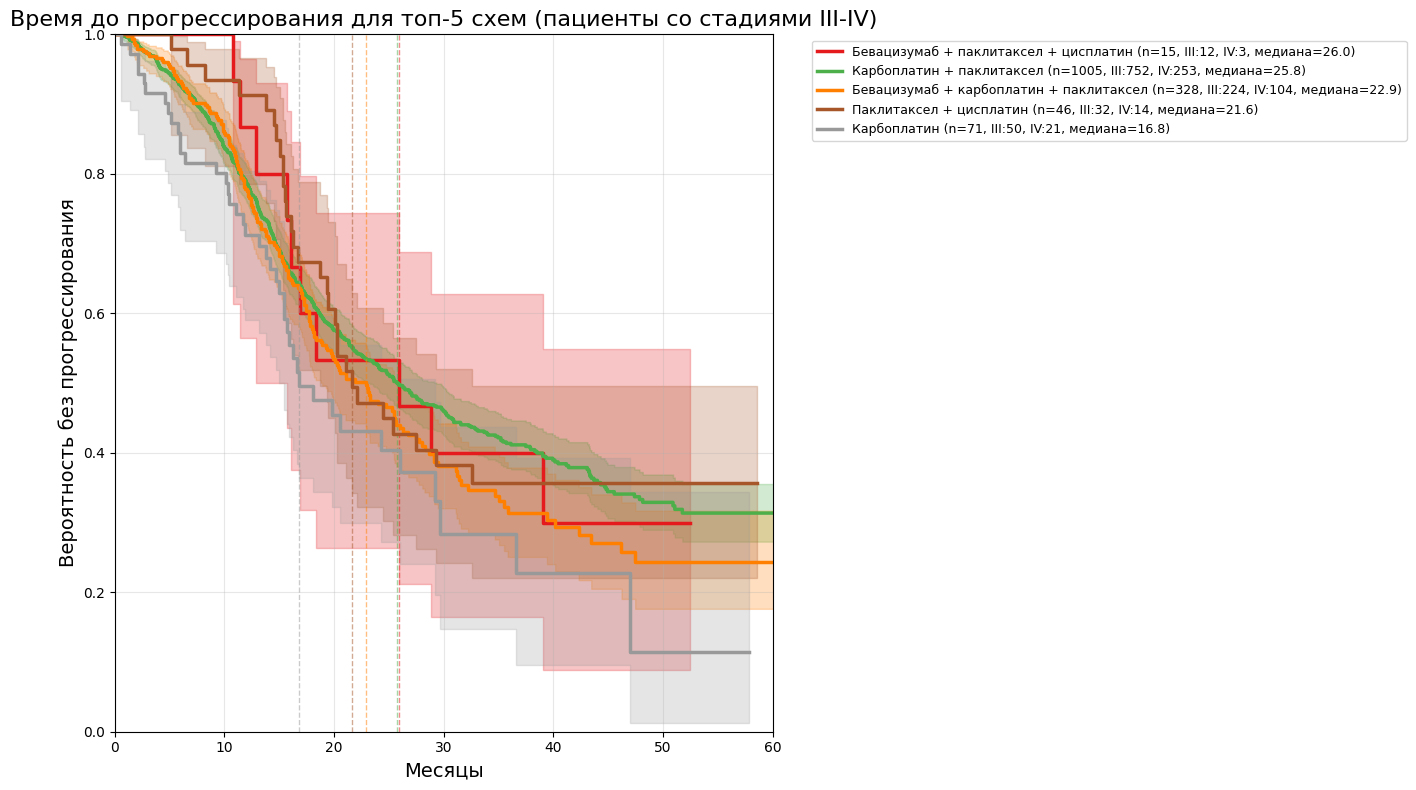

In [27]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def analyze_pfs_stage_III_IV(df):
    """
    Анализ времени до прогрессирования для пациентов со стадиями III и IV
    с правильной группировкой стадий
    """

    if df is None:
        print("Нет данных для анализа")
        return None

    # Функция для упрощения стадий с учетом всех вариантов
    def simplify_stage(stage):
        if pd.isna(stage) or str(stage) in ['0', 'Unknown']:
            return np.nan

        stage_str = str(stage).upper().strip()

        # Стадия I и все подстадии
        if stage_str in ['1', '1A', '1B', '1C']:
            return 'I'
        # Стадия II и все подстадии
        elif stage_str in ['2', '2A', '2B', '2C']:
            return 'II'
        # Стадия III и все подстадии
        elif stage_str in ['3', '3A', '3A1', '3A2', '3B', '3C', '3C2']:
            return 'III'
        # Стадия IV и все подстадии
        elif stage_str in ['4', '4A', '4B', '4C']:
            return 'IV'
        else:
            return np.nan

    print("Определение стадий заболевания...")

    # Проверяем распределение исходных стадий
    all_stages_prr = df['prr_stage'].value_counts()
    all_stages_reestr = df['stage_reestr'].value_counts()

    print("\nВсе уникальные значения prr_stage:")
    print(all_stages_prr.head(20))

    # Создаем словарь со стадиями для каждого пациента
    patient_stages = df.groupby('polis_number').agg({
        'prr_stage': lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan,
        'stage_reestr': lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan
    }).reset_index()

    # Выбираем стадию (приоритет prr_stage)
    patient_stages['stage'] = patient_stages['prr_stage'].where(
        patient_stages['prr_stage'].notna(),
        patient_stages['stage_reestr']
    )

    # Упрощаем стадии
    patient_stages['stage_simplified'] = patient_stages['stage'].apply(simplify_stage)

    # Показываем статистику по группировке
    print("\nПреобразование стадий:")
    stage_mapping = patient_stages[['stage', 'stage_simplified']].dropna()
    for original, simplified in stage_mapping.drop_duplicates().sort_values('stage').values:
        if pd.notna(simplified):
            print(f"  {original} -> {simplified}")

    # Фильтруем только III и IV стадии
    patients_III_IV = patient_stages[patient_stages['stage_simplified'].isin(['III', 'IV'])]['polis_number'].unique()

    print(f"\nВсего пациентов в базе: {len(patient_stages)}")
    print(f"Пациентов со стадиями III или IV: {len(patients_III_IV)}")

    # Распределение по стадиям
    stage_distribution = patient_stages['stage_simplified'].value_counts().sort_index()
    print("\nРаспределение по укрупненным стадиям:")
    for stage, count in stage_distribution.items():
        print(f"  Стадия {stage}: {count} пациентов ({count/len(patient_stages)*100:.1f}%)")

    # Детальное распределение для III и IV стадий
    stage_III_IV_detail = patient_stages[patient_stages['stage_simplified'].isin(['III', 'IV'])]
    print("\nДетальное распределение для стадий III-IV:")
    detail_dist = stage_III_IV_detail['stage'].value_counts()
    for stage, count in detail_dist.items():
        simplified = simplify_stage(stage)
        print(f"  {stage} (→{simplified}): {count} пациентов")

    # Теперь фильтруем основные данные
    df_stage_filtered = df[df['polis_number'].isin(patients_III_IV)].copy()

    # Применяем логику анализа PFS
    df_filtered = df_stage_filtered[(df_stage_filtered['line_karina'] == 1) &
                                    (df_stage_filtered['karina_support_scheme'] == '01.')].copy()

    print(f"\nДля пациентов со стадиями III-IV:")
    print(f"Записей с line_karina = 1 и karina_support_scheme = '01.': {len(df_filtered)}")

    # Преобразование дат
    date_cols = ['date_z1', 'prr_death_date', 'last_contact_date_reestr', 'prr_last_contact']
    for col in date_cols:
        if col in df_filtered.columns:
            df_filtered[col] = pd.to_datetime(df_filtered[col], errors='coerce')

    # Определение наиболее частой схемы для каждого пациента
    scheme_counts = df_filtered.groupby(['polis_number', 'drugs_in_scheme']).size().reset_index(name='count')
    most_frequent_schemes = scheme_counts.sort_values(['polis_number', 'count'], ascending=[True, False])
    most_frequent_schemes = most_frequent_schemes.groupby('polis_number').first().reset_index()
    most_frequent_schemes = most_frequent_schemes[['polis_number', 'drugs_in_scheme']]

    # Добавляем информацию о стадии
    most_frequent_schemes = most_frequent_schemes.merge(
        patient_stages[['polis_number', 'stage_simplified']],
        on='polis_number',
        how='left'
    )

    print(f"\nОпределены схемы для {len(most_frequent_schemes)} пациентов со стадиями III-IV")

    # Получаем даты начала терапии
    patient_start_dates = df_filtered.groupby('polis_number')['date_z1'].min().reset_index()
    patient_data = most_frequent_schemes.merge(patient_start_dates, on='polis_number')

    # Определяем даты прогрессирования
    progression_dates = df_stage_filtered[df_stage_filtered['line_karina'] == 2].groupby('polis_number')['date_z1'].min().reset_index()
    progression_dates.columns = ['polis_number', 'progression_date']
    patient_data = patient_data.merge(progression_dates, on='polis_number', how='left')

    # Даты последнего контакта или смерти
    last_info = df_stage_filtered.groupby('polis_number').agg({
        'prr_death_date': 'last',
        'last_contact_date_reestr': 'last',
        'prr_last_contact': 'last'
    }).reset_index()

    patient_data = patient_data.merge(last_info, on='polis_number', how='left')
    patient_data['last_observation'] = patient_data[['last_contact_date_reestr', 'prr_last_contact']].max(axis=1)

    # Расчет PFS
    pfs_data = []

    for _, row in patient_data.iterrows():
        start_date = row['date_z1']

        if pd.isna(start_date):
            continue

        if pd.notna(row['progression_date']) and row['progression_date'] > start_date:
            duration = (row['progression_date'] - start_date).days / 30.44
            event = 1
        elif pd.notna(row['prr_death_date']) and row['prr_death_date'] > start_date:
            duration = (row['prr_death_date'] - start_date).days / 30.44
            event = 1
        elif pd.notna(row['last_observation']) and row['last_observation'] > start_date:
            duration = (row['last_observation'] - start_date).days / 30.44
            event = 0
        else:
            continue

        if duration > 0:
            pfs_data.append({
                'polis_number': row['polis_number'],
                'drugs_in_scheme': row['drugs_in_scheme'],
                'stage_simplified': row['stage_simplified'],
                'duration': duration,
                'event_observed': event
            })

    pfs_df = pd.DataFrame(pfs_data)
    print(f"\nСоздана таблица PFS для {len(pfs_df)} пациентов со стадиями III-IV")
    print(f"События: {pfs_df['event_observed'].sum()} ({pfs_df['event_observed'].sum()/len(pfs_df)*100:.1f}%)")

    # Разбивка по стадиям в PFS анализе
    print("\nРаспределение в анализе PFS:")
    for stage in ['III', 'IV']:
        stage_count = len(pfs_df[pfs_df['stage_simplified'] == stage])
        stage_events = pfs_df[pfs_df['stage_simplified'] == stage]['event_observed'].sum()
        print(f"  Стадия {stage}: {stage_count} пациентов, {stage_events} событий ({stage_events/stage_count*100:.1f}%)")

    # Фильтрация схем с >= 10 пациентами
    scheme_patient_counts = pfs_df.groupby('drugs_in_scheme')['polis_number'].nunique()
    valid_schemes = scheme_patient_counts[scheme_patient_counts >= 10].index
    filtered_pfs = pfs_df[pfs_df['drugs_in_scheme'].isin(valid_schemes)]

    print(f"\nСхем с >= 10 пациентами: {len(valid_schemes)}")

    # Расчет медиан
    medians_dict = {}
    kmf = KaplanMeierFitter()

    for scheme in valid_schemes:
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]
        kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'])
        median = kmf.median_survival_time_

        # Расчет по стадиям
        stage_III_data = scheme_data[scheme_data['stage_simplified'] == 'III']
        stage_IV_data = scheme_data[scheme_data['stage_simplified'] == 'IV']

        medians_dict[scheme] = {
            'median': median if median != np.inf else 999,
            'median_text': f"{median:.1f}" if median != np.inf else 'Не достигнута',
            'n_patients': scheme_patient_counts[scheme],
            'n_stage_III': len(stage_III_data),
            'n_stage_IV': len(stage_IV_data),
            'n_events': scheme_data['event_observed'].sum(),
            'pct_events': scheme_data['event_observed'].sum() / len(scheme_data) * 100
        }

    # Сортировка и выбор топ-5
    sorted_schemes = sorted(medians_dict.items(), key=lambda x: x[1]['median'], reverse=True)
    top5_schemes = [scheme for scheme, _ in sorted_schemes[:5]]

    # Референсная схема
    ref_scheme = None
    ref_variants = ['Карбоплатин + паклитаксел', 'Карбоплатин + Паклитаксел', 'карбоплатин + паклитаксел']
    for variant in ref_variants:
        if variant in valid_schemes:
            ref_scheme = variant
            break

    # Создание таблицы результатов
    results = []

    for scheme in valid_schemes:
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]

        result = {
            'Схема': scheme,
            'N всего': medians_dict[scheme]['n_patients'],
            'Стадия III (n)': medians_dict[scheme]['n_stage_III'],
            'Стадия IV (n)': medians_dict[scheme]['n_stage_IV'],
            'События (n)': medians_dict[scheme]['n_events'],
            'События (%)': f"{medians_dict[scheme]['pct_events']:.1f}",
            'Медиана PFS (мес)': medians_dict[scheme]['median_text']
        }

        # p-value относительно референса
        if ref_scheme and scheme != ref_scheme:
            ref_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == ref_scheme]
            try:
                logrank_result = logrank_test(
                    ref_data['duration'],
                    scheme_data['duration'],
                    event_observed_A=ref_data['event_observed'],
                    event_observed_B=scheme_data['event_observed']
                )
                result['p-value'] = f"{logrank_result.p_value:.4f}"
            except:
                result['p-value'] = 'Ошибка'
        else:
            result['p-value'] = 'Референс' if scheme == ref_scheme else '-'

        results.append(result)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Медиана PFS (мес)',
                                        key=lambda x: x.apply(lambda v: float(v) if v != 'Не достигнута' else 999),
                                        ascending=False)

    # Вывод результатов
    print("\n" + "="*120)
    print("РЕЗУЛЬТАТЫ PFS ДЛЯ ПАЦИЕНТОВ СО СТАДИЯМИ III-IV")
    print("="*120)
    print(results_df.head(10).to_string(index=False))

    # Топ-5 результаты
    top5_results = results_df[results_df['Схема'].isin(top5_schemes)]
    print("\n" + "="*100)
    print("ТОП-5 СХЕМ ПО МЕДИАНЕ PFS (СТАДИИ III-IV)")
    print("="*100)
    print(top5_results.to_string(index=False))

    # График для топ-5
    plt.figure(figsize=(14, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, 5))

    for i, scheme in enumerate(top5_schemes):
        scheme_data = filtered_pfs[filtered_pfs['drugs_in_scheme'] == scheme]
        n_III = medians_dict[scheme]['n_stage_III']
        n_IV = medians_dict[scheme]['n_stage_IV']

        kmf.fit(scheme_data['duration'],
                event_observed=scheme_data['event_observed'],
                label=f"{scheme} (n={medians_dict[scheme]['n_patients']}, III:{n_III}, IV:{n_IV}, медиана={medians_dict[scheme]['median_text']})")
        kmf.plot_survival_function(color=colors[i], linewidth=2.5)

        if medians_dict[scheme]['median'] != 999:
            plt.axvline(x=medians_dict[scheme]['median'],
                       color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

    plt.title('Время до прогрессирования для топ-5 схем (пациенты со стадиями III-IV)', fontsize=16)
    plt.xlabel('Месяцы', fontsize=14)
    plt.ylabel('Вероятность без прогрессирования', fontsize=14)
    plt.xlim(0, 60)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.savefig('pfs_top5_stage_III_IV.png', dpi=300, bbox_inches='tight')
    plt.show()

    return pfs_df, results_df

# Запуск анализа
if df is not None:
    pfs_stage_results, results_stage_table = analyze_pfs_stage_III_IV(df)
else:
    print("DataFrame 'df' не найден")

Анализ схем с поддерживающей терапией и без неё...

Пациентов с поддерживающей терапией (02.): 676

Наиболее частые поддерживающие схемы:
  Бевацизумаб: 564 пациентов
  Бевацизумаб + карбоплатин + паклитаксел: 1 пациентов

Создана таблица PFS для 3901 пациентов
С поддерживающей терапией: 565
Без поддерживающей терапии: 3336

Схем с >= 10 пациентами: 31

РЕЗУЛЬТАТЫ PFS: СХЕМЫ С ПОДДЕРЖИВАЮЩЕЙ ТЕРАПИЕЙ И БЕЗ НЕЁ
                                                           Схема           Тип  N пациентов  События (n) События (%) Медиана PFS (мес)  p-value
                                                       Цисплатин Без поддержки           20            6        30.0     Не достигнута   0.3503
                                         Паклитаксел + цисплатин Без поддержки           99           43        43.4              54.3   0.2654
                                       Карбоплатин + паклитаксел Без поддержки         2303          954        41.4              39.7 Референс
          

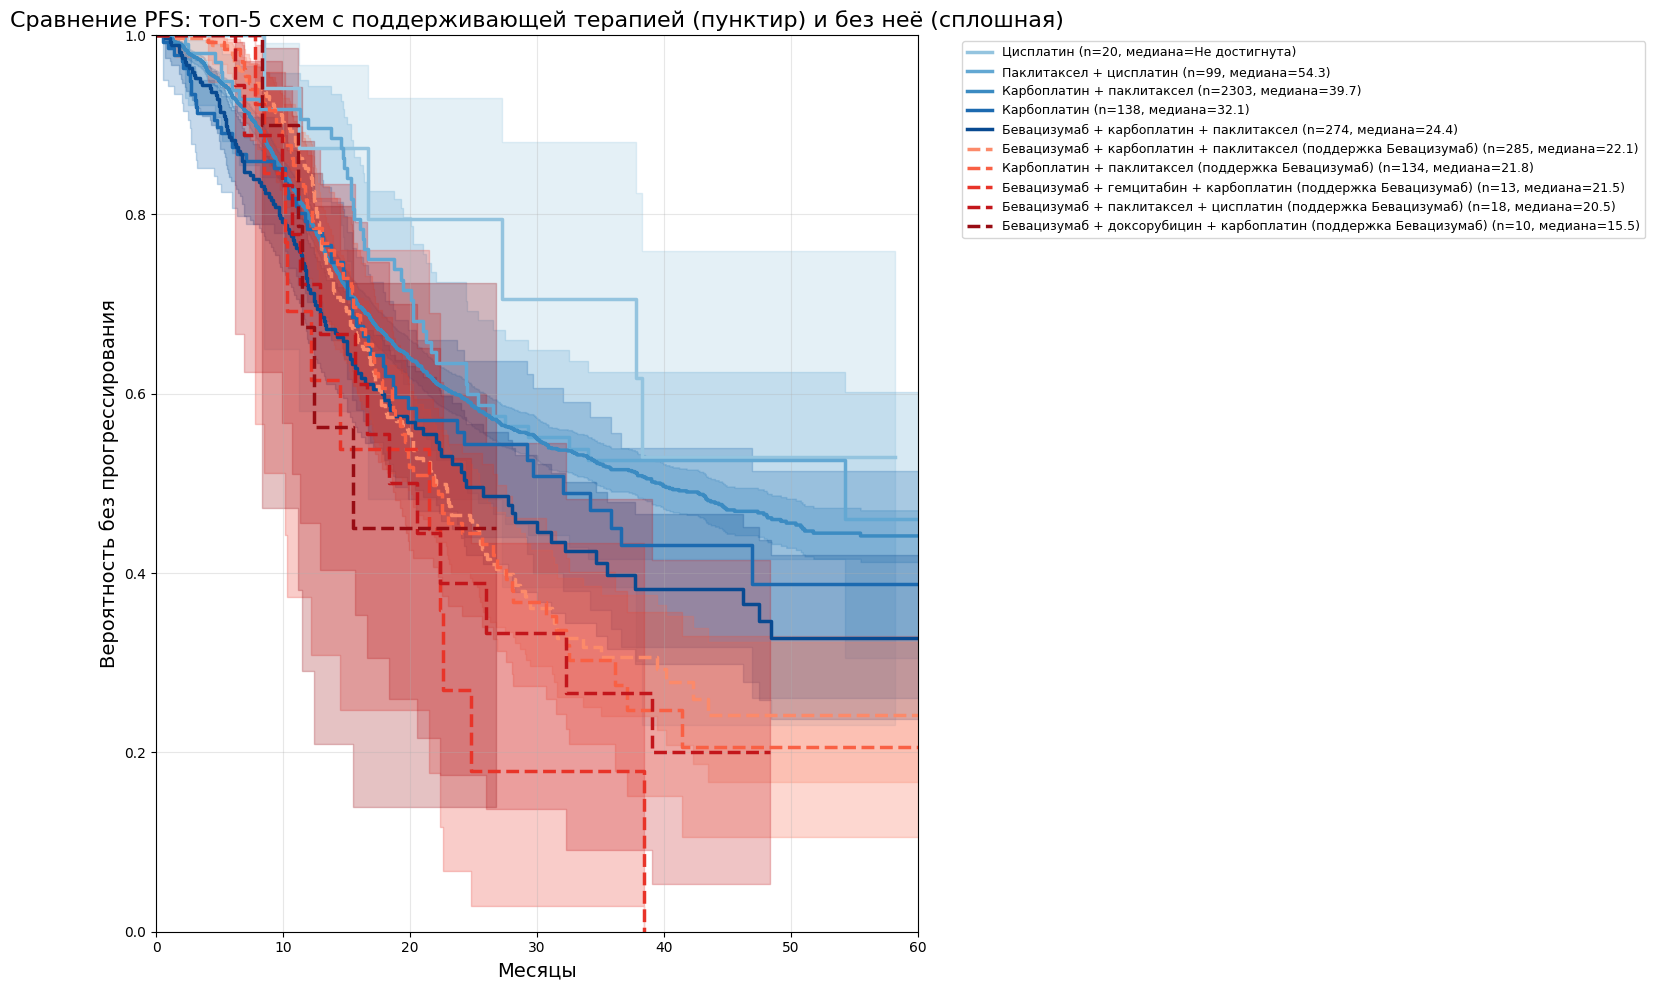


ПРЯМОЕ СРАВНЕНИЕ ОДИНАКОВЫХ СХЕМ С ПОДДЕРЖКОЙ И БЕЗ

Карбоплатин + паклитаксел:
  Без поддержки: n=2303, медиана=39.7
  Карбоплатин + паклитаксел (поддержка Бевацизумаб): n=134, медиана=21.8
  p-value (сравнение с/без поддержки): 0.0009

Бевацизумаб + карбоплатин + паклитаксел:
  Без поддержки: n=274, медиана=24.4
  Бевацизумаб + карбоплатин + паклитаксел (поддержка Бевацизумаб): n=285, медиана=22.1
  p-value (сравнение с/без поддержки): 0.7811

Бевацизумаб + паклитаксел + цисплатин:
  Без поддержки: n=22, медиана=22.0
  Бевацизумаб + паклитаксел + цисплатин (поддержка Бевацизумаб): n=18, медиана=20.5
  p-value (сравнение с/без поддержки): 0.5496

Бевацизумаб + карбоплатин:
  Без поддержки: n=15, медиана=14.9
  Бевацизумаб + карбоплатин (поддержка Бевацизумаб): n=10, медиана=12.9
  p-value (сравнение с/без поддержки): 0.9831

Бевацизумаб + доксорубицин + карбоплатин:
  Без поддержки: n=15, медиана=13.5
  Бевацизумаб + доксорубицин + карбоплатин (поддержка Бевацизумаб): n=10, медиана=1

In [28]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def analyze_pfs_with_maintenance(df):
    """
    Анализ PFS для схем с поддерживающей терапией (02.) и без неё
    """

    if df is None:
        print("Нет данных для анализа")
        return None

    print("Анализ схем с поддерживающей терапией и без неё...")

    # Преобразование дат
    date_cols = ['date_z1', 'prr_death_date', 'last_contact_date_reestr', 'prr_last_contact']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Определяем пациентов с поддерживающей терапией
    patients_with_maintenance = df[
        (df['line_karina'] == 1) &
        (df['karina_support_scheme'] == '02.')
    ]['polis_number'].unique()

    print(f"\nПациентов с поддерживающей терапией (02.): {len(patients_with_maintenance)}")

    # Для каждого пациента определяем:
    # 1. Основную схему (01.)
    # 2. Поддерживающую схему (02.) если есть
    patient_schemes = {}

    for patient in df[df['line_karina'] == 1]['polis_number'].unique():
        patient_data = df[(df['polis_number'] == patient) & (df['line_karina'] == 1)]

        # Основная схема (01.)
        main_scheme_data = patient_data[patient_data['karina_support_scheme'] == '01.']
        if not main_scheme_data.empty:
            # Выбираем наиболее частую схему
            main_scheme_counts = main_scheme_data['drugs_in_scheme'].value_counts()
            main_scheme = main_scheme_counts.index[0]

            # Поддерживающая схема (02.)
            maintenance_scheme = None
            maintenance_data = patient_data[patient_data['karina_support_scheme'] == '02.']
            if not maintenance_data.empty:
                maintenance_counts = maintenance_data['drugs_in_scheme'].value_counts()
                maintenance_scheme = maintenance_counts.index[0]

            patient_schemes[patient] = {
                'main_scheme': main_scheme,
                'maintenance_scheme': maintenance_scheme,
                'has_maintenance': maintenance_scheme is not None
            }

    # Преобразуем в DataFrame
    schemes_df = pd.DataFrame.from_dict(patient_schemes, orient='index').reset_index()
    schemes_df.columns = ['polis_number', 'main_scheme', 'maintenance_scheme', 'has_maintenance']

    # Создаем комбинированное название схемы
    schemes_df['combined_scheme'] = schemes_df.apply(
        lambda row: f"{row['main_scheme']} (поддержка {row['maintenance_scheme']})"
        if row['has_maintenance'] else row['main_scheme'],
        axis=1
    )

    # Статистика по поддерживающим схемам
    print("\nНаиболее частые поддерживающие схемы:")
    maintenance_stats = schemes_df[schemes_df['has_maintenance']]['maintenance_scheme'].value_counts()
    for scheme, count in maintenance_stats.head(10).items():
        print(f"  {scheme}: {count} пациентов")

    # Получаем даты для расчета PFS
    patient_dates = df[df['line_karina'] == 1].groupby('polis_number').agg({
        'date_z1': 'min'
    }).reset_index()

    # Даты прогрессирования (начало второй линии)
    progression_dates = df[df['line_karina'] == 2].groupby('polis_number')['date_z1'].min().reset_index()
    progression_dates.columns = ['polis_number', 'progression_date']

    # Даты последнего контакта
    last_info = df.groupby('polis_number').agg({
        'prr_death_date': 'last',
        'last_contact_date_reestr': 'last',
        'prr_last_contact': 'last'
    }).reset_index()

    # Объединяем все данные
    pfs_data_raw = schemes_df.merge(patient_dates, on='polis_number')
    pfs_data_raw = pfs_data_raw.merge(progression_dates, on='polis_number', how='left')
    pfs_data_raw = pfs_data_raw.merge(last_info, on='polis_number', how='left')

    pfs_data_raw['last_observation'] = pfs_data_raw[['last_contact_date_reestr', 'prr_last_contact']].max(axis=1)

    # Расчет PFS
    pfs_list = []

    for _, row in pfs_data_raw.iterrows():
        start_date = row['date_z1']

        if pd.isna(start_date):
            continue

        if pd.notna(row['progression_date']) and row['progression_date'] > start_date:
            duration = (row['progression_date'] - start_date).days / 30.44
            event = 1
        elif pd.notna(row['prr_death_date']) and row['prr_death_date'] > start_date:
            duration = (row['prr_death_date'] - start_date).days / 30.44
            event = 1
        elif pd.notna(row['last_observation']) and row['last_observation'] > start_date:
            duration = (row['last_observation'] - start_date).days / 30.44
            event = 0
        else:
            continue

        if duration > 0:
            pfs_list.append({
                'polis_number': row['polis_number'],
                'combined_scheme': row['combined_scheme'],
                'main_scheme': row['main_scheme'],
                'has_maintenance': row['has_maintenance'],
                'duration': duration,
                'event_observed': event
            })

    pfs_df = pd.DataFrame(pfs_list)

    print(f"\nСоздана таблица PFS для {len(pfs_df)} пациентов")
    print(f"С поддерживающей терапией: {pfs_df['has_maintenance'].sum()}")
    print(f"Без поддерживающей терапии: {(~pfs_df['has_maintenance']).sum()}")

    # Фильтрация схем с >= 10 пациентами
    scheme_counts = pfs_df['combined_scheme'].value_counts()
    valid_schemes = scheme_counts[scheme_counts >= 10].index

    print(f"\nСхем с >= 10 пациентами: {len(valid_schemes)}")

    # Расчет медиан для всех валидных схем
    kmf = KaplanMeierFitter()
    results = []

    for scheme in valid_schemes:
        scheme_data = pfs_df[pfs_df['combined_scheme'] == scheme]

        kmf.fit(scheme_data['duration'], event_observed=scheme_data['event_observed'])
        median = kmf.median_survival_time_

        # Определяем тип схемы
        has_maintenance = "(поддержка" in scheme

        result = {
            'Схема': scheme,
            'Тип': 'С поддержкой' if has_maintenance else 'Без поддержки',
            'N пациентов': len(scheme_data),
            'События (n)': scheme_data['event_observed'].sum(),
            'События (%)': f"{scheme_data['event_observed'].sum()/len(scheme_data)*100:.1f}",
            'Медиана PFS (мес)': f"{median:.1f}" if median != np.inf else 'Не достигнута',
            'median_numeric': median if median != np.inf else 999
        }

        results.append(result)

    results_df = pd.DataFrame(results)

    # Расчет p-values относительно референса "Карбоплатин + паклитаксел"
    ref_scheme = 'Карбоплатин + паклитаксел'
    ref_data = None

    if ref_scheme in pfs_df['combined_scheme'].values:
        ref_data = pfs_df[pfs_df['combined_scheme'] == ref_scheme]

    for i, row in results_df.iterrows():
        if row['Схема'] == ref_scheme:
            results_df.loc[i, 'p-value'] = 'Референс'
        elif ref_data is not None:
            scheme_data = pfs_df[pfs_df['combined_scheme'] == row['Схема']]
            try:
                logrank_result = logrank_test(
                    ref_data['duration'],
                    scheme_data['duration'],
                    event_observed_A=ref_data['event_observed'],
                    event_observed_B=scheme_data['event_observed']
                )
                results_df.loc[i, 'p-value'] = f"{logrank_result.p_value:.4f}"
            except:
                results_df.loc[i, 'p-value'] = '-'
        else:
            results_df.loc[i, 'p-value'] = '-'

    # Сортировка по медиане
    results_df = results_df.sort_values('median_numeric', ascending=False)

    # Выбор топ-5 с поддержкой и без
    top5_maintenance = results_df[results_df['Тип'] == 'С поддержкой'].head(5)
    top5_no_maintenance = results_df[results_df['Тип'] == 'Без поддержки'].head(5)

    # Объединенный топ-10
    top10_combined = pd.concat([top5_maintenance, top5_no_maintenance])

    print("\n" + "="*120)
    print("РЕЗУЛЬТАТЫ PFS: СХЕМЫ С ПОДДЕРЖИВАЮЩЕЙ ТЕРАПИЕЙ И БЕЗ НЕЁ")
    print("="*120)
    print(results_df[['Схема', 'Тип', 'N пациентов', 'События (n)', 'События (%)',
                      'Медиана PFS (мес)', 'p-value']].to_string(index=False))

    print("\n" + "="*100)
    print("ТОП-5 СХЕМ БЕЗ ПОДДЕРЖИВАЮЩЕЙ ТЕРАПИИ")
    print("="*100)
    print(top5_no_maintenance[['Схема', 'N пациентов', 'События (%)',
                               'Медиана PFS (мес)', 'p-value']].to_string(index=False))

    print("\n" + "="*100)
    print("ТОП-5 СХЕМ С ПОДДЕРЖИВАЮЩЕЙ ТЕРАПИЕЙ")
    print("="*100)
    print(top5_maintenance[['Схема', 'N пациентов', 'События (%)',
                            'Медиана PFS (мес)', 'p-value']].to_string(index=False))

    # График сравнения топ-5 схем с поддержкой и без
    plt.figure(figsize=(16, 10))

    # Цвета: синие оттенки для схем без поддержки, красные - с поддержкой
    colors_no_maint = plt.cm.Blues(np.linspace(0.4, 0.9, 5))
    colors_maint = plt.cm.Reds(np.linspace(0.4, 0.9, 5))

    # Сначала схемы без поддержки
    for i, (_, row) in enumerate(top5_no_maintenance.iterrows()):
        scheme_data = pfs_df[pfs_df['combined_scheme'] == row['Схема']]
        kmf.fit(scheme_data['duration'],
                event_observed=scheme_data['event_observed'],
                label=f"{row['Схема']} (n={row['N пациентов']}, медиана={row['Медиана PFS (мес)']})")
        kmf.plot_survival_function(color=colors_no_maint[i], linewidth=2.5, linestyle='-')

    # Затем схемы с поддержкой
    for i, (_, row) in enumerate(top5_maintenance.iterrows()):
        scheme_data = pfs_df[pfs_df['combined_scheme'] == row['Схема']]
        kmf.fit(scheme_data['duration'],
                event_observed=scheme_data['event_observed'],
                label=f"{row['Схема']} (n={row['N пациентов']}, медиана={row['Медиана PFS (мес)']})")
        kmf.plot_survival_function(color=colors_maint[i], linewidth=2.5, linestyle='--')

    plt.title('Сравнение PFS: топ-5 схем с поддерживающей терапией (пунктир) и без неё (сплошная)', fontsize=16)
    plt.xlabel('Месяцы', fontsize=14)
    plt.ylabel('Вероятность без прогрессирования', fontsize=14)
    plt.xlim(0, 60)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.savefig('pfs_maintenance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Дополнительный анализ: прямое сравнение одинаковых схем с поддержкой и без
    print("\n" + "="*100)
    print("ПРЯМОЕ СРАВНЕНИЕ ОДИНАКОВЫХ СХЕМ С ПОДДЕРЖКОЙ И БЕЗ")
    print("="*100)

    # Находим схемы, которые есть и с поддержкой, и без
    main_schemes_with_both = []
    for scheme in results_df[results_df['Тип'] == 'Без поддержки']['Схема']:
        # Ищем соответствующую схему с поддержкой
        matching = results_df[(results_df['Тип'] == 'С поддержкой') &
                             (results_df['Схема'].str.startswith(scheme + ' (поддержка'))]
        if not matching.empty:
            main_schemes_with_both.append(scheme)

    for main_scheme in main_schemes_with_both[:5]:  # Топ-5 таких схем
        # Данные без поддержки
        no_maint = results_df[results_df['Схема'] == main_scheme].iloc[0]

        # Данные с поддержкой
        with_maint = results_df[(results_df['Тип'] == 'С поддержкой') &
                               (results_df['Схема'].str.startswith(main_scheme + ' (поддержка'))]

        if not with_maint.empty:
            with_maint = with_maint.iloc[0]

            # Сравнительный log-rank тест
            data_no_maint = pfs_df[pfs_df['combined_scheme'] == main_scheme]
            data_with_maint = pfs_df[pfs_df['combined_scheme'] == with_maint['Схема']]

            try:
                logrank_result = logrank_test(
                    data_no_maint['duration'],
                    data_with_maint['duration'],
                    event_observed_A=data_no_maint['event_observed'],
                    event_observed_B=data_with_maint['event_observed']
                )
                p_value = f"{logrank_result.p_value:.4f}"
            except:
                p_value = '-'

            print(f"\n{main_scheme}:")
            print(f"  Без поддержки: n={no_maint['N пациентов']}, медиана={no_maint['Медиана PFS (мес)']}")
            print(f"  {with_maint['Схема']}: n={with_maint['N пациентов']}, медиана={with_maint['Медиана PFS (мес)']}")
            print(f"  p-value (сравнение с/без поддержки): {p_value}")

    return pfs_df, results_df

# Запуск анализа
if df is not None:
    pfs_maintenance, results_maintenance = analyze_pfs_with_maintenance(df)
else:
    print("DataFrame 'df' не найден")

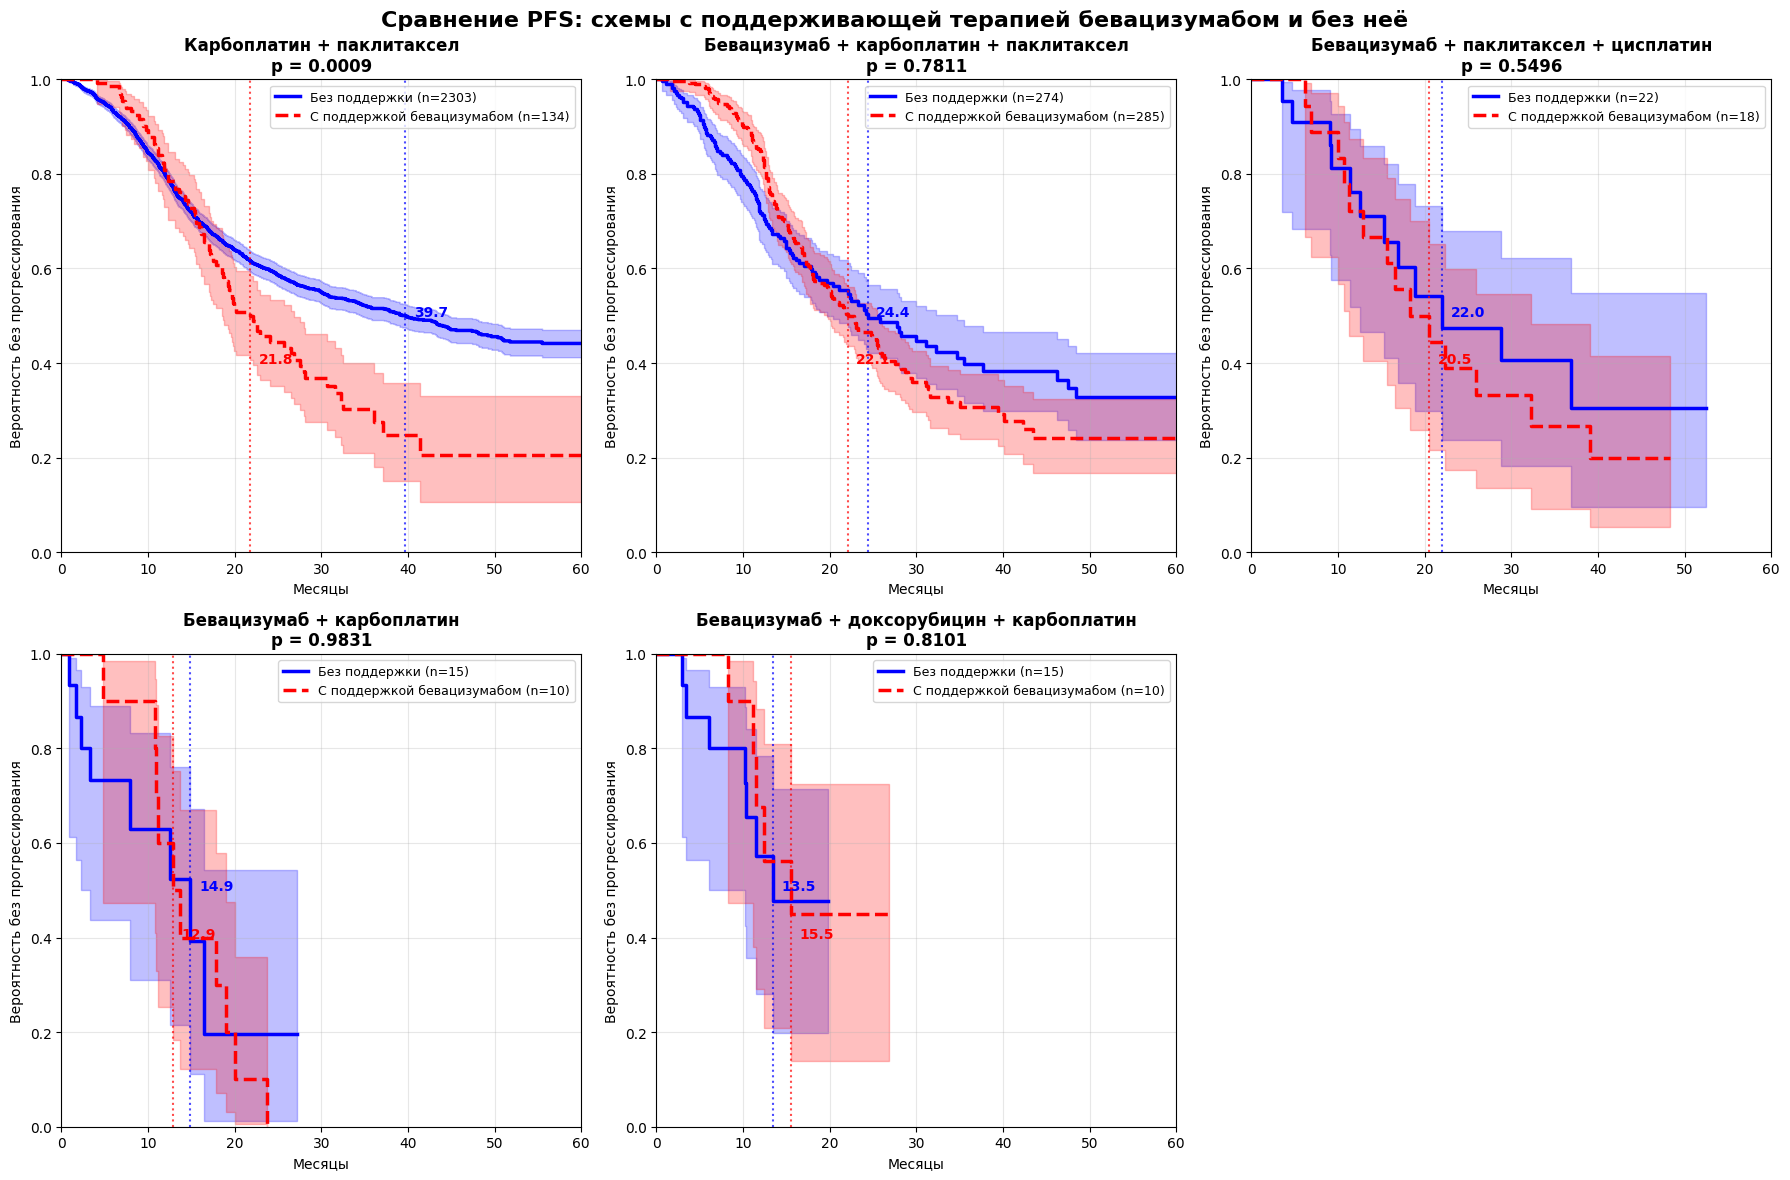


СВОДНАЯ ТАБЛИЦА: МЕДИАНЫ PFS С ПОДДЕРЖКОЙ И БЕЗ
                                   Схема  N без подд. Медиана без подд.  N с подд. Медиана с подд. Разница (мес) Разница (%) p-value
               Карбоплатин + паклитаксел         2303              39.7        134            21.8          17.9        45.1  0.0009
 Бевацизумаб + карбоплатин + паклитаксел          274              24.4        285            22.1           2.3         9.4  0.7811
   Бевацизумаб + паклитаксел + цисплатин           22              22.0         18            20.5           1.5         6.8  0.5496
               Бевацизумаб + карбоплатин           15              14.9         10            12.9           2.0        13.4  0.9831
Бевацизумаб + доксорубицин + карбоплатин           15              13.5         10            15.5          -2.0       -14.8  0.8101


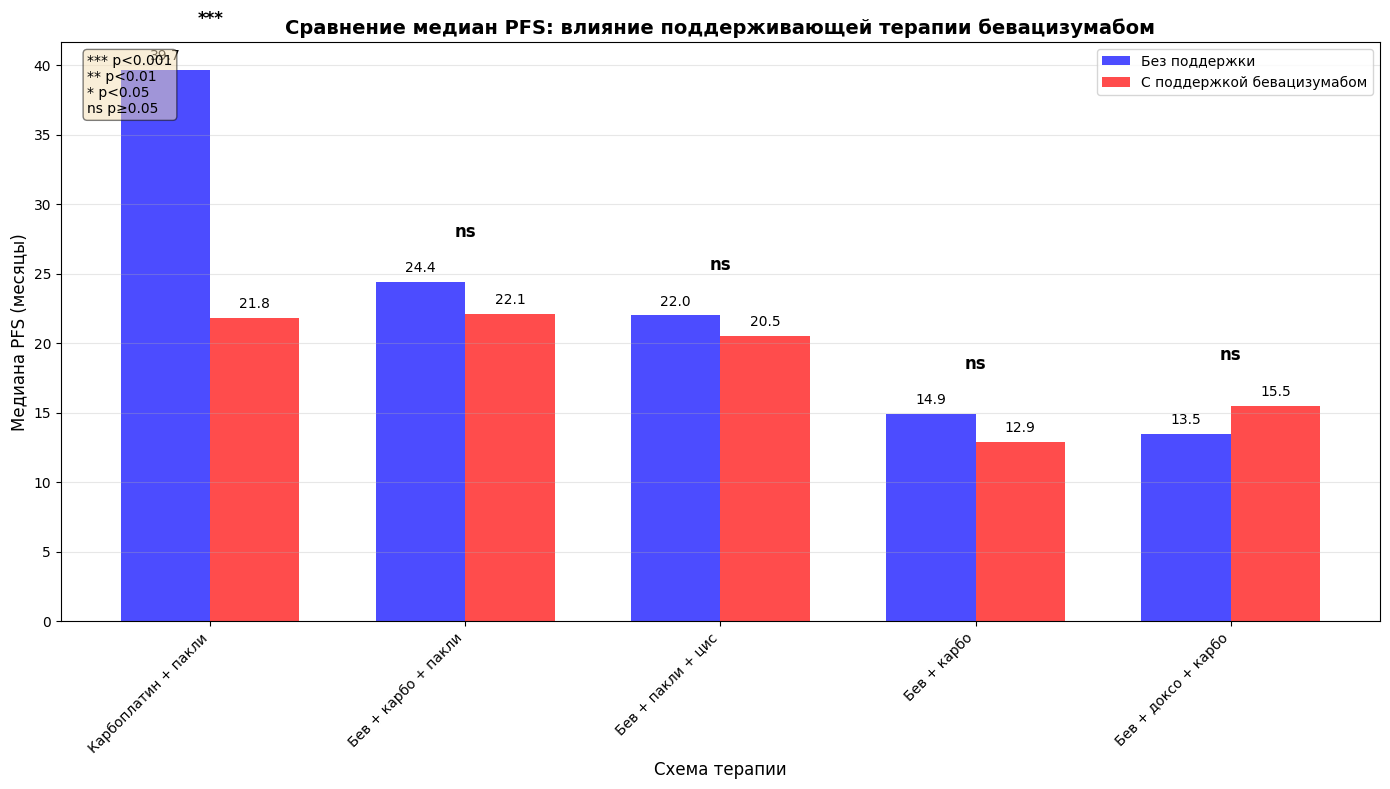

In [29]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def plot_maintenance_comparison(pfs_df, results_df):
    """
    Создает сравнительные графики для схем с поддерживающей терапией и без неё
    """

    # Схемы для сравнения (из вашего вывода)
    comparison_schemes = [
        {
            'main': 'Карбоплатин + паклитаксел',
            'with_maint': 'Карбоплатин + паклитаксел (поддержка Бевацизумаб)',
            'p_value': '0.0009'
        },
        {
            'main': 'Бевацизумаб + карбоплатин + паклитаксел',
            'with_maint': 'Бевацизумаб + карбоплатин + паклитаксел (поддержка Бевацизумаб)',
            'p_value': '0.7811'
        },
        {
            'main': 'Бевацизумаб + паклитаксел + цисплатин',
            'with_maint': 'Бевацизумаб + паклитаксел + цисплатин (поддержка Бевацизумаб)',
            'p_value': '0.5496'
        },
        {
            'main': 'Бевацизумаб + карбоплатин',
            'with_maint': 'Бевацизумаб + карбоплатин (поддержка Бевацизумаб)',
            'p_value': '0.9831'
        },
        {
            'main': 'Бевацизумаб + доксорубицин + карбоплатин',
            'with_maint': 'Бевацизумаб + доксорубицин + карбоплатин (поддержка Бевацизумаб)',
            'p_value': '0.8101'
        }
    ]

    # Создаем фигуру с подграфиками
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    kmf = KaplanMeierFitter()

    for idx, scheme_info in enumerate(comparison_schemes):
        ax = axes[idx]

        # Данные без поддержки
        data_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]
        # Данные с поддержкой
        data_with_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['with_maint']]

        if not data_no_maint.empty:
            # График без поддержки (синий, сплошная линия)
            kmf.fit(data_no_maint['duration'],
                   event_observed=data_no_maint['event_observed'])
            kmf.plot_survival_function(ax=ax, color='blue', linewidth=2.5,
                                     label=f"Без поддержки (n={len(data_no_maint)})")

            # Добавляем медиану
            median_no_maint = kmf.median_survival_time_
            if median_no_maint != np.inf:
                ax.axvline(x=median_no_maint, color='blue', linestyle=':', alpha=0.7)
                ax.text(median_no_maint + 1, 0.5, f'{median_no_maint:.1f}',
                       color='blue', fontsize=10, fontweight='bold')

        if not data_with_maint.empty:
            # График с поддержкой (красный, пунктирная линия)
            kmf.fit(data_with_maint['duration'],
                   event_observed=data_with_maint['event_observed'])
            kmf.plot_survival_function(ax=ax, color='red', linewidth=2.5, linestyle='--',
                                     label=f"С поддержкой бевацизумабом (n={len(data_with_maint)})")

            # Добавляем медиану
            median_with_maint = kmf.median_survival_time_
            if median_with_maint != np.inf:
                ax.axvline(x=median_with_maint, color='red', linestyle=':', alpha=0.7)
                ax.text(median_with_maint + 1, 0.4, f'{median_with_maint:.1f}',
                       color='red', fontsize=10, fontweight='bold')

        # Настройка графика
        # Сокращаем название для заголовка
        title = scheme_info['main']
        if len(title) > 40:
            title = title[:37] + '...'

        ax.set_title(f"{title}\np = {scheme_info['p_value']}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Месяцы', fontsize=10)
        ax.set_ylabel('Вероятность без прогрессирования', fontsize=10)
        ax.set_xlim(0, 60)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=9)

    # Удаляем пустой 6-й график
    fig.delaxes(axes[5])

    # Общий заголовок
    fig.suptitle('Сравнение PFS: схемы с поддерживающей терапией бевацизумабом и без неё',
                 fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('pfs_maintenance_detailed_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Дополнительно создаем сводную таблицу с медианами
    print("\n" + "="*80)
    print("СВОДНАЯ ТАБЛИЦА: МЕДИАНЫ PFS С ПОДДЕРЖКОЙ И БЕЗ")
    print("="*80)

    summary_data = []

    for scheme_info in comparison_schemes:
        # Получаем данные из results_df
        no_maint_data = results_df[results_df['Схема'] == scheme_info['main']]
        with_maint_data = results_df[results_df['Схема'] == scheme_info['with_maint']]

        if not no_maint_data.empty and not with_maint_data.empty:
            no_maint = no_maint_data.iloc[0]
            with_maint = with_maint_data.iloc[0]

            # Рассчитываем разницу в медианах
            try:
                median_no = float(no_maint['Медиана PFS (мес)']) if no_maint['Медиана PFS (мес)'] != 'Не достигнута' else np.nan
                median_with = float(with_maint['Медиана PFS (мес)']) if with_maint['Медиана PFS (мес)'] != 'Не достигнута' else np.nan

                if not np.isnan(median_no) and not np.isnan(median_with):
                    diff = median_no - median_with
                    diff_pct = (diff / median_no) * 100
                else:
                    diff = np.nan
                    diff_pct = np.nan
            except:
                diff = np.nan
                diff_pct = np.nan

            summary_data.append({
                'Схема': scheme_info['main'][:50] + '...' if len(scheme_info['main']) > 50 else scheme_info['main'],
                'N без подд.': no_maint['N пациентов'],
                'Медиана без подд.': no_maint['Медиана PFS (мес)'],
                'N с подд.': with_maint['N пациентов'],
                'Медиана с подд.': with_maint['Медиана PFS (мес)'],
                'Разница (мес)': f"{diff:.1f}" if not np.isnan(diff) else '-',
                'Разница (%)': f"{diff_pct:.1f}" if not np.isnan(diff_pct) else '-',
                'p-value': scheme_info['p_value']
            })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    # График с медианами в виде столбчатой диаграммы
    fig2, ax2 = plt.subplots(figsize=(14, 8))

    x = np.arange(len(summary_df))
    width = 0.35

    # Медианы без поддержки
    medians_no_maint = []
    medians_with_maint = []

    for _, row in summary_df.iterrows():
        try:
            median_no = float(row['Медиана без подд.']) if row['Медиана без подд.'] != 'Не достигнута' else 0
            median_with = float(row['Медиана с подд.']) if row['Медиана с подд.'] != 'Не достигнута' else 0
        except:
            median_no = 0
            median_with = 0

        medians_no_maint.append(median_no)
        medians_with_maint.append(median_with)

    # Столбцы
    bars1 = ax2.bar(x - width/2, medians_no_maint, width, label='Без поддержки',
                     color='blue', alpha=0.7)
    bars2 = ax2.bar(x + width/2, medians_with_maint, width, label='С поддержкой бевацизумабом',
                     color='red', alpha=0.7)

    # Добавляем значения на столбцы
    for i, (bar1, bar2, p_val) in enumerate(zip(bars1, bars2, [s['p_value'] for s in comparison_schemes])):
        height1 = bar1.get_height()
        height2 = bar2.get_height()

        if height1 > 0:
            ax2.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.5,
                    f'{height1:.1f}', ha='center', va='bottom', fontsize=10)

        if height2 > 0:
            ax2.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.5,
                    f'{height2:.1f}', ha='center', va='bottom', fontsize=10)

        # Добавляем p-value сверху
        max_height = max(height1, height2)
        significance = '***' if float(p_val) < 0.001 else '**' if float(p_val) < 0.01 else '*' if float(p_val) < 0.05 else 'ns'
        ax2.text(x[i], max_height + 3, significance, ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    # Настройка осей
    ax2.set_xlabel('Схема терапии', fontsize=12)
    ax2.set_ylabel('Медиана PFS (месяцы)', fontsize=12)
    ax2.set_title('Сравнение медиан PFS: влияние поддерживающей терапии бевацизумабом',
                  fontsize=14, fontweight='bold')
    ax2.set_xticks(x)

    # Сокращаем названия для оси X
    labels = []
    for scheme in comparison_schemes:
        label = scheme['main']
        if 'Бевацизумаб' in label:
            label = label.replace('Бевацизумаб + ', 'Бев + ')
        if 'карбоплатин' in label:
            label = label.replace('карбоплатин', 'карбо')
        if 'паклитаксел' in label:
            label = label.replace('паклитаксел', 'пакли')
        if 'доксорубицин' in label:
            label = label.replace('доксорубицин', 'доксо')
        if 'цисплатин' in label:
            label = label.replace('цисплатин', 'цис')
        labels.append(label)

    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, axis='y', alpha=0.3)

    # Добавляем легенду для значимости
    ax2.text(0.02, 0.98, '*** p<0.001\n** p<0.01\n* p<0.05\nns p≥0.05',
            transform=ax2.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('pfs_maintenance_medians_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Вызов функции
if 'pfs_maintenance' in locals() and 'results_maintenance' in locals():
    plot_maintenance_comparison(pfs_maintenance, results_maintenance)
else:
    print("Сначала запустите analyze_pfs_with_maintenance(df)")

# Средняя стоимость лечения

АНАЛИЗ КОЛИЧЕСТВА ЦИКЛОВ И СТОИМОСТИ ЛЕЧЕНИЯ

ПОЛНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
                                                Схема           Тип  N пациентов Среднее циклов     ДИ циклов  Мин циклов  Макс циклов Средняя стоимость            ДИ стоимости Мин стоимость Макс стоимость Общая сумма
                            Карбоплатин + паклитаксел Без поддержки         2303            4.9   [4.8 - 4.9]           1           37           219,950     [203,619 - 236,281]        19,645      9,046,522 506,545,124
    Карбоплатин + паклитаксел (поддержка Бевацизумаб)  С поддержкой          134           14.1 [13.1 - 15.1]           5           28         1,054,882   [966,003 - 1,143,761]       226,450      2,541,015 141,354,208
              Бевацизумаб + карбоплатин + паклитаксел Без поддержки          274            5.0   [4.7 - 5.3]           1           23           635,902     [565,534 - 706,269]       100,725      7,074,273 174,237,031
Бевацизумаб + карбоплатин + паклитаксел (поддержка... 

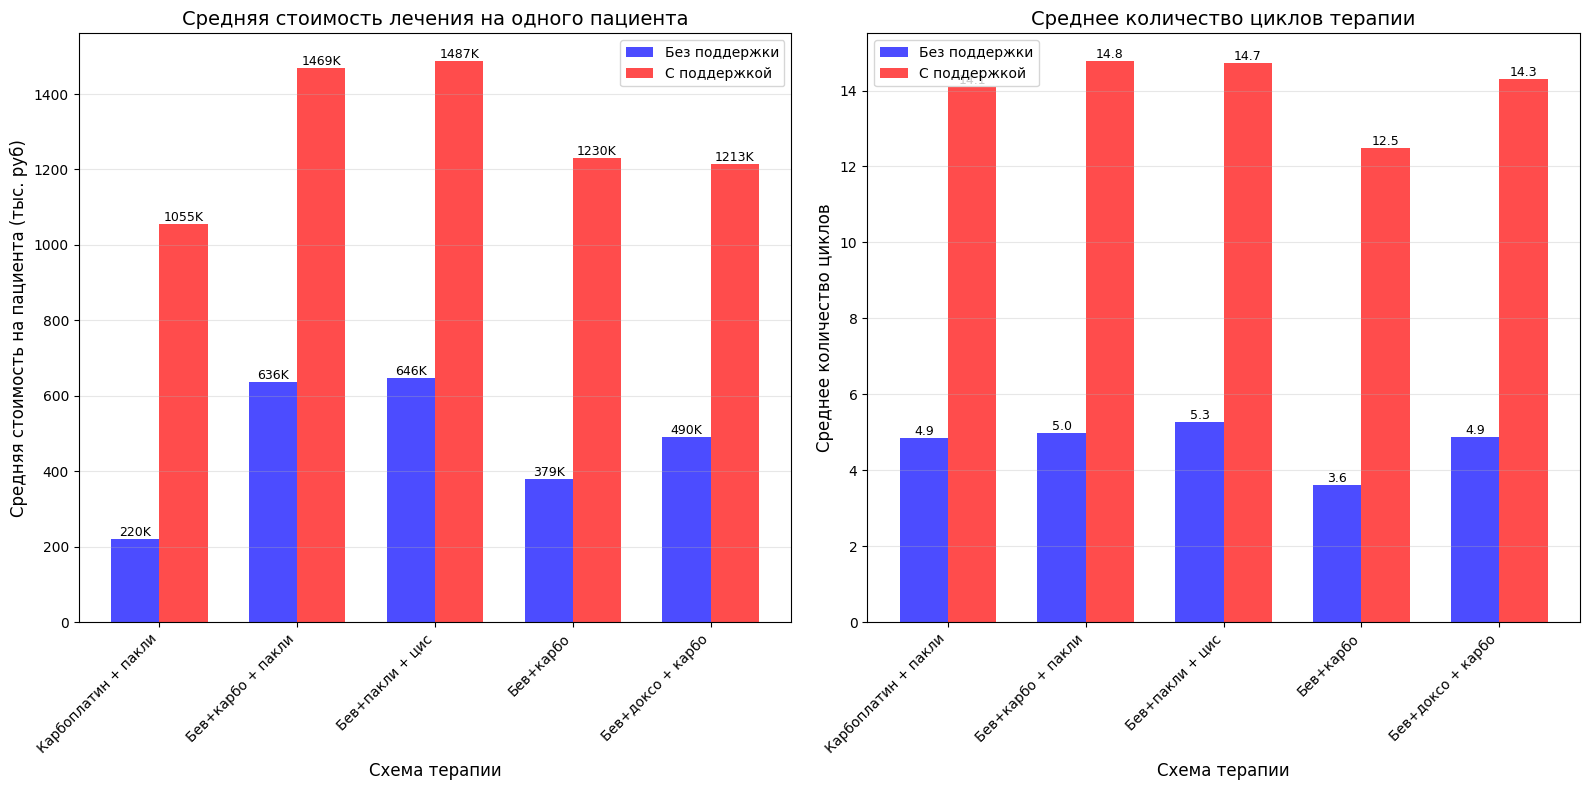


ИТОГОВАЯ СРАВНИТЕЛЬНАЯ ТАБЛИЦА
              Схема Циклов без подд. Циклов с подд. Разница циклов Стоимость без подд. (тыс.руб) Стоимость с подд. (тыс.руб) Разница стоимости (тыс.руб) Разница стоимости (%)
Карбоплатин + пакли              4.9           14.1           +9.2                           220                        1055                        +835                 +380%
  Бев+карбо + пакли              5.0           14.8           +9.8                           636                        1469                        +833                 +131%
    Бев+пакли + цис              5.3           14.7           +9.4                           646                        1487                        +840                 +130%
          Бев+карбо              3.6           12.5           +8.9                           379                        1230                        +851                 +224%
  Бев+доксо + карбо              4.9           14.3           +9.4                           

In [30]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def analyze_cycles_and_costs_fixed(df, pfs_df, comparison_schemes):
    """
    Анализ количества циклов и стоимости лечения для схем с поддержкой и без
    """

    print("="*100)
    print("АНАЛИЗ КОЛИЧЕСТВА ЦИКЛОВ И СТОИМОСТИ ЛЕЧЕНИЯ")
    print("="*100)

    # Собираем результаты
    results = []

    for scheme_info in comparison_schemes:
        # Анализируем схему без поддержки
        patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()

        if len(patients_no_maint) > 0:
            # Фильтруем данные для этих пациентов (первая линия)
            df_scheme = df[
                (df['polis_number'].isin(patients_no_maint)) &
                (df['line_karina'] == 1)
            ]

            # Подсчет циклов для каждого пациента
            cycles_per_patient = df_scheme.groupby('polis_number').size()

            # Подсчет стоимости для каждого пациента
            cost_per_patient = df_scheme.groupby('polis_number')['tariff'].sum()

            # Статистика по циклам
            cycles_mean = cycles_per_patient.mean()
            cycles_std = cycles_per_patient.std()
            cycles_sem = stats.sem(cycles_per_patient)
            cycles_ci_lower = cycles_mean - 1.96 * cycles_sem
            cycles_ci_upper = cycles_mean + 1.96 * cycles_sem

            # Статистика по стоимости
            cost_mean = cost_per_patient.mean()
            cost_std = cost_per_patient.std()
            cost_sem = stats.sem(cost_per_patient)
            cost_ci_lower = cost_mean - 1.96 * cost_sem
            cost_ci_upper = cost_mean + 1.96 * cost_sem

            results.append({
                'Схема': scheme_info['main'],
                'Схема_полная': scheme_info['main'],
                'Тип': 'Без поддержки',
                'N пациентов': len(patients_no_maint),
                'Среднее циклов': f"{cycles_mean:.1f}",
                'ДИ циклов': f"[{cycles_ci_lower:.1f} - {cycles_ci_upper:.1f}]",
                'Мин циклов': cycles_per_patient.min(),
                'Макс циклов': cycles_per_patient.max(),
                'Средняя стоимость': f"{cost_mean:,.0f}",
                'ДИ стоимости': f"[{cost_ci_lower:,.0f} - {cost_ci_upper:,.0f}]",
                'Мин стоимость': f"{cost_per_patient.min():,.0f}",
                'Макс стоимость': f"{cost_per_patient.max():,.0f}",
                'Общая сумма': f"{cost_per_patient.sum():,.0f}",
                'cycles_mean_num': cycles_mean,
                'cost_mean_num': cost_mean
            })

        # Анализируем схему с поддержкой
        patients_with_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['with_maint']]['polis_number'].unique()

        if len(patients_with_maint) > 0:
            # Для схем с поддержкой учитываем оба типа (01. и 02.)
            df_scheme_all = df[
                (df['polis_number'].isin(patients_with_maint)) &
                (df['line_karina'] == 1)
            ]

            # Подсчет циклов для каждого пациента (все циклы первой линии)
            cycles_per_patient = df_scheme_all.groupby('polis_number').size()

            # Подсчет стоимости для каждого пациента
            cost_per_patient = df_scheme_all.groupby('polis_number')['tariff'].sum()

            # Статистика по циклам
            cycles_mean = cycles_per_patient.mean()
            cycles_std = cycles_per_patient.std()
            cycles_sem = stats.sem(cycles_per_patient)
            cycles_ci_lower = cycles_mean - 1.96 * cycles_sem
            cycles_ci_upper = cycles_mean + 1.96 * cycles_sem

            # Статистика по стоимости
            cost_mean = cost_per_patient.mean()
            cost_std = cost_per_patient.std()
            cost_sem = stats.sem(cost_per_patient)
            cost_ci_lower = cost_mean - 1.96 * cost_sem
            cost_ci_upper = cost_mean + 1.96 * cost_sem

            results.append({
                'Схема': scheme_info['with_maint'][:50] + '...' if len(scheme_info['with_maint']) > 50 else scheme_info['with_maint'],
                'Схема_полная': scheme_info['with_maint'],
                'Тип': 'С поддержкой',
                'N пациентов': len(patients_with_maint),
                'Среднее циклов': f"{cycles_mean:.1f}",
                'ДИ циклов': f"[{cycles_ci_lower:.1f} - {cycles_ci_upper:.1f}]",
                'Мин циклов': cycles_per_patient.min(),
                'Макс циклов': cycles_per_patient.max(),
                'Средняя стоимость': f"{cost_mean:,.0f}",
                'ДИ стоимости': f"[{cost_ci_lower:,.0f} - {cost_ci_upper:,.0f}]",
                'Мин стоимость': f"{cost_per_patient.min():,.0f}",
                'Макс стоимость': f"{cost_per_patient.max():,.0f}",
                'Общая сумма': f"{cost_per_patient.sum():,.0f}",
                'cycles_mean_num': cycles_mean,
                'cost_mean_num': cost_mean
            })

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)

    # Выводим полную таблицу
    print("\nПОЛНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
    print(results_df[['Схема', 'Тип', 'N пациентов', 'Среднее циклов', 'ДИ циклов',
                      'Мин циклов', 'Макс циклов', 'Средняя стоимость', 'ДИ стоимости',
                      'Мин стоимость', 'Макс стоимость', 'Общая сумма']].to_string(index=False))

    # Создаем сравнительную таблицу
    print("\n" + "="*80)
    print("СРАВНЕНИЕ СХЕМ С ПОДДЕРЖКОЙ И БЕЗ")
    print("="*80)

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Подготовка данных для графиков
    schemes_names = []
    costs_no_maint = []
    costs_with_maint = []
    cycles_no_maint = []
    cycles_with_maint = []

    for scheme_info in comparison_schemes:
        # Находим данные без поддержки
        no_maint_data = results_df[
            (results_df['Схема_полная'] == scheme_info['main']) &
            (results_df['Тип'] == 'Без поддержки')
        ]

        # Находим данные с поддержкой
        with_maint_data = results_df[
            (results_df['Схема_полная'] == scheme_info['with_maint']) &
            (results_df['Тип'] == 'С поддержкой')
        ]

        if not no_maint_data.empty and not with_maint_data.empty:
            # Сокращаем название для графика
            scheme_name = scheme_info['main']
            if 'Бевацизумаб' in scheme_name:
                scheme_name = scheme_name.replace('Бевацизумаб + ', 'Бев+')
            if 'карбоплатин' in scheme_name:
                scheme_name = scheme_name.replace('карбоплатин', 'карбо')
            if 'паклитаксел' in scheme_name:
                scheme_name = scheme_name.replace('паклитаксел', 'пакли')
            if 'доксорубицин' in scheme_name:
                scheme_name = scheme_name.replace('доксорубицин', 'доксо')
            if 'цисплатин' in scheme_name:
                scheme_name = scheme_name.replace('цисплатин', 'цис')

            schemes_names.append(scheme_name[:25] + '...' if len(scheme_name) > 25 else scheme_name)

            costs_no_maint.append(no_maint_data.iloc[0]['cost_mean_num'])
            costs_with_maint.append(with_maint_data.iloc[0]['cost_mean_num'])
            cycles_no_maint.append(no_maint_data.iloc[0]['cycles_mean_num'])
            cycles_with_maint.append(with_maint_data.iloc[0]['cycles_mean_num'])

            # Выводим сравнение
            print(f"\n{scheme_info['main']}:")
            print(f"  Без поддержки: {no_maint_data.iloc[0]['Среднее циклов']} циклов, "
                  f"стоимость {no_maint_data.iloc[0]['Средняя стоимость']} руб")
            print(f"  С поддержкой:  {with_maint_data.iloc[0]['Среднее циклов']} циклов, "
                  f"стоимость {with_maint_data.iloc[0]['Средняя стоимость']} руб")
            print(f"  Разница в циклах: +{with_maint_data.iloc[0]['cycles_mean_num'] - no_maint_data.iloc[0]['cycles_mean_num']:.1f}")
            print(f"  Разница в стоимости: +{(with_maint_data.iloc[0]['cost_mean_num'] - no_maint_data.iloc[0]['cost_mean_num'])/1000:.0f}K руб "
                  f"(+{((with_maint_data.iloc[0]['cost_mean_num'] - no_maint_data.iloc[0]['cost_mean_num'])/no_maint_data.iloc[0]['cost_mean_num']*100):.0f}%)")

    if len(schemes_names) > 0:
        # График 1: Средняя стоимость
        x = np.arange(len(schemes_names))
        width = 0.35

        bars1 = ax1.bar(x - width/2, costs_no_maint, width, label='Без поддержки', color='blue', alpha=0.7)
        bars2 = ax1.bar(x + width/2, costs_with_maint, width, label='С поддержкой', color='red', alpha=0.7)

        # Добавляем значения на столбцы
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            ax1.text(bar1.get_x() + bar1.get_width()/2., height1,
                    f'{height1/1000:.0f}K', ha='center', va='bottom', fontsize=9)
            ax1.text(bar2.get_x() + bar2.get_width()/2., height2,
                    f'{height2/1000:.0f}K', ha='center', va='bottom', fontsize=9)

        ax1.set_xlabel('Схема терапии', fontsize=12)
        ax1.set_ylabel('Средняя стоимость на пациента (тыс. руб)', fontsize=12)
        ax1.set_title('Средняя стоимость лечения на одного пациента', fontsize=14)
        ax1.set_xticks(x)
        ax1.set_xticklabels(schemes_names, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, axis='y', alpha=0.3)
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}'))

        # График 2: Среднее количество циклов
        bars3 = ax2.bar(x - width/2, cycles_no_maint, width, label='Без поддержки', color='blue', alpha=0.7)
        bars4 = ax2.bar(x + width/2, cycles_with_maint, width, label='С поддержкой', color='red', alpha=0.7)

        # Добавляем значения
        for i, (bar3, bar4) in enumerate(zip(bars3, bars4)):
            height3 = bar3.get_height()
            height4 = bar4.get_height()
            ax2.text(bar3.get_x() + bar3.get_width()/2., height3,
                    f'{height3:.1f}', ha='center', va='bottom', fontsize=9)
            ax2.text(bar4.get_x() + bar4.get_width()/2., height4,
                    f'{height4:.1f}', ha='center', va='bottom', fontsize=9)

        ax2.set_xlabel('Схема терапии', fontsize=12)
        ax2.set_ylabel('Среднее количество циклов', fontsize=12)
        ax2.set_title('Среднее количество циклов терапии', fontsize=14)
        ax2.set_xticks(x)
        ax2.set_xticklabels(schemes_names, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('cycles_and_costs_comparison_fixed.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Создаем итоговую сравнительную таблицу
        summary_comparison = []
        for i, scheme_name in enumerate(schemes_names):
            summary_comparison.append({
                'Схема': scheme_name,
                'Циклов без подд.': f"{cycles_no_maint[i]:.1f}",
                'Циклов с подд.': f"{cycles_with_maint[i]:.1f}",
                'Разница циклов': f"+{cycles_with_maint[i] - cycles_no_maint[i]:.1f}",
                'Стоимость без подд. (тыс.руб)': f"{costs_no_maint[i]/1000:.0f}",
                'Стоимость с подд. (тыс.руб)': f"{costs_with_maint[i]/1000:.0f}",
                'Разница стоимости (тыс.руб)': f"+{(costs_with_maint[i] - costs_no_maint[i])/1000:.0f}",
                'Разница стоимости (%)': f"+{((costs_with_maint[i] - costs_no_maint[i])/costs_no_maint[i]*100):.0f}%"
            })

        summary_df = pd.DataFrame(summary_comparison)

        print("\n" + "="*100)
        print("ИТОГОВАЯ СРАВНИТЕЛЬНАЯ ТАБЛИЦА")
        print("="*100)
        print(summary_df.to_string(index=False))

        # Сохраняем результаты
        results_df[['Схема', 'Тип', 'N пациентов', 'Среднее циклов', 'Мин циклов',
                    'Макс циклов', 'Средняя стоимость', 'Мин стоимость',
                    'Макс стоимость']].to_excel('cycles_costs_detailed_fixed.xlsx', index=False)
        summary_df.to_excel('cycles_costs_comparison_fixed.xlsx', index=False)

        print("\nРезультаты сохранены в файлы:")
        print("- cycles_costs_detailed_fixed.xlsx")
        print("- cycles_costs_comparison_fixed.xlsx")
        print("- cycles_and_costs_comparison_fixed.png")
    else:
        print("\nНе удалось найти совпадающие схемы для сравнения!")

    return results_df

# Схемы для анализа
comparison_schemes = [
    {
        'main': 'Карбоплатин + паклитаксел',
        'with_maint': 'Карбоплатин + паклитаксел (поддержка Бевацизумаб)',
        'p_value': '0.0009'
    },
    {
        'main': 'Бевацизумаб + карбоплатин + паклитаксел',
        'with_maint': 'Бевацизумаб + карбоплатин + паклитаксел (поддержка Бевацизумаб)',
        'p_value': '0.7811'
    },
    {
        'main': 'Бевацизумаб + паклитаксел + цисплатин',
        'with_maint': 'Бевацизумаб + паклитаксел + цисплатин (поддержка Бевацизумаб)',
        'p_value': '0.5496'
    },
    {
        'main': 'Бевацизумаб + карбоплатин',
        'with_maint': 'Бевацизумаб + карбоплатин (поддержка Бевацизумаб)',
        'p_value': '0.9831'
    },
    {
        'main': 'Бевацизумаб + доксорубицин + карбоплатин',
        'with_maint': 'Бевацизумаб + доксорубицин + карбоплатин (поддержка Бевацизумаб)',
        'p_value': '0.8101'
    }
]

# Запуск анализа
if 'df' in locals() and 'pfs_maintenance' in locals():
    cycles_results_fixed = analyze_cycles_and_costs_fixed(df, pfs_maintenance, comparison_schemes)
else:
    print("Необходимо сначала загрузить данные df и запустить analyze_pfs_with_maintenance")

# Гистограммы

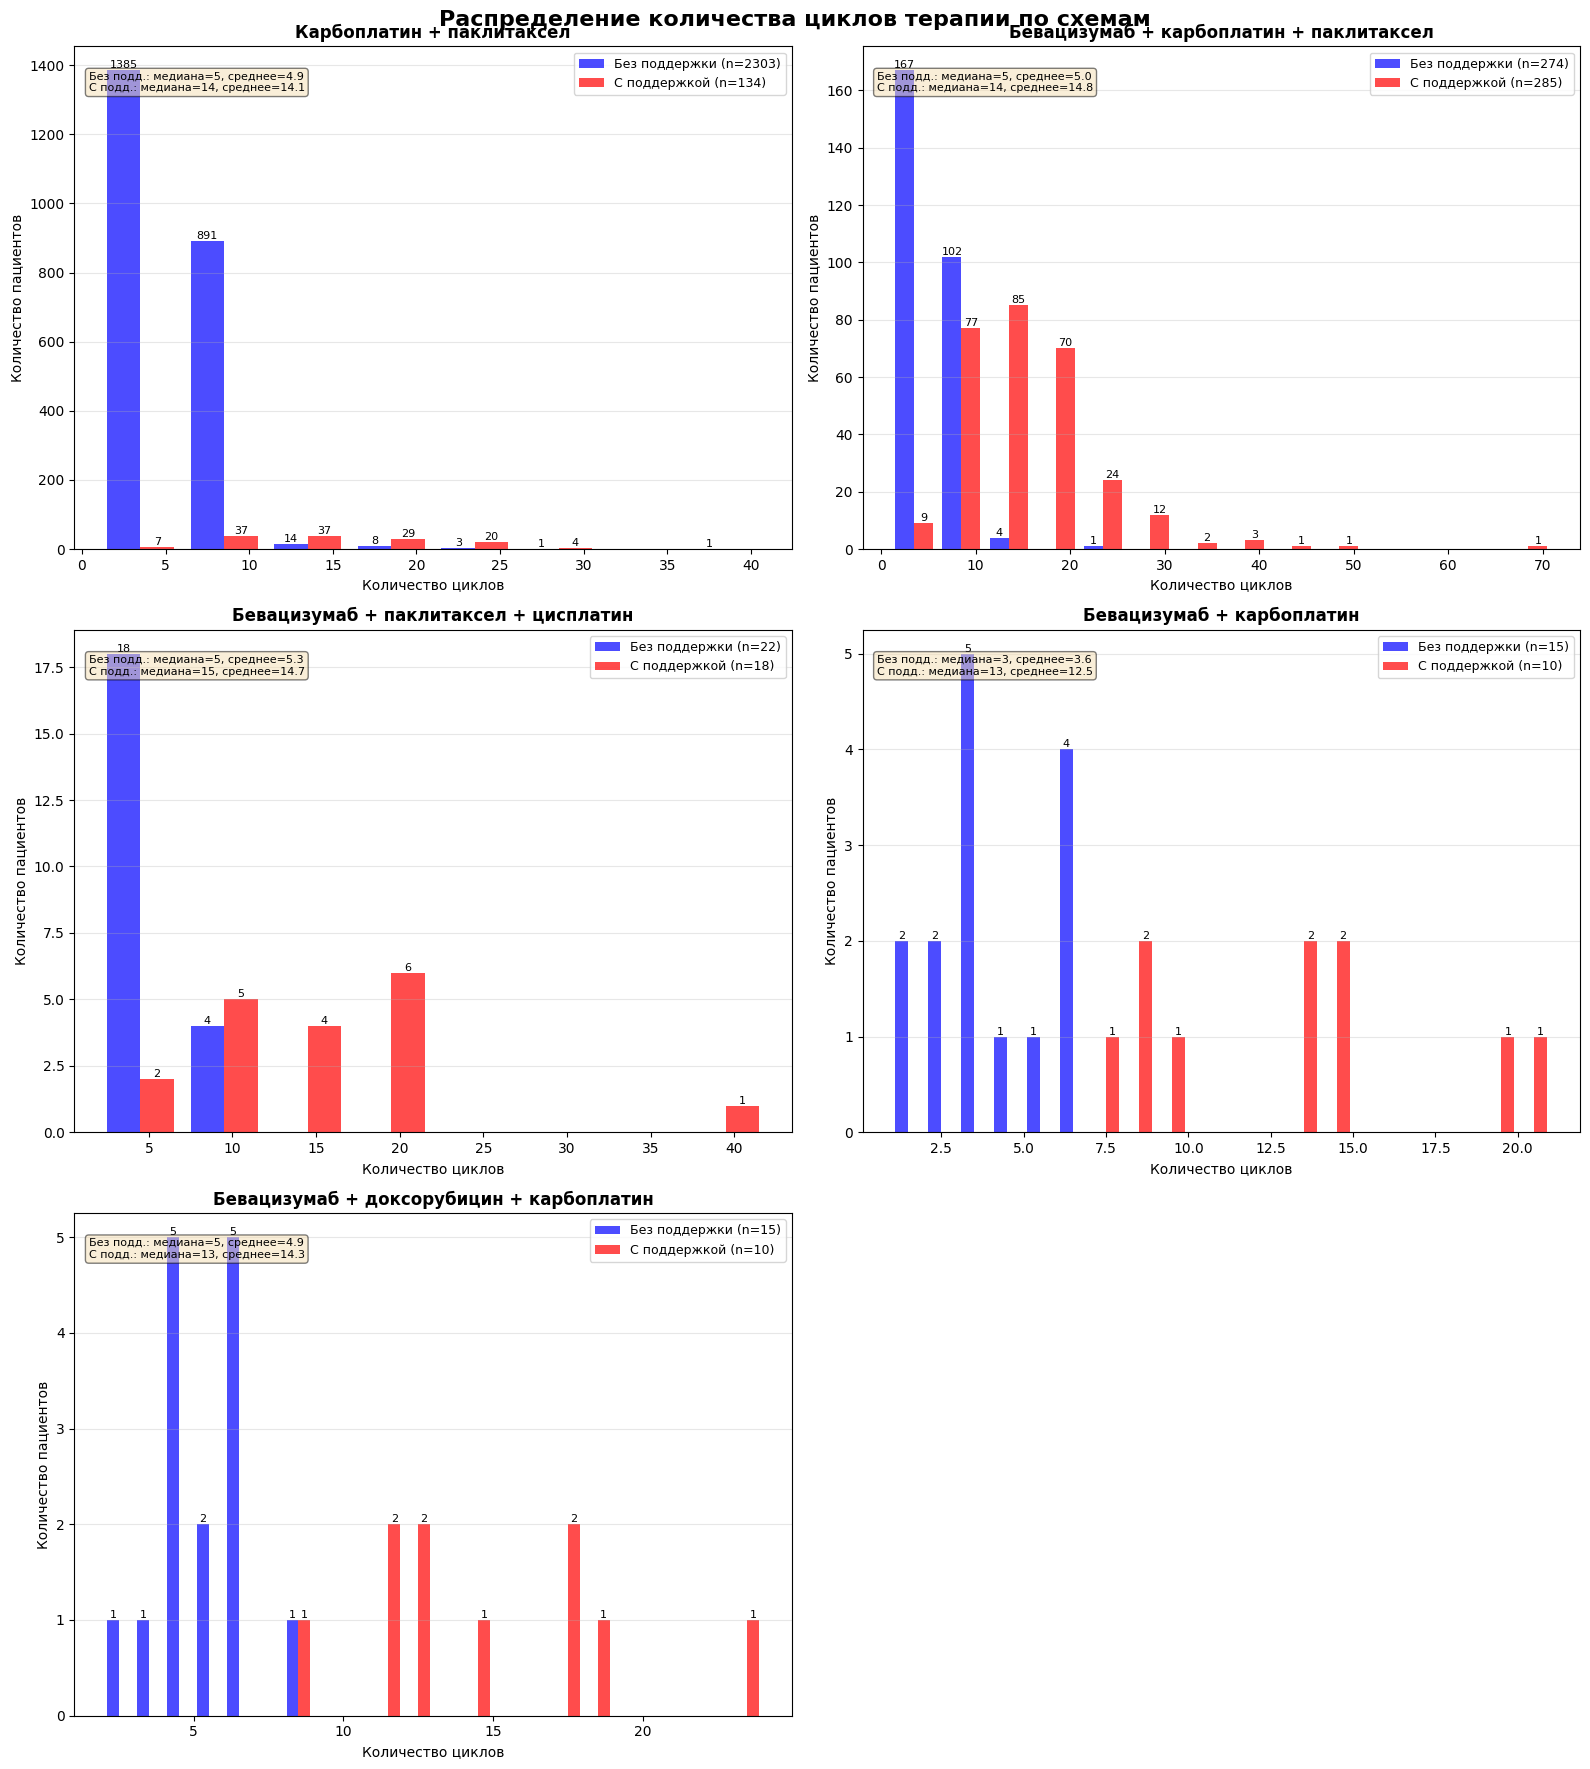


РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ЦИКЛОВ ПО СХЕМАМ

Карбоплатин + паклитаксел:

Без поддержки:
  1 циклов: 52 пациентов (2.3%)
  2 циклов: 238 пациентов (10.3%)
  3 циклов: 266 пациентов (11.6%)
  4 циклов: 299 пациентов (13.0%)
  5 циклов: 530 пациентов (23.0%)
  6 циклов: 766 пациентов (33.3%)
  7 циклов: 58 пациентов (2.5%)
  8 циклов: 48 пациентов (2.1%)
  9 циклов: 11 пациентов (0.5%)
  10 циклов: 8 пациентов (0.3%)
  11 циклов: 6 пациентов (0.3%)
  12 циклов: 3 пациентов (0.1%)
  13 циклов: 3 пациентов (0.1%)
  15 циклов: 2 пациентов (0.1%)
  17 циклов: 3 пациентов (0.1%)
  18 циклов: 4 пациентов (0.2%)
  19 циклов: 1 пациентов (0.0%)
  24 циклов: 1 пациентов (0.0%)
  25 циклов: 2 пациентов (0.1%)
  28 циклов: 1 пациентов (0.0%)
  37 циклов: 1 пациентов (0.0%)

  Статистика: медиана=5, среднее=4.9, мин=1, макс=37

С поддержкой бевацизумабом:
  5 циклов: 7 пациентов (5.2%)
  6 циклов: 7 пациентов (5.2%)
  7 циклов: 7 пациентов (5.2%)
  8 циклов: 8 пациентов (6.0%)
  9 циклов: 4 пациентов 

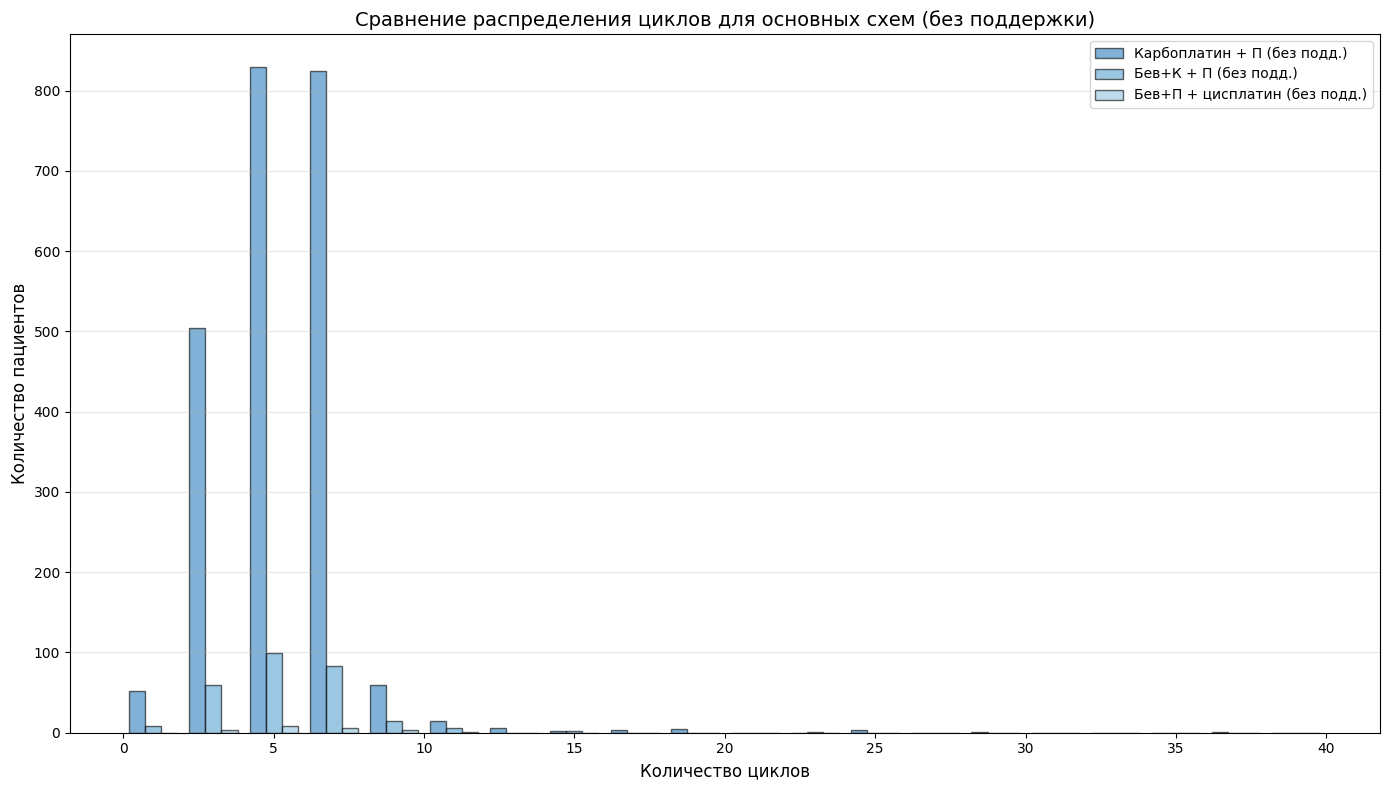

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_cycles_distribution(df, pfs_df, comparison_schemes):
    """
    Создает гистограммы распределения количества циклов для схем с поддержкой и без
    """

    # Создаем фигуру с подграфиками для каждой схемы
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()

    plot_idx = 0

    for scheme_info in comparison_schemes:
        # Получаем пациентов для каждой схемы
        patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()
        patients_with_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['with_maint']]['polis_number'].unique()

        # Подсчет циклов для схемы без поддержки
        if len(patients_no_maint) > 0:
            df_no_maint = df[
                (df['polis_number'].isin(patients_no_maint)) &
                (df['line_karina'] == 1)
            ]
            cycles_no_maint = df_no_maint.groupby('polis_number').size()
        else:
            cycles_no_maint = pd.Series()

        # Подсчет циклов для схемы с поддержкой
        if len(patients_with_maint) > 0:
            df_with_maint = df[
                (df['polis_number'].isin(patients_with_maint)) &
                (df['line_karina'] == 1)
            ]
            cycles_with_maint = df_with_maint.groupby('polis_number').size()
        else:
            cycles_with_maint = pd.Series()

        if not cycles_no_maint.empty or not cycles_with_maint.empty:
            ax = axes[plot_idx]

            # Определяем общий диапазон для биннинга
            all_cycles = pd.concat([cycles_no_maint, cycles_with_maint])
            min_cycles = int(all_cycles.min())
            max_cycles = int(all_cycles.max())

            # Создаем бины
            if max_cycles - min_cycles > 30:
                # Если диапазон большой, группируем по 5 циклов
                bins = range(min_cycles, max_cycles + 6, 5)
                bin_labels = [f"{i}-{i+4}" for i in range(min_cycles, max_cycles + 1, 5)]
            else:
                # Иначе по 1 циклу
                bins = range(min_cycles, max_cycles + 2, 1)
                bin_labels = None

            # Строим гистограммы
            if not cycles_no_maint.empty:
                counts_no_maint, bins_edges = np.histogram(cycles_no_maint, bins=bins)
                bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2
                width = (bins_edges[1] - bins_edges[0]) * 0.4

                bars1 = ax.bar(bin_centers - width/2, counts_no_maint, width,
                               label=f'Без поддержки (n={len(cycles_no_maint)})',
                               color='blue', alpha=0.7)

                # Добавляем значения на столбцы
                for bar in bars1:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}', ha='center', va='bottom', fontsize=8)

            if not cycles_with_maint.empty:
                counts_with_maint, _ = np.histogram(cycles_with_maint, bins=bins)

                bars2 = ax.bar(bin_centers + width/2, counts_with_maint, width,
                               label=f'С поддержкой (n={len(cycles_with_maint)})',
                               color='red', alpha=0.7)

                # Добавляем значения на столбцы
                for bar in bars2:
                    height = bar.get_height()
                    if height > 0:
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                               f'{int(height)}', ha='center', va='bottom', fontsize=8)

            # Настройка графика
            scheme_name = scheme_info['main']
            if len(scheme_name) > 40:
                scheme_name = scheme_name[:37] + '...'

            ax.set_title(f'{scheme_name}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Количество циклов', fontsize=10)
            ax.set_ylabel('Количество пациентов', fontsize=10)
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, axis='y', alpha=0.3)

            # Добавляем статистику
            stats_text = []
            if not cycles_no_maint.empty:
                stats_text.append(f"Без подд.: медиана={cycles_no_maint.median():.0f}, "
                                f"среднее={cycles_no_maint.mean():.1f}")
            if not cycles_with_maint.empty:
                stats_text.append(f"С подд.: медиана={cycles_with_maint.median():.0f}, "
                                f"среднее={cycles_with_maint.mean():.1f}")

            ax.text(0.02, 0.95, '\n'.join(stats_text),
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plot_idx += 1

    # Удаляем неиспользованные подграфики
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle('Распределение количества циклов терапии по схемам', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('cycles_distribution_histograms.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Создаем сводную таблицу распределения
    print("\n" + "="*100)
    print("РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ЦИКЛОВ ПО СХЕМАМ")
    print("="*100)

    for scheme_info in comparison_schemes:
        patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()
        patients_with_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['with_maint']]['polis_number'].unique()

        print(f"\n{scheme_info['main']}:")

        # Без поддержки
        if len(patients_no_maint) > 0:
            df_no_maint = df[
                (df['polis_number'].isin(patients_no_maint)) &
                (df['line_karina'] == 1)
            ]
            cycles_no_maint = df_no_maint.groupby('polis_number').size()

            print("\nБез поддержки:")
            value_counts = cycles_no_maint.value_counts().sort_index()
            for n_cycles, count in value_counts.items():
                if count > 0:
                    print(f"  {n_cycles} циклов: {count} пациентов ({count/len(cycles_no_maint)*100:.1f}%)")

            print(f"\n  Статистика: медиана={cycles_no_maint.median():.0f}, "
                  f"среднее={cycles_no_maint.mean():.1f}, "
                  f"мин={cycles_no_maint.min()}, макс={cycles_no_maint.max()}")

        # С поддержкой
        if len(patients_with_maint) > 0:
            df_with_maint = df[
                (df['polis_number'].isin(patients_with_maint)) &
                (df['line_karina'] == 1)
            ]
            cycles_with_maint = df_with_maint.groupby('polis_number').size()

            print("\nС поддержкой бевацизумабом:")
            value_counts = cycles_with_maint.value_counts().sort_index()
            for n_cycles, count in value_counts.items():
                if count > 0:
                    print(f"  {n_cycles} циклов: {count} пациентов ({count/len(cycles_with_maint)*100:.1f}%)")

            print(f"\n  Статистика: медиана={cycles_with_maint.median():.0f}, "
                  f"среднее={cycles_with_maint.mean():.1f}, "
                  f"мин={cycles_with_maint.min()}, макс={cycles_with_maint.max()}")

        print("-" * 80)

    # Дополнительно создаем общую гистограмму для всех схем
    fig2, ax2 = plt.subplots(figsize=(14, 8))

    all_data = []
    labels = []
    colors = []

    # Собираем данные для общей гистограммы
    for i, scheme_info in enumerate(comparison_schemes[:3]):  # Берем только первые 3 схемы для читаемости
        patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()

        if len(patients_no_maint) > 0:
            df_no_maint = df[
                (df['polis_number'].isin(patients_no_maint)) &
                (df['line_karina'] == 1)
            ]
            cycles = df_no_maint.groupby('polis_number').size()
            all_data.append(cycles)

            # Сокращаем название
            label = scheme_info['main']
            if 'Бевацизумаб' in label:
                label = label.replace('Бевацизумаб + ', 'Бев+')
            if 'карбоплатин' in label:
                label = label.replace('карбоплатин', 'К')
            if 'паклитаксел' in label:
                label = label.replace('паклитаксел', 'П')

            labels.append(f"{label} (без подд.)")
            colors.append(plt.cm.Blues(0.7 - i*0.15))

    # Строим гистограмму
    bins = range(0, 41, 2)  # От 0 до 40 циклов с шагом 2

    ax2.hist(all_data, bins=bins, label=labels, color=colors, alpha=0.6, edgecolor='black')

    ax2.set_xlabel('Количество циклов', fontsize=12)
    ax2.set_ylabel('Количество пациентов', fontsize=12)
    ax2.set_title('Сравнение распределения циклов для основных схем (без поддержки)', fontsize=14)
    ax2.legend()
    ax2.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('cycles_distribution_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Запуск анализа
if 'df' in locals() and 'pfs_maintenance' in locals() and 'comparison_schemes' in locals():
    plot_cycles_distribution(df, pfs_maintenance, comparison_schemes)
else:
    print("Необходимо сначала загрузить данные и запустить предыдущие анализы")

АНАЛИЗ ПАЦИЕНТОВ С КОЛИЧЕСТВОМ ЦИКЛОВ ≥ 20

Карбоплатин + паклитаксел БЕЗ поддержки:
Пациентов с ≥20 циклов: 5 из 2303 (0.22%)

Карбоплатин + паклитаксел С поддержкой бевацизумабом:
Пациентов с ≥20 циклов: 28 из 134 (20.90%)

ТОП-10 ПАЦИЕНТОВ С МАКСИМАЛЬНЫМ КОЛИЧЕСТВОМ ЦИКЛОВ:

1. Пациент 4750330875000791:
   Циклов: 37 (без поддержки)
   Период: 15.04.2020 - 17.08.2022
   Длительность: 854 дней
   Общая стоимость: 551,875 руб
   Использованные схемы:
     - Карбоплатин + паклитаксел: 37 циклов

2. Пациент 3958630875000242:
   Циклов: 28 (без поддержки)
   Период: 15.01.2020 - 02.04.2022
   Длительность: 808 дней
   Общая стоимость: 9,046,522 руб
   Использованные схемы:
     - Олапариб: 22 циклов
     - Карбоплатин + паклитаксел: 6 циклов

3. Пациент 4756220878000274:
   Циклов: 28 (с поддержкой)
   Период: 24.07.2020 - 22.02.2022
   Длительность: 578 дней
   Общая стоимость: 2,541,015 руб
   Использованные схемы:
     - Бевацизумаб: 22 циклов
     - Карбоплатин + паклитаксел: 3 цикло

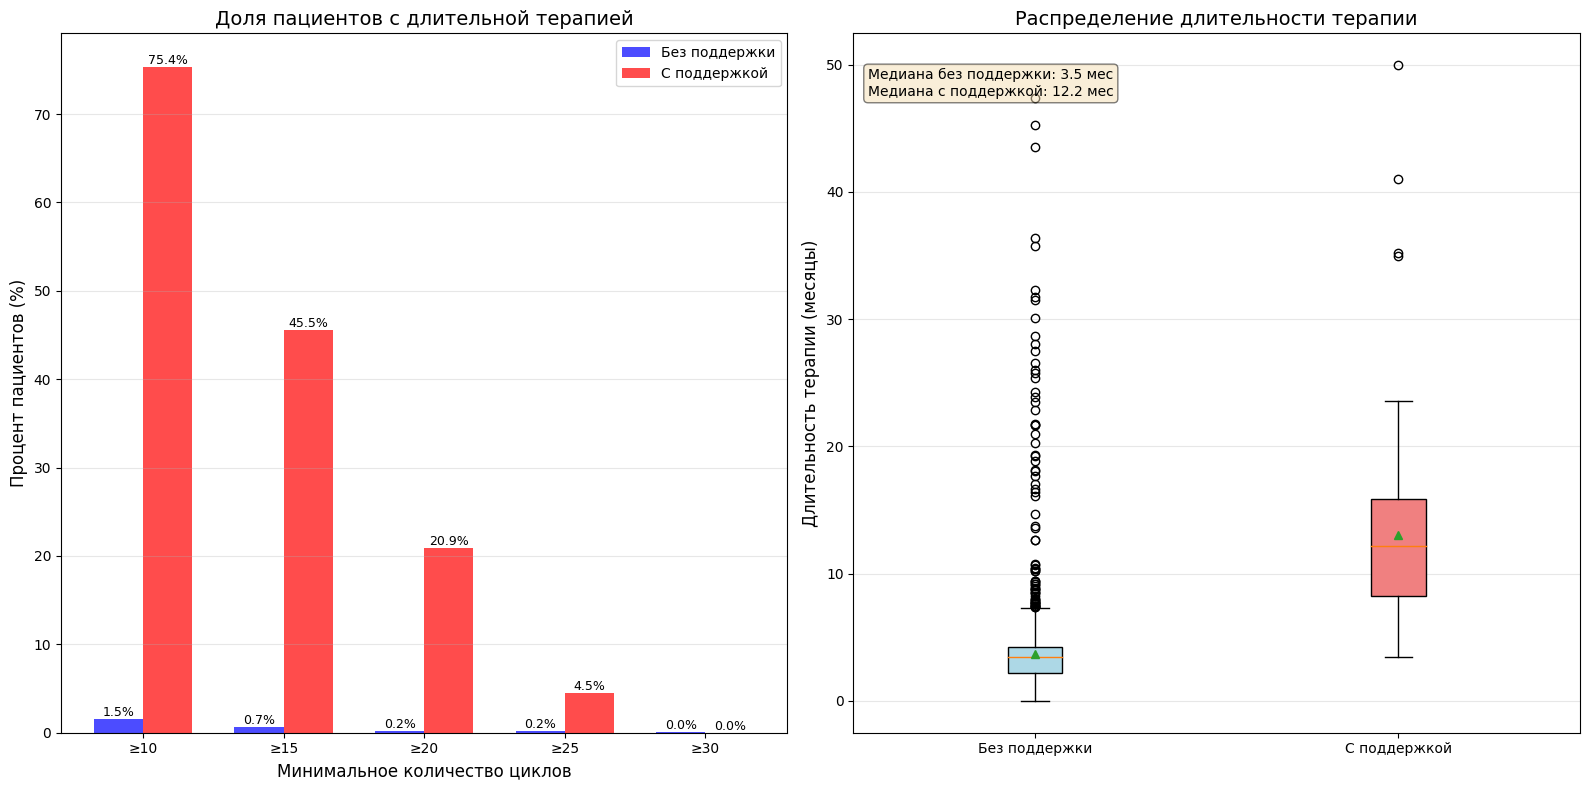

In [34]:
def analyze_extreme_cases(df, pfs_df, threshold_cycles=20):
    """
    Анализ пациентов с экстремально большим количеством циклов
    """

    print("="*100)
    print(f"АНАЛИЗ ПАЦИЕНТОВ С КОЛИЧЕСТВОМ ЦИКЛОВ ≥ {threshold_cycles}")
    print("="*100)

    extreme_patients = []

    # Анализируем схему "Карбоплатин + паклитаксел"
    scheme_name = 'Карбоплатин + паклитаксел'

    # Без поддержки
    patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_name]['polis_number'].unique()
    df_no_maint = df[(df['polis_number'].isin(patients_no_maint)) & (df['line_karina'] == 1)]
    cycles_no_maint = df_no_maint.groupby('polis_number').size()
    extreme_no_maint = cycles_no_maint[cycles_no_maint >= threshold_cycles]

    print(f"\n{scheme_name} БЕЗ поддержки:")
    print(f"Пациентов с ≥{threshold_cycles} циклов: {len(extreme_no_maint)} из {len(cycles_no_maint)} ({len(extreme_no_maint)/len(cycles_no_maint)*100:.2f}%)")

    for polis, n_cycles in extreme_no_maint.sort_values(ascending=False).items():
        patient_data = df_no_maint[df_no_maint['polis_number'] == polis]

        # Анализ длительности терапии
        dates = patient_data['date_z1'].sort_values()
        therapy_duration = (dates.max() - dates.min()).days

        # Средний интервал между циклами
        if len(dates) > 1:
            intervals = dates.diff().dropna().dt.days
            avg_interval = intervals.mean()
        else:
            avg_interval = 0

        # Проверяем, была ли прогрессия (переход на 2 линию)
        has_progression = len(df[(df['polis_number'] == polis) & (df['line_karina'] == 2)]) > 0

        extreme_patients.append({
            'polis_number': polis,
            'Схема': scheme_name,
            'Поддержка': 'Нет',
            'Количество циклов': n_cycles,
            'Длительность (дни)': therapy_duration,
            'Длительность (месяцы)': therapy_duration / 30.44,
            'Средний интервал (дни)': avg_interval,
            'Прогрессия на 2 линию': 'Да' if has_progression else 'Нет',
            'Общая стоимость': f"{patient_data['tariff'].sum():,.0f}"
        })

    # С поддержкой
    patients_with_maint = pfs_df[pfs_df['combined_scheme'] == f'{scheme_name} (поддержка Бевацизумаб)']['polis_number'].unique()
    df_with_maint = df[(df['polis_number'].isin(patients_with_maint)) & (df['line_karina'] == 1)]
    cycles_with_maint = df_with_maint.groupby('polis_number').size()
    extreme_with_maint = cycles_with_maint[cycles_with_maint >= threshold_cycles]

    print(f"\n{scheme_name} С поддержкой бевацизумабом:")
    print(f"Пациентов с ≥{threshold_cycles} циклов: {len(extreme_with_maint)} из {len(cycles_with_maint)} ({len(extreme_with_maint)/len(cycles_with_maint)*100:.2f}%)")

    # Детальный анализ топ-10 экстремальных случаев
    print("\nТОП-10 ПАЦИЕНТОВ С МАКСИМАЛЬНЫМ КОЛИЧЕСТВОМ ЦИКЛОВ:")
    all_extreme = pd.concat([extreme_no_maint, extreme_with_maint]).sort_values(ascending=False).head(10)

    for i, (polis, n_cycles) in enumerate(all_extreme.items(), 1):
        # Определяем тип схемы
        if polis in extreme_no_maint.index:
            scheme_type = "без поддержки"
            patient_df = df_no_maint
        else:
            scheme_type = "с поддержкой"
            patient_df = df_with_maint

        patient_data = patient_df[patient_df['polis_number'] == polis]

        print(f"\n{i}. Пациент {polis}:")
        print(f"   Циклов: {n_cycles} ({scheme_type})")
        print(f"   Период: {patient_data['date_z1'].min().strftime('%d.%m.%Y')} - {patient_data['date_z1'].max().strftime('%d.%m.%Y')}")
        print(f"   Длительность: {(patient_data['date_z1'].max() - patient_data['date_z1'].min()).days} дней")
        print(f"   Общая стоимость: {patient_data['tariff'].sum():,.0f} руб")

        # Проверяем схемы в циклах
        schemes_distribution = patient_data['drugs_in_scheme'].value_counts()
        print("   Использованные схемы:")
        for scheme, count in schemes_distribution.items():
            print(f"     - {scheme}: {count} циклов")

    # Сравнительный анализ
    print("\n" + "="*80)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ДЛИТЕЛЬНОЙ ТЕРАПИИ")
    print("="*80)

    # Процент пациентов с длительной терапией
    analysis_data = []

    for cycles_threshold in [10, 15, 20, 25, 30]:
        no_maint_count = len(cycles_no_maint[cycles_no_maint >= cycles_threshold])
        with_maint_count = len(cycles_with_maint[cycles_with_maint >= cycles_threshold])

        analysis_data.append({
            'Порог циклов': f'≥{cycles_threshold}',
            'Без поддержки (n)': no_maint_count,
            'Без поддержки (%)': f"{no_maint_count/len(cycles_no_maint)*100:.1f}%",
            'С поддержкой (n)': with_maint_count,
            'С поддержкой (%)': f"{with_maint_count/len(cycles_with_maint)*100:.1f}%",
            'Кратность увеличения': f"{with_maint_count/len(cycles_with_maint) / (no_maint_count/len(cycles_no_maint)):.1f}x" if no_maint_count > 0 else "—"
        })

    analysis_df = pd.DataFrame(analysis_data)
    print(analysis_df.to_string(index=False))

    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # График 1: Процент пациентов выше порога
    thresholds = [10, 15, 20, 25, 30]
    pct_no_maint = [(cycles_no_maint >= t).sum() / len(cycles_no_maint) * 100 for t in thresholds]
    pct_with_maint = [(cycles_with_maint >= t).sum() / len(cycles_with_maint) * 100 for t in thresholds]

    x = np.arange(len(thresholds))
    width = 0.35

    bars1 = ax1.bar(x - width/2, pct_no_maint, width, label='Без поддержки', color='blue', alpha=0.7)
    bars2 = ax1.bar(x + width/2, pct_with_maint, width, label='С поддержкой', color='red', alpha=0.7)

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

    ax1.set_xlabel('Минимальное количество циклов', fontsize=12)
    ax1.set_ylabel('Процент пациентов (%)', fontsize=12)
    ax1.set_title('Доля пациентов с длительной терапией', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'≥{t}' for t in thresholds])
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)

    # График 2: Box plot длительности терапии
    duration_no_maint = []
    duration_with_maint = []

    for polis, n_cycles in cycles_no_maint.items():
        patient_data = df_no_maint[df_no_maint['polis_number'] == polis]
        duration = (patient_data['date_z1'].max() - patient_data['date_z1'].min()).days / 30.44
        duration_no_maint.append(duration)

    for polis, n_cycles in cycles_with_maint.items():
        patient_data = df_with_maint[df_with_maint['polis_number'] == polis]
        duration = (patient_data['date_z1'].max() - patient_data['date_z1'].min()).days / 30.44
        duration_with_maint.append(duration)

    box_data = [duration_no_maint, duration_with_maint]
    box = ax2.boxplot(box_data, labels=['Без поддержки', 'С поддержкой'],
                      patch_artist=True, showmeans=True)

    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax2.set_ylabel('Длительность терапии (месяцы)', fontsize=12)
    ax2.set_title('Распределение длительности терапии', fontsize=14)
    ax2.grid(True, axis='y', alpha=0.3)

    # Добавляем статистику
    stats_text = f"Медиана без поддержки: {np.median(duration_no_maint):.1f} мес\n"
    stats_text += f"Медиана с поддержкой: {np.median(duration_with_maint):.1f} мес"
    ax2.text(0.02, 0.95, stats_text, transform=ax2.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('extreme_cases_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return pd.DataFrame(extreme_patients)

# Запуск анализа
if 'df' in locals() and 'pfs_maintenance' in locals():
    extreme_cases = analyze_extreme_cases(df, pfs_maintenance, threshold_cycles=20)
else:
    print("Необходимо сначала загрузить данные")

In [35]:
def get_all_patients_without_maintenance(df, pfs_df, comparison_schemes):
    """
    Получает список всех пациентов, получавших терапию без поддержки
    """

    print("="*100)
    print("ПАЦИЕНТЫ, ПОЛУЧАВШИЕ ТЕРАПИЮ БЕЗ ПОДДЕРЖКИ")
    print("="*100)

    all_patients_no_maintenance = {}

    for scheme_info in comparison_schemes:
        # Получаем пациентов без поддержки для каждой схемы
        patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()

        if len(patients_no_maint) > 0:
            # Получаем дополнительную информацию о пациентах
            df_scheme = df[
                (df['polis_number'].isin(patients_no_maint)) &
                (df['line_karina'] == 1)
            ]

            # Собираем информацию о каждом пациенте
            patient_info = []
            for polis in patients_no_maint:
                patient_data = df_scheme[df_scheme['polis_number'] == polis]
                if not patient_data.empty:
                    patient_info.append({
                        'polis_number': polis,
                        'Количество циклов': len(patient_data),
                        'Дата начала': patient_data['date_z1'].min(),
                        'Дата окончания': patient_data['date_z1'].max(),
                        'Общая стоимость': patient_data['tariff'].sum()
                    })

            all_patients_no_maintenance[scheme_info['main']] = {
                'patients': patients_no_maint,
                'details': pd.DataFrame(patient_info)
            }

            print(f"\n{scheme_info['main']}:")
            print(f"Всего пациентов без поддержки: {len(patients_no_maint)}")

    # Создаем общий список всех уникальных пациентов без поддержки
    all_unique_patients = set()
    for scheme, data in all_patients_no_maintenance.items():
        all_unique_patients.update(data['patients'])

    print(f"\n{'='*80}")
    print(f"ИТОГО УНИКАЛЬНЫХ ПАЦИЕНТОВ БЕЗ ПОДДЕРЖКИ: {len(all_unique_patients)}")
    print(f"{'='*80}")

    # Сохраняем в файлы
    with pd.ExcelWriter('patients_without_maintenance.xlsx', engine='openpyxl') as writer:
        # Сводная информация
        summary_data = []
        for scheme, data in all_patients_no_maintenance.items():
            summary_data.append({
                'Схема': scheme,
                'Количество пациентов': len(data['patients'])
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Сводка', index=False)

        # Отдельные листы для каждой схемы
        for scheme, data in all_patients_no_maintenance.items():
            # Создаем DataFrame с номерами полисов
            patients_df = pd.DataFrame({
                'polis_number': list(data['patients']),
                'Схема': scheme
            })

            # Добавляем детальную информацию
            if not data['details'].empty:
                patients_with_details = patients_df.merge(
                    data['details'],
                    on='polis_number',
                    how='left'
                )

                # Сортируем по количеству циклов (убывание)
                patients_with_details = patients_with_details.sort_values(
                    'Количество циклов',
                    ascending=False
                )

                # Сохраняем на отдельный лист
                sheet_name = scheme[:30]  # Ограничение Excel на длину имени
                patients_with_details.to_excel(writer, sheet_name=sheet_name, index=False)

        # Общий список всех пациентов
        all_patients_df = pd.DataFrame({
            'polis_number': list(all_unique_patients)
        })
        all_patients_df.to_excel(writer, sheet_name='Все пациенты', index=False)

    print(f"\nДанные сохранены в файл: patients_without_maintenance.xlsx")

    # Выводим примеры для каждой схемы
    for scheme, data in all_patients_no_maintenance.items():
        print(f"\n{'='*80}")
        print(f"ПРИМЕРЫ ПАЦИЕНТОВ: {scheme}")
        print(f"{'='*80}")

        # Сортируем по количеству циклов
        if not data['details'].empty:
            sorted_patients = data['details'].sort_values('Количество циклов', ascending=False)

            # Топ-10 по количеству циклов
            print("\nТоп-10 пациентов по количеству циклов:")
            for idx, row in sorted_patients.head(10).iterrows():
                print(f"{row['polis_number']}: {row['Количество циклов']} циклов, "
                      f"стоимость {row['Общая стоимость']:,.0f} руб")

            # Случайная выборка
            print("\nСлучайная выборка из 10 пациентов:")
            random_sample = sorted_patients.sample(min(10, len(sorted_patients)))
            for idx, row in random_sample.iterrows():
                print(f"{row['polis_number']}: {row['Количество циклов']} циклов")

    # Создаем текстовый файл со всеми номерами полисов
    with open('all_patients_without_maintenance.txt', 'w') as f:
        f.write("ВСЕ ПАЦИЕНТЫ БЕЗ ПОДДЕРЖИВАЮЩЕЙ ТЕРАПИИ\n")
        f.write("="*50 + "\n\n")

        for scheme, data in all_patients_no_maintenance.items():
            f.write(f"\n{scheme} ({len(data['patients'])} пациентов):\n")
            f.write("-"*50 + "\n")
            for polis in sorted(data['patients']):
                f.write(f"{polis}\n")

    print(f"\nПолный список номеров полисов сохранен в файл: all_patients_without_maintenance.txt")

    return all_patients_no_maintenance

# Запуск функции
if 'df' in locals() and 'pfs_maintenance' in locals() and 'comparison_schemes' in locals():
    patients_no_maintenance = get_all_patients_without_maintenance(df, pfs_maintenance, comparison_schemes)

    # Дополнительно: вывод первых 100 пациентов для схемы "Карбоплатин + паклитаксел"
    print("\n" + "="*100)
    print("ПЕРВЫЕ 100 ПАЦИЕНТОВ: Карбоплатин + паклитаксел (без поддержки)")
    print("="*100)

    if 'Карбоплатин + паклитаксел' in patients_no_maintenance:
        kp_patients = list(patients_no_maintenance['Карбоплатин + паклитаксел']['patients'])[:100]
        for i, polis in enumerate(kp_patients, 1):
            print(f"{i:3d}. {polis}")
else:
    print("Необходимо сначала загрузить данные и запустить анализ")

ПАЦИЕНТЫ, ПОЛУЧАВШИЕ ТЕРАПИЮ БЕЗ ПОДДЕРЖКИ

Карбоплатин + паклитаксел:
Всего пациентов без поддержки: 2303

Бевацизумаб + карбоплатин + паклитаксел:
Всего пациентов без поддержки: 274

Бевацизумаб + паклитаксел + цисплатин:
Всего пациентов без поддержки: 22

Бевацизумаб + карбоплатин:
Всего пациентов без поддержки: 15

Бевацизумаб + доксорубицин + карбоплатин:
Всего пациентов без поддержки: 15

ИТОГО УНИКАЛЬНЫХ ПАЦИЕНТОВ БЕЗ ПОДДЕРЖКИ: 2629

Данные сохранены в файл: patients_without_maintenance.xlsx

ПРИМЕРЫ ПАЦИЕНТОВ: Карбоплатин + паклитаксел

Топ-10 пациентов по количеству циклов:
4750330875000791: 37 циклов, стоимость 551,875 руб
3958630875000242: 28 циклов, стоимость 9,046,522 руб
2950540881000120: 25 циклов, стоимость 8,396,307 руб
1048220876000031: 25 циклов, стоимость 7,263,023 руб
3954720879000399: 24 циклов, стоимость 7,571,432 руб
4756930881000067: 19 циклов, стоимость 285,808 руб
4752930878000264: 18 циклов, стоимость 355,327 руб
2955830887000017: 18 циклов, стоимость 5,339

In [36]:
def get_patients_above_threshold_cycles(df, pfs_df, comparison_schemes, threshold=7):
    """
    Получает пациентов без поддержки с количеством циклов выше заданного порога
    """

    print("="*100)
    print(f"ПАЦИЕНТЫ БЕЗ ПОДДЕРЖКИ С КОЛИЧЕСТВОМ ЦИКЛОВ > {threshold}")
    print("="*100)

    all_patients_above_threshold = []

    for scheme_info in comparison_schemes:
        # Получаем пациентов без поддержки
        patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()

        if len(patients_no_maint) > 0:
            # Фильтруем данные
            df_scheme = df[
                (df['polis_number'].isin(patients_no_maint)) &
                (df['line_karina'] == 1)
            ]

            # Подсчет циклов для каждого пациента
            cycles_per_patient = df_scheme.groupby('polis_number').size()

            # Фильтруем пациентов с циклами > threshold
            patients_above = cycles_per_patient[cycles_per_patient > threshold]

            print(f"\n{scheme_info['main']}:")
            print(f"Всего пациентов без поддержки: {len(cycles_per_patient)}")
            print(f"Пациентов с > {threshold} циклов: {len(patients_above)} ({len(patients_above)/len(cycles_per_patient)*100:.1f}%)")

            # Собираем детальную информацию
            for polis, n_cycles in patients_above.sort_values(ascending=False).items():
                patient_data = df_scheme[df_scheme['polis_number'] == polis]

                # Даты терапии
                start_date = patient_data['date_z1'].min()
                end_date = patient_data['date_z1'].max()
                duration_days = (end_date - start_date).days if pd.notna(start_date) and pd.notna(end_date) else 0

                # Стоимость
                total_cost = patient_data['tariff'].sum()

                # Основная схема
                main_drug_scheme = patient_data['drugs_in_scheme'].mode()[0] if not patient_data['drugs_in_scheme'].mode().empty else 'Н/Д'

                all_patients_above_threshold.append({
                    'polis_number': polis,
                    'Схема': scheme_info['main'],
                    'Количество циклов': n_cycles,
                    'Дата начала': start_date.strftime('%d.%m.%Y') if pd.notna(start_date) else 'Н/Д',
                    'Дата окончания': end_date.strftime('%d.%m.%Y') if pd.notna(end_date) else 'Н/Д',
                    'Длительность (дни)': duration_days,
                    'Общая стоимость': total_cost,
                    'Стоимость (форматир.)': f"{total_cost:,.0f}",
                    'Основная схема препаратов': main_drug_scheme
                })

    # Создаем DataFrame
    result_df = pd.DataFrame(all_patients_above_threshold)

    if not result_df.empty:
        # Сортируем по количеству циклов
        result_df = result_df.sort_values(['Схема', 'Количество циклов'], ascending=[True, False])

        # Сохраняем в Excel
        filename = f'patients_no_maintenance_above_{threshold}_cycles.xlsx'
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # Общий список
            result_df.to_excel(writer, sheet_name='Все пациенты', index=False)

            # Отдельные листы для каждой схемы
            for scheme in result_df['Схема'].unique():
                scheme_data = result_df[result_df['Схема'] == scheme]
                sheet_name = scheme[:30]  # Ограничение Excel
                scheme_data.to_excel(writer, sheet_name=sheet_name, index=False)

        print(f"\nДанные сохранены в файл: {filename}")

        # Создаем текстовый файл с номерами полисов
        txt_filename = f'polis_numbers_above_{threshold}_cycles.txt'
        with open(txt_filename, 'w') as f:
            f.write(f"НОМЕРА ПОЛИСОВ ПАЦИЕНТОВ БЕЗ ПОДДЕРЖКИ С КОЛИЧЕСТВОМ ЦИКЛОВ > {threshold}\n")
            f.write("="*70 + "\n\n")

            for scheme in result_df['Схема'].unique():
                scheme_data = result_df[result_df['Схема'] == scheme]
                f.write(f"\n{scheme} ({len(scheme_data)} пациентов):\n")
                f.write("-"*50 + "\n")

                for _, row in scheme_data.iterrows():
                    f.write(f"{row['polis_number']} - {row['Количество циклов']} циклов\n")

        print(f"Список номеров полисов сохранен в файл: {txt_filename}")

        # Выводим статистику
        print("\n" + "="*80)
        print("СТАТИСТИКА ПО ПАЦИЕНТАМ С ДЛИТЕЛЬНОЙ ТЕРАПИЕЙ")
        print("="*80)

        for scheme in result_df['Схема'].unique():
            scheme_data = result_df[result_df['Схема'] == scheme]
            print(f"\n{scheme}:")
            print(f"  Количество пациентов: {len(scheme_data)}")
            print(f"  Диапазон циклов: {scheme_data['Количество циклов'].min()} - {scheme_data['Количество циклов'].max()}")
            print(f"  Средняя стоимость: {scheme_data['Общая стоимость'].mean():,.0f} руб")
            print(f"  Общая стоимость: {scheme_data['Общая стоимость'].sum():,.0f} руб")

        # Выводим примеры для схемы "Карбоплатин + паклитаксел"
        kp_scheme = 'Карбоплатин + паклитаксел'
        if kp_scheme in result_df['Схема'].values:
            print(f"\n{'='*80}")
            print(f"ПАЦИЕНТЫ С {kp_scheme} И КОЛИЧЕСТВОМ ЦИКЛОВ > {threshold}")
            print(f"{'='*80}")

            kp_data = result_df[result_df['Схема'] == kp_scheme]

            # Группируем по количеству циклов
            cycles_distribution = kp_data['Количество циклов'].value_counts().sort_index()
            print("\nРаспределение по количеству циклов:")
            for n_cycles, count in cycles_distribution.items():
                print(f"  {n_cycles} циклов: {count} пациентов")

            # Выводим всех пациентов
            print(f"\nВСЕ ПАЦИЕНТЫ ({len(kp_data)} человек):")
            print("-"*80)
            for idx, (_, row) in enumerate(kp_data.iterrows(), 1):
                print(f"{idx:3d}. {row['polis_number']} - {row['Количество циклов']} циклов, "
                      f"{row['Длительность (дни)']} дней, {row['Стоимость (форматир.)']} руб")

    else:
        print(f"\nНе найдено пациентов с количеством циклов > {threshold}")

    return result_df

# Запуск анализа с порогом 7 циклов
if 'df' in locals() and 'pfs_maintenance' in locals() and 'comparison_schemes' in locals():
    patients_above_7 = get_patients_above_threshold_cycles(df, pfs_maintenance, comparison_schemes, threshold=7)

    # Дополнительный анализ для разных порогов
    print("\n" + "="*100)
    print("СВОДКА ПО РАЗНЫМ ПОРОГАМ ЦИКЛОВ")
    print("="*100)

    for threshold in [7, 10, 15, 20]:
        print(f"\nПорог > {threshold} циклов:")
        for scheme_info in comparison_schemes:
            patients_no_maint = pfs_df[pfs_df['combined_scheme'] == scheme_info['main']]['polis_number'].unique()
            if len(patients_no_maint) > 0:
                df_scheme = df[
                    (df['polis_number'].isin(patients_no_maint)) &
                    (df['line_karina'] == 1)
                ]
                cycles_per_patient = df_scheme.groupby('polis_number').size()
                patients_above = cycles_per_patient[cycles_per_patient > threshold]

                if len(patients_above) > 0:
                    print(f"  {scheme_info['main'][:40]}...: {len(patients_above)} пациентов")
else:
    print("Необходимо сначала загрузить данные")

ПАЦИЕНТЫ БЕЗ ПОДДЕРЖКИ С КОЛИЧЕСТВОМ ЦИКЛОВ > 7

Карбоплатин + паклитаксел:
Всего пациентов без поддержки: 2303
Пациентов с > 7 циклов: 94 (4.1%)

Бевацизумаб + карбоплатин + паклитаксел:
Всего пациентов без поддержки: 274
Пациентов с > 7 циклов: 24 (8.8%)

Бевацизумаб + паклитаксел + цисплатин:
Всего пациентов без поддержки: 22
Пациентов с > 7 циклов: 4 (18.2%)

Бевацизумаб + карбоплатин:
Всего пациентов без поддержки: 15
Пациентов с > 7 циклов: 0 (0.0%)

Бевацизумаб + доксорубицин + карбоплатин:
Всего пациентов без поддержки: 15
Пациентов с > 7 циклов: 1 (6.7%)

Данные сохранены в файл: patients_no_maintenance_above_7_cycles.xlsx
Список номеров полисов сохранен в файл: polis_numbers_above_7_cycles.txt

СТАТИСТИКА ПО ПАЦИЕНТАМ С ДЛИТЕЛЬНОЙ ТЕРАПИЕЙ

Бевацизумаб + доксорубицин + карбоплатин:
  Количество пациентов: 1
  Диапазон циклов: 8 - 8
  Средняя стоимость: 1,322,695 руб
  Общая стоимость: 1,322,695 руб

Бевацизумаб + карбоплатин + паклитаксел:
  Количество пациентов: 24
  Диапазо

NameError: name 'pfs_df' is not defined